
### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com 


In [102]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']


In [103]:
import os
import shutil
import yaml
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import sqlite3
from typing import TypedDict, Annotated
import requests

import langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import SimpleJsonOutputParser, JsonOutputParser, StrOutputParser
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.errors import NodeInterrupt

import numpy as np
import pandas as pd
import umap

import sklearn
from sklearn.cluster import DBSCAN

import bs4
from urllib.parse import urljoin, urlparse

import multiprocessing
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

# import pyperclip
# import shlex

import openai
from openai import OpenAI

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

VERBOSE=1
from ainb_const import (DOWNLOAD_DIR, PAGES_DIR,
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, CANONICAL_TOPICS,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT,
                        TOP_CATEGORIES_PROMPT, TOPIC_REWRITE_PROMPT, REWRITE_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE, SQLITE_DB,
                        HOSTNAME_SKIPLIST, SITE_NAME_SKIPLIST, TOPSOURCES,
                        SCREENSHOT_DIR, sleeptime

                       )
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article,
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            unicode_to_ascii, send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file,
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory,
                            process_url_queue_factory, get_google_news_redirects)
from ainb_llm import (paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries,
                      fetch_openai_summary, count_tokens, trunc_tokens,
                      categorize_headline, categorize_df, clean_topics,
                      get_site_name, fetch_missing_site_names)


import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()

import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

from bs4 import BeautifulSoup

import pdb



In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:26:25) [Clang 17.0.6 ]
LangChain         0.3.8
OpenAI            1.55.0
trafilatura       1.12.2
numpy             1.26.4
pandas            2.2.3
sklearn           1.5.2
umap              0.5.7
podcastfy         0.4.1


# Test LLM calling

In [4]:
# a basic LLM call with langchain
model = ChatOpenAI(model=MODEL)

model.invoke([
    SystemMessage(content="Translate the following from English into Italian"),
    HumanMessage(content='Listen to me. You are beautiful. You are perfect and I love you.'),
])


2024-11-24 07:07:52,666 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content='Ascoltami. Sei bellissima. Sei perfetta e ti amo.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 34, 'total_tokens': 50, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'chatgpt-4o-latest', 'system_fingerprint': 'fp_28935134ad', 'finish_reason': 'stop', 'logprobs': None}, id='run-90706529-81b2-4dff-8415-d00050198cc5-0', usage_metadata={'input_tokens': 34, 'output_tokens': 16, 'total_tokens': 50, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
# use a langchain template
system_template = "Translate the following into {language}:"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)
parser = StrOutputParser()
chain = prompt_template | model | parser
chain.invoke({"language": "italian", "text": "hi"})


2024-11-24 07:07:52,892 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Ciao'

In [6]:
# time multiple templates (single-threaded)
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

system_template = 'Translate the following into {language}:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    response = ""
    # stream tokens as they are generated
    for r in chain.stream(tpl):
        print(r, end="")
        response += r
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")


2024-11-24 07:07:53,360 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.

2024-11-24 07:07:54,547 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hör mir zu. Du bist makellos. Du bist exquisit, und ich liebe dich.

2024-11-24 07:07:54,898 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Escúchame. Eres perfecta. Eres hermosa y te amo.

2024-11-24 07:07:56,015 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ascoltami. Sei incredibile. Sei magnifico e ti amo.

2024-11-24 07:07:56,451 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hallgass rám. Elbűvölő vagy. Elképesztően gyönyörű vagy, és szeretlek.

Elapsed seconds: 3.756620


In [7]:
# same but send all at once using asyncio

async def async_langchain(chain, input_dict):
    response = await chain.ainvoke(input_dict)
    return response


prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    task = asyncio.create_task(async_langchain(chain, d))
    tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()


difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")
print("\n".join(responses))


2024-11-24 07:07:57,068 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-24 07:07:57,106 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-24 07:07:57,110 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-24 07:07:57,154 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-24 07:07:57,184 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Elapsed seconds: 0.517451
Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.
Hör mir zu. Du bist makellos. Du bist exquisit, und ich liebe dich.
Escúchame. Eres perfecta. Eres preciosa y te amo.
Ascoltami. Sei incredibile. Sei magnifico/a e ti amo.
Hallgass rám. Elbűvölő vagy. Lenyűgöző vagy, és szeretlek.


In [8]:
# test o1-preview, note temperature, system prompt not supported
# client = OpenAI()
# response = client.chat.completions.create(
#     model="o1-preview",
#     messages=[
#         {
#             "role": "user",
#             "content": "Write a Python script that takes a matrix represented as a string with format '[1,2],[3,4],[5,6]' and prints the transpose in the same format."
#         }
#     ]
# )
# print(response.choices[0].message.content)


# Functions for state graph
- Each takes a state dict and returns updated state dict
- We will use these later to construct a LangGraph agent workflow

In [9]:
DEBUG = False
N_BROWSERS = 4
MAX_EDITS = 2
before_date = None
# before_date = '2024-10-19 15:00:00'
do_download = True


In [10]:
# class to maintain state within graph
# import pydantic

class AgentState(TypedDict):
    AIdf: list[dict]                    #  the current working set of headlines (pandas dataframe not supported)
    before_date: str                    #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool                   #  if False use existing files, else download from sources
    sources: dict                       #  sources to scrap
    sources_reverse: dict[str, str]     #  map file names to sources
    bullets: list[str]                  #  bullet points for summary email
    summary: str                        #  final summary
    cluster_topics: list[str]           #  list of cluster topics
    topics_str: str                     #  edited topics
    n_edits: int                        #  count edit iterations so we don't keep editing forever
    edit_complete: bool                 #  edit will update if no more edits to make
    # message thread with OpenAI
    # messages: Annotated[list[AnyMessage], operator.add]


In [11]:
test_state = AgentState(
    {'AIdf': [{}],
    'before_date': before_date,
    'do_download': do_download,
    'sources': {},
    'sources_reverse': {},
    'bullets': '',
    'summary': '',
    'cluster_topics': [],
    'topics_str': '',
    'n_edits': 0,
    'edit_complete': False,
    }
)


In [12]:
# Initialize reading configurations from YAML file

def fn_initialize(state: AgentState) -> AgentState:
    """
    Initializes the agent state by loading source configurations from SOURCECONFIG (sources.yaml) .

    Args:
        state (AgentState): The current state of the agent.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        AgentState: The updated state of the agent.

    Raises:
        yaml.YAMLError: If there is an error while loading the YAML file.

    """

    #  load sources to scrape from sources.yaml
    with open(SOURCECONFIG, "r") as stream:
        try:
            state['sources'] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

    log(f"Initialized {len(state['sources'])} items in sources from {SOURCECONFIG}")

    # make a reverse dict to map file titles to source names
    state['sources_reverse'] = {}
    for k, v in state['sources'].items():
        log(f"{k} -> {v['url']} -> {v['title']}.html")
        v['sourcename'] = k
        # map filename (title) to source name
        state['sources_reverse'][v['title']] = k

    log(f"Initialized {len(state['sources_reverse'])} items in sources_reverse")

    return state


if DEBUG:
    test_state = fn_initialize(test_state)


In [13]:
# scrape sources with selenium and save local files in DOWNLOAD_DIR (htmldata)
def fn_download_sources(state: AgentState) -> AgentState:
    """
    Scrapes sources and saves HTML files.
    If state["do_download"] is True, deletes all files in DOWNLOAD_DIR (htmldata) and scrapes fresh copies.
    If state["do_download"] is False, uses existing files in DOWNLOAD_DIR.
    Uses state["sources"] for config info on sources to scrape
    For each source, saves the current filename to state["sources"][sourcename]['latest']

    Args:
        state (AgentState): The current state of the agent.
        do_delete (bool, optional): Whether to delete files in DOWNLOAD_DIR. Defaults to True.

    Returns:
        AgentState: The updated state of the agent.
    """

    if state.get("do_download"):
        # empty download directories
        delete_files(DOWNLOAD_DIR)
        delete_files(PAGES_DIR)
        delete_files(SCREENSHOT_DIR)

        # save each file specified from sources
        log(f"Saving HTML files using {N_BROWSERS} browsers")

        # Create a queue for multiprocessing and populate it
        queue = multiprocessing.Queue()
        for item in state.get("sources").values():
            queue.put(item)

        # Function to take the queue and pop entries off and process until none are left
        # lets you create an array of functions with different args
        callable = process_source_queue_factory(queue)

        saved_pages = launch_drivers(N_BROWSERS, callable)
        for sourcename, file in saved_pages:
            log(f"Downloaded {sourcename} to {file}")
            state['sources'][sourcename]['latest'] = file
        log(f"Saved {len(saved_pages)} HTML files")

    else:   # use existing files
        log(f"Web fetch disabled, using existing files in {DOWNLOAD_DIR}")
        # Get the current date
        datestr = datetime.now().strftime("%m_%d_%Y")
        files = [os.path.join(DOWNLOAD_DIR, file)
                 for file in os.listdir(DOWNLOAD_DIR)]
        # filter files with today's date ending in .html
        files = [
            file for file in files if datestr in file and file.endswith(".html")]
        log(f"Found {len(files)} previously downloaded files")
        for file in files:
            log(file)

        saved_pages = []
        for file in files:
            filename = os.path.basename(file)
            # locate date like '01_14_2024' in filename
            position = filename.find(" (" + datestr)
            basename = filename[:position]
            # match to source name
            sourcename = state.get("sources_reverse", {}).get(basename)
            if sourcename is None:
                log(f"Skipping {basename}, no sourcename metadata")
                continue
            state["sources"][sourcename]['latest'] = file

    return state

if DEBUG:
    test_state = fn_download_sources(test_state)


In [14]:
def fn_extract_urls(state: AgentState) -> AgentState:
    """
    Extracts news URLs from the latest HTML files matching the patterns defined in the state['sources'] configuration info.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted URLs stored in state['AIdf'].
    """
    # Parse news URLs and titles from downloaded HTML files
    log("Parsing html files")
    all_urls = []
    for sourcename, sourcedict in state['sources'].items():
        filename = sourcedict.get('latest')
        if not filename:
            log(f"no filename found for {sourcename}")
            continue

        log(sourcename + ' -> ' + filename)
        links = parse_file(state['sources'][sourcename])
        log(f"{len(links)} links found")
        all_urls.extend(links)

    log(f"Saved {len(all_urls)} links")

    # make a pandas dataframe of all the links found
    AIdf = (
        pd.DataFrame(all_urls)
        .groupby("url")
        .first()
        .reset_index()
        .sort_values("src")[["src", "title", "url"]]
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={"index": "id"})
    )
    state['AIdf'] = AIdf.to_dict(orient='records')

    return state


if DEBUG:
    test_state = fn_extract_urls(test_state)

    # s/b 17 but if some like bloomberg" or wsj are missing, maybe got a robot block
    # if so, download missing ones manually and then re-run fn_extract_urls
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])


In [15]:
def fn_check_downloads(state: AgentState) -> AgentState:
    sources_downloaded = len(
        pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
    SOURCES_EXPECTED = 16
    missing_sources = SOURCES_EXPECTED-sources_downloaded

    if missing_sources:
        raise NodeInterrupt(f"{missing_sources} missing sources: Expected {SOURCES_EXPECTED}")
    log(f"check_downloads passed, found {SOURCES_EXPECTED} sources in AIdf, {missing_sources} missing")
    return state


In [16]:
# get AI news via newscatcher
# https://docs.newscatcherapi.com/api-docs/endpoints/search-news

newscatcher_sources = ['247wallst.com',
 '9to5mac.com',
 'androidauthority.com',
 'androidcentral.com',
 'androidheadlines.com',
 'appleinsider.com',
 'benzinga.com',
 'cnet.com',
 'cnn.com',
 'digitaltrends.com',
 'engadget.com',
 'fastcompany.com',
 'finextra.com',
 'fintechnews.sg',
 'fonearena.com',
 'ft.com',
 'gadgets360.com',
 'geekwire.com',
 'gizchina.com',
 'gizmochina.com',
 'gizmodo.com',
 'gsmarena.com',
 'hackernoon.com',
 'howtogeek.com',
 'ibtimes.co.uk',
 'itwire.com',
 'lifehacker.com',
 'macrumors.com',
 'mashable.com',
#  'medium.com',
 'mobileworldlive.com',
 'msn.com',
 'nypost.com',
 'phonearena.com',
 'phys.org',
 'popsci.com',
 'scmp.com',
 'sify.com',
 'siliconangle.com',
 'siliconera.com',
 'siliconrepublic.com',
 'slashdot.org',
 'slashgear.com',
 'statnews.com',
 'tech.co',
 'techcrunch.com',
 'techdirt.com',
 'technode.com',
 'technologyreview.com',
 'techopedia.com',
 'techradar.com',
 'techraptor.net',
 'techtimes.com',
 'techxplore.com',
 'telecomtalk.info',
 'thecut.com',
 'thedrum.com',
 'thehill.com',
 'theregister.com',
 'theverge.com',
 'thurrott.com',
 'tipranks.com',
 'tweaktown.com',
 'videocardz.com',
 'washingtonpost.com',
 'wccftech.com',
 'wired.com',
 'xda-developers.com',
 'yahoo.com',
 'zdnet.com']

def fn_extract_newscatcher(state: AgentState) -> AgentState:

    q = 'Artificial Intelligence'
    page_size = 100
    log(f"Fetching top {page_size} stories matching {q} from Newscatcher")
    base_url = "https://api.newscatcherapi.com/v2/search"
    time_24h_ago = datetime.now() - timedelta(hours=24)

    # Put API key in headers
    headers = {'x-api-key': os.getenv('NEWSCATCHER_API_KEY')}

    # Define search parameters
    params = {
        'q': q,
        'lang': 'en',
        'sources': ','.join(newscatcher_sources),
        'from': time_24h_ago.strftime('%Y-%m-%d %H:%M:%S'),
        'to': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'page_size': page_size, # by default should be most highly relevant to the search
        'page': 1
        }

    # Make API call with headers and params
    response = requests.get(base_url, headers=headers, params=params)

    # Encode received results
    results = json.loads(response.text.encode())
    if response.status_code != 200:
        print('ERROR: API call failed.')
        print(results)

    # merge into existing df
    newscatcher_df = pd.DataFrame(results['articles'])[['title', 'link']]
    newscatcher_df['src']='Newscatcher'
    newscatcher_df = newscatcher_df.rename(columns={'link': 'url'})
#     display(newscatcher_df.head())
    AIdf = pd.DataFrame(state['AIdf'])
#     display(AIdf.head())

    max_id = AIdf['id'].max()
    # add id column to newscatcher_df
    newscatcher_df['id'] = range(max_id + 1, max_id + 1 + len(newscatcher_df))
    AIdf = pd.concat([AIdf, newscatcher_df], ignore_index=True)
    state['AIdf'] = AIdf.to_dict(orient='records')
    return state


if DEBUG:
    test_state = fn_extract_newscatcher(test_state)
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])


In [17]:
# some debugging stuff
# zdf = pd.DataFrame(test_state["AIdf"])
# zdf.loc[zdf["src"]=='Techmeme']

# connection = sqlite3.connect('articles.db')
# xdf = pd.read_sql_query("SELECT * FROM news_articles", connection)
# connection.close()

# zdf.loc[zdf["title"].str.startswith("NHTSA")]
# xdf.loc[xdf["title"].str.startswith("NHTSA")]

# pd.set_option('display.max_rows', 300)  # Ensure up to 300 rows are shown

# xdf.loc[xdf['isAI']> 0].groupby('actual_src') \
#     .count() \
#     .reset_index()[['actual_src', 'id']] \
#     .sort_values('id', ascending=False) \
#     .head(300)


In [18]:
# sqlite schema to store previously processed
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [19]:
# filter and clean URLs for new AI stories

def fn_filter_urls(state: AgentState) -> AgentState:
    """
    Filters the URLs in state["AIdf"] to include only those that have not been previously seen,
    and are related to AI according to the response from a ChatGPT prompt.

    Args:
        state (AgentState): The current state of the agent.
        before_date (str, optional): The date before which the URLs should be filtered. Defaults to "".

    Returns:


        AgentState: The updated state of the agent with the filtered URLs stored in state["AIdf"].

    """
    # filter to URL not previously seen
    AIdf = pd.DataFrame(state['AIdf'])

    AIdf = filter_unseen_urls_db(AIdf, before_date=state.get("before_date"))

    if len(AIdf) == 0:
        log("No new URLs, returning")
        return state

    # dedupe identical headlines
    # filter similar titles differing by type of quote or something
    AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)
    AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
    AIdf = AIdf.sort_values("src") \
        .groupby("title_clean") \
        .first() \
        .reset_index(drop=True) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})
    log(f"Found {len(AIdf)} unique new headlines")

    # structured response format
    json_schema = {
        "name": "json_schema",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "isai_array": {
                    "type": "array",
                    "items": {
                        "type": "object",
                                "properties": {
                                    "id": {
                                        "type": "number"
                                    },
                                    "isAI": {
                                        "type": "boolean"
                                    }
                                },
                        "required": ["id", "isAI"],
                        "additionalProperties": False
                    }
                }
            },
            "required": ["isai_array"],
            "additionalProperties": False
        }
    }

    # filter AI-related headlines using a prompt
    pages = paginate_df(AIdf)
    enriched_urls = asyncio.run(fetch_pages(pages, prompt=FILTER_PROMPT, json_schema=json_schema))
    filter_df = pd.DataFrame(enriched_urls)

    try:  # for idempotency
        AIdf = AIdf.drop(columns=['isAI'])
    except:
        pass

    # merge returned df with isAI column into original df on id column
    AIdf = pd.merge(AIdf, filter_df, on="id", how="outer")
    log(AIdf.columns)
    # set hostname based on actualurl
    AIdf['actual_url'] = AIdf['url']    # ideally resolve redirects but Google News blocks
    AIdf['hostname']=AIdf['actual_url'].apply(lambda url: urlparse(url).netloc)

    # update SQLite database with all seen URLs (we are doing this using url and ignoring redirects)
    log(f"Inserting {len(AIdf)} URLs into {SQLITE_DB}")
    conn = sqlite3.connect(SQLITE_DB)
    cursor = conn.cursor()
    for row in AIdf.itertuples():
        insert_article(conn, cursor, row.src, row.hostname, row.title,
                       row.url, row.actual_url, row.isAI, datetime.now().date())

    # keep headlines that are related to AI
    AIdf = AIdf.loc[AIdf["isAI"]==1] \
        .reset_index(drop=True)  \
        .reset_index()  \
        .drop(columns=["id"])  \
        .rename(columns={'index': 'id'})

    log(f"Found {len(AIdf)} AI headlines")

    # update actual URLs for Google News redirects
    # I think Google changed something so this no longer works, instead of a 301 redirct
    # get a javascript page that redirects. Also tomorrow we might see different URLs for same stories
    # AIdf = get_google_news_redirects(AIdf)

    conn = sqlite3.connect('articles.db')
    query = "select * from sites"
    sites_df = pd.read_sql_query(query, conn)
    sites_dict = {row.hostname:row.site_name for row in sites_df.itertuples()}
    conn.close()

    # get clean site_name
    AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))

    # if any missing clean site names, populate them using OpenAI
    missing_site_names =  len(AIdf.loc[AIdf['site_name']==""])
    if missing_site_names:
        log(f"Asking OpenAI for {missing_site_names} missing site names")
        responses = asyncio.run(fetch_missing_site_names(AIdf))
        # update site_dict from responses
        new_urls = []
        for r in responses:
            if r['url'].startswith('https://'):
                r['url'] = r['url'][8:]
            new_urls.append(r['url'])
            sites_dict[r['url']] = r['site_name']
            log(f"Looked up {r['url']} -> {r['site_name']}")
        # update sites table with new names
        for url in new_urls:
            sqlstr = "INSERT OR IGNORE INTO sites (hostname, site_name) VALUES (?, ?);"
            log(f"Updated {url} -> {sites_dict[url]}")
            conn.execute(sqlstr, (url, sites_dict[url]))
            conn.commit()
        # reapply to AIdf with updated sites
        AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))
    else:
        log("No missing site names")

    # drop banned slop sites

    AIdf = AIdf.loc[~AIdf["hostname"].str.lower().isin(HOSTNAME_SKIPLIST)]
    AIdf = AIdf.loc[~AIdf["site_name"].str.lower().isin(SITE_NAME_SKIPLIST)]

    state["AIdf"] = AIdf.to_dict(orient='records')
    return state


if DEBUG:
    test_state = fn_filter_urls(test_state)
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    display(list(pd.DataFrame(test_state["AIdf"]).columns))



In [20]:
# for row in pd.DataFrame(test_state["AIdf"]).itertuples():
#     display(Markdown(f"[{row.id}. {row.title} - {row.src}]({row.url})"))


In [21]:
# Function for topic extraction
# TODO: could send more prompts to gpt-4o-mini and not hit rate limits
def clean_topics(row, lcategories):
    """
    Cleans the extracted_topics and assigned_topics by removing certain common topics and combining them into a single list.

    Args:
        row (pandas.Series): The row containing the extracted_topics and assigned_topics.
        lcategories (set): The set of lowercase categories.

    Returns:
        list: The cleaned and combined list of topics.
    """
    extracted_topics = [x.title() for x in row.extracted_topics if x.lower() not in {"technology", "ai", "artificial intelligence"}]
    assigned_topics = [x.title() for x in row.assigned_topics if x.lower() in lcategories]
    combined = sorted(list(set(extracted_topics + assigned_topics)))
    combined = [s.replace("Ai", "AI") for s in combined]
    combined = [s.replace("Genai", "Gen AI") for s in combined]
    combined = [s.replace("Openai", "OpenAI") for s in combined]

    return combined


async def do_cat(AIdf, categories):
    """
    Sends a prompt to ChatGPT to select topics for the title for each row in AIdf
    which match the topics in categories.

    Args:
        AIdf (pandas.DataFrame): The DataFrame containing the headlines.
        categories (list): The list of topics to match with the headlines.

    Returns:
        dict: A dictionary where the keys are the row IDs and the values are lists
        of selected topics for each headline.

    """

    catdict = {}
    async with aiohttp.ClientSession() as session:
        for i, row in enumerate(AIdf.itertuples()):
            tasks = []
            log(f"Categorizing headline {row.id+1} of {len(AIdf)}")
            h = row.title
            log(h)
            for c in categories:
                task = asyncio.create_task(categorize_headline(h, c, session))
                tasks.append(task)
            responses = await asyncio.gather(*tasks)
            catdict[row.id] = [item for sublist in responses for item in sublist]
            log(str(catdict[row.id]))

    return catdict


def fn_topic_analysis(state: AgentState) -> AgentState:

    """
    Extracts and selects topics for each headline in the state['AIdf'] dataframe, scrubs them, and stores them back in the dataframe.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted and selected topics stored in state['AIdf'].
    """
    AIdf = pd.DataFrame(state['AIdf'])
    pages = paginate_df(AIdf)
    # apply topic extraction prompt to AI headlines
    log("start free-form topic extraction")
    json_schema = {
        "name": "extracted_topics",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "extracted_topics": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "id": {
                                "type": "number",
                            },
                            "topics": {
                                "type": "array",
                                "items": {
                                    "type": "string",
                                },
                            },
                        },
                        "required": ["id", "topics"],
                        "additionalProperties": False,
                    }
                }
            },
            "required": ["extracted_topics"],
            "additionalProperties": False,
        }
    }
    response = asyncio.run(fetch_pages(pages, prompt=TOPIC_PROMPT, json_schema=json_schema))
    topic_df = pd.DataFrame(response)

    topic_df = topic_df.rename(columns={'topics': 'extracted_topics'})
    log(f"{len(topic_df)} free-form topics extracted")
    all_topics = [item.lower() for row in topic_df.itertuples() for item in row.extracted_topics]
    item_counts = Counter(all_topics)
    filtered_topics = [item for item in item_counts if item_counts[item] >= 2 and item not in {'technology', 'ai', 'artificial intelligence'}]

    categories = sorted(CANONICAL_TOPICS)
    # use categories that are canonical or show up twice in freeform
    lcategories = set([c.lower() for c in categories] + [c.lower() for c in filtered_topics])
    # new topics
    log([c for c in filtered_topics if c not in categories])

    catdict = asyncio.run(categorize_headline(AIdf, categories=categories))
    topic_df['assigned_topics'] = topic_df['id'].apply(lambda id: catdict.get(id, ""))

#     pdb.set_trace()

    topic_df["topics"] = topic_df.apply(lambda t: clean_topics(t, lcategories), axis=1)
    topic_df["topic_str"] = topic_df.apply(lambda row: ", ".join(row.topics), axis=1)

    try: # for idempotency
        AIdf = AIdf.drop(columns=['topic_str', 'title_topic_str'])
    except:
        pass

    AIdf = pd.merge(AIdf, topic_df[["id", "topic_str"]], on="id", how="outer")
    AIdf['title_topic_str'] = AIdf.apply(lambda row: f'{row.title} (Topics: {row.topic_str})', axis=1)

    state["AIdf"] = AIdf.to_dict(orient='records')
    return state

if DEBUG:
    test_state = fn_topic_analysis(test_state)


In [22]:
async def write_topic_name(topic_list_str, max_retries=3, model=LOWCOST_MODEL):
    """
    Generates a name for a cluster based on a list of headline topics.

    Parameters:
    session (aiohttp.ClientSession): The client session for making async HTTP requests.
    topic_list_str (str): A string containing the list of headline topics.
    max_retries (int, optional): The maximum number of retries in case of an error. Defaults to 3.
    model (str, optional): The model to use for generating the topic name. Defaults to LOWCOST_MODEL.

    Returns:
    dict: A dictionary containing the generated topic name.

    Example Usage:
    title_topic_str_list = "Headline 1 (Topic: Topic 1)\n\nHeadline 2 (Topic: Topic 2)"
    result = await write_topic_name(session, title_topic_str_list)
    print(result)

    Output:
    {"topic_title": "Generated Topic Name"}
    ```
    """
    TOPIC_WRITER_PROMPT = f"""
You are a topic writing assistant. I will provide a list of headlines with extracted topics in parentheses.
Your task is to propose a name for a topic that very simply, clearly and accurately captures all the provided
headlines in less than 7 words. You will output a JSON object with the key "topic_title".

Example Input:
In the latest issue of Caixins weekly magazine: CATL Bets on 'Skateboard Chassis' and Battery Swaps to Dispell Market Concerns (powered by AI) (Topics: Battery Swaps, Catl, China, Market Concerns, Skateboard Chassis)

AI, cheap EVs, future Chevy  the week (Topics: Chevy, Evs)

Electric Vehicles and AI: Driving the Consumer & World Forward (Topics: Consumer, Electric Vehicles, Technology)

Example Output:
{{"topic_title": "Electric Vehicles"}}

Task
Propose the name for the overall topic based on the following provided headlines and individual topics:

{topic_list_str}
"""

    for i in range(max_retries):
        try:
            messages=[
                      {"role": "user", "content": TOPIC_WRITER_PROMPT
                      }]

            payload = {"model":  model,
                       "response_format": {"type": "json_object"},
                       "messages": messages,
                       "temperature": 0
                       }
#             print(topic_list_str)

            async with aiohttp.ClientSession() as session:
                response = asyncio.run(fetch_openai(session, payload))
            response_dict = json.loads(response["choices"][0]["message"]["content"])
            log(response_dict)

            return response_dict
        except Exception as exc:
            log(f"Error: {exc}")

    return {}


def fn_topic_clusters(state: AgentState) -> AgentState:
    """
    Fetches embeddings for the headlines, creates clusters of similar articles using DBSCAN, and sorts
    using the clusters and a traveling salesman shortest traversal in embedding space.

    Parameters:
    state (AgentState): The state of the agent.

    Returns:
    AgentState: The updated state of the agent.

    """
    AIdf = pd.DataFrame(state['AIdf'])

    log(f"Fetching embeddings for {len(AIdf)} headlines")
    embedding_model = 'text-embedding-3-large'
    client = OpenAI()
    response = client.embeddings.create(input=AIdf['title_topic_str'].tolist(),
                                        model=embedding_model)
    embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])

    # greedy traveling salesman sort
    log(f"Sort with nearest_neighbor_sort sort")
    sorted_indices = nearest_neighbor_sort(embedding_df)
    AIdf['sort_order'] = sorted_indices

    # do dimensionality reduction on embedding_df and cluster analysis
    log(f"Load umap dimensionality reduction model")
    with open("reducer.pkl", 'rb') as file:
        # Load the model from the file
        reducer = pickle.load(file)
    log(f"Perform dimensionality reduction")
    reduced_data = reducer.transform(embedding_df)
    log(f"Cluster with DBSCAN")
    dbscan = DBSCAN(eps=0.4, min_samples=3)  # Adjust eps and min_samples as needed
    AIdf['cluster'] = dbscan.fit_predict(reduced_data)
    AIdf.loc[AIdf['cluster'] == -1, 'cluster'] = 999

    # sort first by clusters found by DBSCAN, then by semantic ordering
    AIdf = AIdf.sort_values(['cluster', 'sort_order']) \
        .reset_index(drop=True) \
        .reset_index() \
        .drop(columns=["id"]) \
        .rename(columns={'index': 'id'})

    # show clusters
    state["cluster_topics"] = []
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        for i in range(30):
            try:
                tmpdf = AIdf.loc[AIdf['cluster']==i][["id", "title_topic_str"]]
                if len(tmpdf) ==0:
                    break
                display(tmpdf)
                title_topic_str_list = ("\n\n".join(tmpdf['title_topic_str'].to_list()))
                cluster_topic = asyncio.run(write_topic_name(title_topic_str_list))
                cluster_topic = cluster_topic['topic_title']
                state["cluster_topics"].append(cluster_topic)
                log(f"I dub this cluster: {cluster_topic}")
            except Exception as exc:
                log(exc)
    AIdf["cluster_name"] = AIdf['cluster'].apply(lambda i: state["cluster_topics"][i]
                                                 if i < len(state["cluster_topics"])
                                                 else "")
    state["AIdf"] = AIdf.to_dict(orient='records')
    log(state["cluster_topics"])
    return state

# TODO: could add a quality rating for stories based on site reputation, length, complexity of story
# could then add the quality rating to the summaries and tell the prompt to favor high-quality stories
# could put summaries into vector store and retrieve stories by topic. but then you will have to deal
# with duplicates across categories, ask the prompt to dedupe

# def fn_topic_clusters(state: AgentState) -> AgentState:
#     "call async afn_topic_clusters on state"
#     state = asyncio.run(afn_topic_clusters(state))
#     return state


if DEBUG:
    test_state = fn_topic_clusters(test_state)


In [23]:
# scrape individual pages
def fn_download_pages(state: AgentState) -> AgentState:
    """
    Uses several Selenium browser sessions to download all the pages referenced in the
    state["AIdf"] DataFrame and store their pathnames.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the downloaded pages' pathnames stored in the `state["AIdf"]` DataFrame.
    """
    log("Queuing URLs for scraping")
    AIdf = pd.DataFrame(state['AIdf'])
    queue = multiprocessing.Queue()

    count = 0
    for row in AIdf.itertuples():
#         if row.cluster < 999:
        queue.put((row.id, row.url, row.title))
        count +=1
    # scrape urls in queue asynchronously
    num_browsers = 4

    callable = process_url_queue_factory(queue)

    log(f"fetching {count} pages using {num_browsers} browsers")
    saved_pages = launch_drivers(num_browsers, callable)

    pages_df = pd.DataFrame(saved_pages)
    if len(pages_df):
        pages_df.columns = ['id', 'url', 'title', 'path']

        try: # for idempotency
            AIdf = AIdf.drop(columns=['path'])
        except:
            pass
        AIdf = pd.merge(AIdf, pages_df[["id", "path"]], on='id', how="inner")
    state["AIdf"] = AIdf.to_dict(orient='records')
    return state


if DEBUG:
    test_state = fn_download_pages(test_state)



In [24]:
# summarize individual pages

def fn_summarize_pages(state: AgentState) -> AgentState:
    """
    Reads all the articles, summarizes each one using a ChatGPT prompt, and sends an email with the summaries.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent.

    """
    log("Starting summarize")
    AIdf = pd.DataFrame(state['AIdf'])
    responses = asyncio.run(fetch_all_summaries(AIdf))
    log(f"Received {len(responses)} summaries")
    response_dict = {}
    for i, response in responses:
        try:
            response_str = response["choices"][0]["message"]["content"]
            response_dict[i] = response_str
        except Exception as exc:
            print(exc)

    markdown_str = ''
    bullets = []

    for i, row in enumerate(AIdf.itertuples()):
        try:
            topics = []
            if row.cluster_name:
                topics.append(row.cluster_name)
            if row.topic_str:
                topics.append(row.topic_str)
            topic_str = ", ".join(topics)

            mdstr = f"[{i+1}. {row.title} - {row.site_name}]({row.actual_url})  \n\n {topic_str}  \n\n{response_dict[row.id]} \n\n"
            bullets.append(f"[{row.title} - {row.site_name}]({row.actual_url})\n\nTopics: {row.topic_str} \n\n{response_dict[row.id]}\n\n")
            display(Markdown(mdstr.replace("$","\\\\$")))
            markdown_str += mdstr
        except Exception as exc:
            print("Error:", exc)

    state['bullets'] = bullets
    # Convert Markdown to HTML
    html_str = markdown.markdown(markdown_str, extensions=['extra'])
    # save bullets
    with open('bullets.md', 'w') as f:
        f.write(markdown_str)
    # send email
    log("Sending bullet points email")
    subject = f'AI news bullets {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)

    return state


if DEBUG:
    test_state = fn_summarize_pages(test_state)



In [25]:
topic_schema = {
                "name": "topic_schema",
                "strict": True,
                "schema": {
                    "type": "object",
                    "properties": {
                        "topics": {
                            "type": "array",
                            "items": {
                                "type": "string",
                            }
                        }
                    },
                    "additionalProperties": False,
                    "required": ["topics"],
                }
            }



def topic_rewrite(client,
                  model,
                  prompt_template,
                  topics_str,
                  json_schema
                 ):
    client = OpenAI()
    response = client.chat.completions.create(
        model=model,
        response_format={
            "type": "json_schema",
            "json_schema": json_schema
        },
        messages=[{
            "role": "user",
            "content": prompt_template.format(topics_str=topics_str)
        }])
    response_str = response.choices[0].message.content
#     print(response_str)
    return response_str


def fn_propose_cats(state: AgentState) -> AgentState:
    # ask chatgpt for top categories
    log(f"Proposing categories using {MODEL}")

    model = ChatOpenAI(
        model=MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template("{p}") | model | SimpleJsonOutputParser()
    response = chain.invoke({ "p": TOP_CATEGORIES_PROMPT + "\n\n".join(state.get("bullets", []))})
    suggested_categories = []
    for k, v in response.items():
        suggested_categories.extend(v)
    state["cluster_topics"] = list(set(state["cluster_topics"] + suggested_categories))
    state["cluster_topics"].sort()
    topics_str = "\n".join(state["cluster_topics"])
    log(f"Original topics:\n{topics_str}")
    # rewrite
    response_str = topic_rewrite(OpenAI(), 'gpt-4o', TOPIC_REWRITE_PROMPT, topics_str, topic_schema)
#     print(response_str)
    state["topics_str"] = "\n".join(sorted(json.loads(response_str)['topics']))
    log(f"Updated topics:\n{state['topics_str']}")
    return state


if DEBUG:
    test_state = fn_propose_cats(test_state)
    print("edit the following proposed topic list and update state['cluster_topics']:")
    print('"' + '",\n"'.join(test_state["cluster_topics"]) + '"')


In [26]:
def fn_compose_summary(state: AgentState) -> AgentState:
    log(f"Composing summary using {HIGHCOST_MODEL}")

    cat_str = state['topics_str']
    bullet_str = "\n~~~\n".join(state.get("bullets", []))
    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            }
        ]
    )
#     print(response)

#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(FINAL_SUMMARY_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "cat_str": cat_str, "bullet_str": bullet_str})
#     print(response)
    state["summary"] = response.choices[0].message.content

    return state


if DEBUG:
    test_state = fn_compose_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [27]:
#post manually to o1-preview and grab response b/c I don't have API yet
# cat_str = "\n".join(test_state['cluster_topics'])
# bullet_str = "\n~~~\n".join(test_state["bullets"])
# final_summary_prompt = FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
# count_tokens(final_summary_prompt)
# # copy to clipboard to paste in o1-preview
# subprocess.run("pbcopy", universal_newlines=True, input=final_summary_prompt)
# print(final_summary_prompt)


In [28]:
# test_state["summary"] = """
# """

# display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [29]:
def fn_rewrite_summary(state: AgentState) -> AgentState:

#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(REWRITE_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "summary": state["summary"]})
    log(f"Rewriting summary using {HIGHCOST_MODEL}")

    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": REWRITE_PROMPT.format(summary=state["summary"])
            }
        ]
    )
    response_str = response.choices[0].message.content
    state["n_edits"] += 1
    if response_str.strip().lower().startswith('ok'):
        log("No edits made, edit complete")
        state["edit_complete"] = True
    else:
        state["summary"] = response_str
    return state


if DEBUG:
    test_state = fn_rewrite_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [30]:
# copy to clipboard (before I had API access to o1-preview, needed to paste manually)
# rewrite_prompt = (REWRITE_PROMPT.format(summary=test_state["summary"]))
# subprocess.run("pbcopy", universal_newlines=True, input=rewrite_prompt)
# print(rewrite_prompt)


In [31]:

# test_state["summary"] = """
# """

# if DEBUG:
#     display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [32]:
def fn_is_revision_complete(state: AgentState) -> str:
    """update edit_complete if MAX_EDITS exceeded"
    return "complete" if edit_complete else "incomplete"
    """

    if state["n_edits"] >= MAX_EDITS:
        log("Max edits reached")
        state["edit_complete"] = True


    return "complete" if state["edit_complete"] else "incomplete"


if DEBUG:
    test_state["edit_complete"] = fn_is_revision_complete(test_state)
    display(test_state["edit_complete"])


In [33]:
def fn_send_mail(state: AgentState) -> AgentState:

    log("Sending summary email")
    # Convert Markdown to HTML
    html_str = markdown.markdown(state['summary'], extensions=['extra'])
    # extract subject, match a top-level Markdown heading (starts with "# ")
    match = re.search(r"^# (.+)$", state["summary"], re.MULTILINE)

    # If a match is found, return the first captured group (the heading text)
    if match:
        subject = match.group(1).strip()
    else:
        subject = f'AI news summary {datetime.now().strftime("%H:%M:%S")}'
    log(f"Email subject {subject}")
    log(f"Email length {len(html_str)}")

    # send email
    send_gmail(subject, html_str)
    return state

if DEBUG:
    fn_send_mail(test_statestate)

# Define LangGraph agent state graph

In [34]:
class Agent:

    def __init__(self, state):

        self.state = state

        graph_builder = StateGraph(AgentState)
        graph_builder.add_node("initialize", self.initialize)
        graph_builder.add_node("download_sources", self.download_sources)
        graph_builder.add_node("extract_web_urls", self.extract_web_urls)
        graph_builder.add_node("check_download", self.check_download)
        graph_builder.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
        graph_builder.add_node("filter_urls", self.filter_urls)
        graph_builder.add_node("topic_analysis", self.topic_analysis)
        graph_builder.add_node("topic_clusters", self.topic_clusters)
        graph_builder.add_node("download_pages", self.download_pages)
        graph_builder.add_node("summarize_pages", self.summarize_pages)
        graph_builder.add_node("propose_topics", self.propose_topics)
        graph_builder.add_node("compose_summary", self.compose_summary)
        graph_builder.add_node("rewrite_summary", self.rewrite_summary)
        graph_builder.add_node("send_mail", self.send_mail)

        graph_builder.add_edge(START, "initialize")
        graph_builder.add_edge("initialize", "download_sources")
        graph_builder.add_edge("download_sources", "extract_web_urls")
        graph_builder.add_edge("extract_web_urls", "check_download")
        graph_builder.add_edge("check_download", "extract_newscatcher_urls")
        graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
        graph_builder.add_edge("filter_urls", "topic_analysis")
        graph_builder.add_edge("topic_analysis", "topic_clusters")
        graph_builder.add_edge("topic_clusters", "download_pages")
        graph_builder.add_edge("download_pages", "summarize_pages")
        graph_builder.add_edge("summarize_pages", "propose_topics")
        graph_builder.add_edge("propose_topics", "compose_summary")
        graph_builder.add_edge("compose_summary", "rewrite_summary")
        graph_builder.add_conditional_edges("rewrite_summary",
                                            self.is_revision_complete,
                                            {"incomplete": "rewrite_summary",
                                             "complete": "send_mail",
                                            })
        graph_builder.add_edge("send_mail", END)

        # human in the loop should check web pages downloaded ok, and edit proposed categories
#         self.conn = sqlite3.connect('lg_checkpointer.db')
#         self.checkpointer = SqliteSaver(conn=self.conn)
        self.checkpointer = MemorySaver()
        graph = graph_builder.compile(checkpointer=self.checkpointer,)
#                                      interrupt_before=["filter_urls", "compose_summary",])
        self.graph = graph


    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_web_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def check_download(self, state: AgentState) -> AgentState:
        self.state = fn_check_downloads(state)
        return self.state

    def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_newscatcher(state)
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state

    def run(self, state, config):
        # The config is the **second positional argument** to stream() or invoke()!
        events = self.graph.stream(state, config, stream_mode="values"
        )

        for event in events:
            try:
                if event.get('summary'):
                    display(Markdown(event.get('summary').replace("$","\\\\$")))
                elif event.get('bullets'):
                    display(Markdown("\n\n".join(event.get('bullets')).replace("$","\\\\$")))
                elif event.get('cluster_topics'):
                    display(Markdown("\n\n".join(event.get('cluster_topics'))))
                elif event.get('AIdf'):
                    display(pd.DataFrame(event.get('AIdf')).groupby("src").count()[['id']])
                elif event.get('sources'):
                    print([k for k in event.get('sources').keys()])
            except Exception as exc:
                print(exc)

        return self.state



# Instantiate agent and show flowchart

2024-11-24 07:08:21,605 - AInewsbot - INFO - Initializing with before_date=, do_download=False, thread_id=01d053c6d3d74c0caddbabf9dd26c794


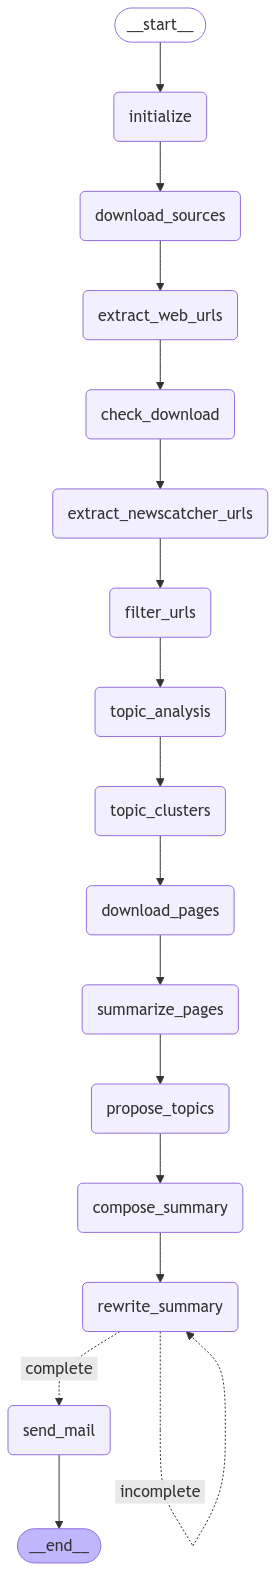

In [35]:
do_download = False
before_date = ''
# before_date = '2024-11-11 017:00:00'
# use everything since this date even if already seen
# like if you want to rerun it for any reason after sqlite updated


def initialize_agent(do_download, before_date):
    # initial state
    state = AgentState({
        'AIdf': [{}],
        'before_date': before_date,
        'do_download': do_download,
        'sources': {},
        'sources_reverse': {},
        'bullets': '',
        'summary': '',
        'cluster_topics': [],
        'topics_str': '',
        'n_edits': 0,
        'edit_complete': False,
    })
    thread_id = uuid.uuid4().hex
    log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}"
        )
    return state, Agent(state), thread_id


state, lg_agent, thread_id = initialize_agent(do_download, before_date)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

# Instantiate agent and run LangGraph workflow graph end to end

2024-11-24 07:08:37,244 - AInewsbot - INFO - Initializing with before_date=2024-11-23 12:00:00, do_download=True, thread_id=f129c36c1b794956a6dfa8c423aa3771


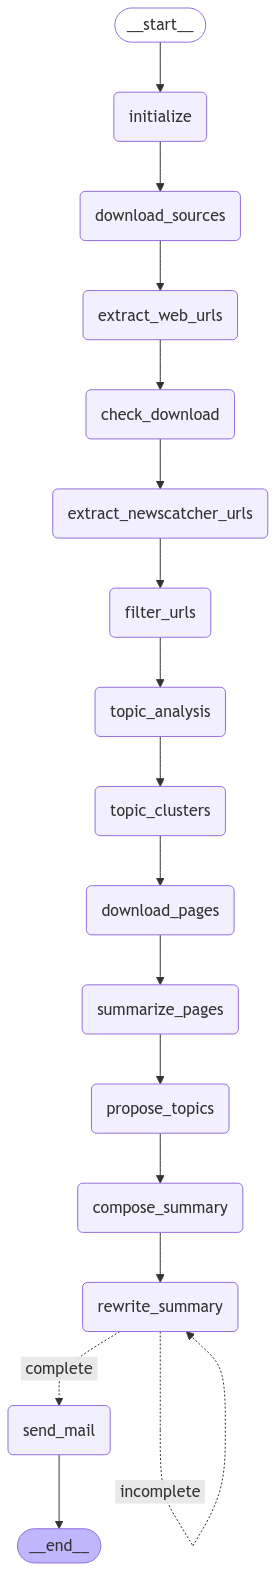

In [36]:
# langgraph runner does other stuff implicitly like checkpoint state in sqlite
do_download = True
before_date = ''
before_date = "2024-11-23 12:00:00"

state, lg_agent, thread_id = initialize_agent(do_download, before_date)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [37]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(state, config)


2024-11-24 07:08:38,325 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2024-11-24 07:08:38,325 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-11-24 07:08:38,326 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-11-24 07:08:38,326 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-11-24 07:08:38,326 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-11-24 07:08:38,326 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-11-24 07:08:38,326 - AInewsbot - INFO - 

'src'
'src'


2024-11-24 07:08:38,554 - AInewsbot - INFO - Saving HTML files using 4 browsers
2024-11-24 07:08:38,571 - AInewsbot - INFO - get_driver - 99139 Initializing webdriver
2024-11-24 07:08:38,573 - AInewsbot - INFO - get_driver - 99139 Initializing webdriver
2024-11-24 07:08:38,573 - AInewsbot - INFO - get_driver - 99139 Initializing webdriver
2024-11-24 07:08:38,574 - AInewsbot - INFO - get_driver - 99139 Initializing webdriver
2024-11-24 07:08:58,026 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-24 07:08:58,026 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-24 07:08:58,026 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-24 07:08:58,027 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-24 07:08:58,028 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-11-24 07:08:58,028 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-11-24 07:08:58,028 - AInewsbot - INFO -

2024-11-24 07:10:25,077 - AInewsbot - INFO - get_files(HackerNoon) - Saving HackerNoon (11_24_2024 07_10_25 AM).html as utf-8
2024-11-24 07:10:25,091 - AInewsbot - INFO - Processing Techmeme
2024-11-24 07:10:25,103 - AInewsbot - INFO - get_files(Techmeme) - starting get_files https://www.techmeme.com/river
2024-11-24 07:10:34,582 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

2024-11-24 07:10:34,583 - AInewsbot - INFO - get_files(New York Times Technology) - Saving New York Times Technology (11_24_2024 0

2024-11-24 07:11:36,439 - AInewsbot - INFO - Downloaded FT Tech to htmldata/FT Technology (11_24_2024 07_10_14 AM).html
2024-11-24 07:11:36,439 - AInewsbot - INFO - Downloaded HackerNoon to htmldata/HackerNoon (11_24_2024 07_10_25 AM).html
2024-11-24 07:11:36,439 - AInewsbot - INFO - Downloaded Techmeme to htmldata/Techmeme (11_24_2024 07_10_36 AM).html
2024-11-24 07:11:36,439 - AInewsbot - INFO - Downloaded The Verge to htmldata/The Verge AI (11_24_2024 07_10_47 AM).html
2024-11-24 07:11:36,439 - AInewsbot - INFO - Downloaded WSJ Tech to htmldata/WSJ Technology (11_24_2024 07_10_58 AM).html
2024-11-24 07:11:36,440 - AInewsbot - INFO - Downloaded Bloomberg Tech to htmldata/Bloomberg Technology (11_24_2024 07_10_12 AM).html
2024-11-24 07:11:36,440 - AInewsbot - INFO - Downloaded Hacker News to htmldata/Hacker News Page 1 (11_24_2024 07_10_23 AM).html
2024-11-24 07:11:36,440 - AInewsbot - INFO - Downloaded Reddit to htmldata/Reddit multiple subreddits (11_24_2024 07_10_56 AM).html
2024-1

'src'


2024-11-24 07:11:36,697 - AInewsbot - INFO - parse_file - found 261 raw links
2024-11-24 07:11:36,701 - AInewsbot - INFO - parse_file - found 22 filtered links
2024-11-24 07:11:36,701 - AInewsbot - INFO - 22 links found
2024-11-24 07:11:36,701 - AInewsbot - INFO - HackerNoon -> htmldata/HackerNoon (11_24_2024 07_10_25 AM).html
2024-11-24 07:11:36,754 - AInewsbot - INFO - parse_file - found 597 raw links
2024-11-24 07:11:36,766 - AInewsbot - INFO - parse_file - found 97 filtered links
2024-11-24 07:11:36,766 - AInewsbot - INFO - 97 links found
2024-11-24 07:11:36,766 - AInewsbot - INFO - NYT Tech -> htmldata/New York Times Technology (11_24_2024 07_10_34 AM).html
2024-11-24 07:11:36,776 - AInewsbot - INFO - parse_file - found 78 raw links
2024-11-24 07:11:36,778 - AInewsbot - INFO - parse_file - found 18 filtered links
2024-11-24 07:11:36,778 - AInewsbot - INFO - 18 links found
2024-11-24 07:11:36,778 - AInewsbot - INFO - Reddit -> htmldata/Reddit multiple subreddits (11_24_2024 07_10_5

,id
src,
Ars Technica,27
Bloomberg Tech,13
Business Insider,51
FT Tech,65
Feedly AI,37
Hacker News,26
Hacker News 2,21
HackerNoon,97
NYT Tech,17


2024-11-24 07:11:37,369 - AInewsbot - INFO - check_downloads passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,27
Bloomberg Tech,13
Business Insider,51
FT Tech,65
Feedly AI,37
Hacker News,26
Hacker News 2,21
HackerNoon,97
NYT Tech,17


2024-11-24 07:11:37,373 - AInewsbot - INFO - Fetching top 100 stories matching Artificial Intelligence from Newscatcher


,id
src,
Ars Technica,27
Bloomberg Tech,13
Business Insider,51
FT Tech,65
Feedly AI,37
Hacker News,26
Hacker News 2,21
HackerNoon,97
NYT Tech,17


2024-11-24 07:11:37,919 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2024-11-23 12:00:00'
2024-11-24 07:11:38,676 - AInewsbot - INFO - URLs in orig_df: 949
2024-11-24 07:11:38,679 - AInewsbot - INFO - Existing URLs in DB: 185120
2024-11-24 07:11:38,720 - AInewsbot - INFO - New URLs in df filtered by URL: 238
2024-11-24 07:11:38,833 - AInewsbot - INFO - Existing src+title: 6
2024-11-24 07:11:38,834 - AInewsbot - INFO - New URLs in df filtered by src+title: 232
2024-11-24 07:11:38,847 - AInewsbot - INFO - Found 226 unique new headlines
2024-11-24 07:11:39,015 - AInewsbot - INFO - Applying prompt to 5 pages using gpt-4o-mini
2024-11-24 07:11:39,017 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:11:39,018 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:11:39,019 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:11:39,019 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:11:39,019 - AInewsbot - INFO - sent 26 items 
2024-11-24 07:11:41,044 - AInewsbot - IN

,id
src,
Business Insider,1
Feedly AI,29
HackerNoon,1
NYT Tech,1
Newscatcher,35
Reddit,1
Techmeme,2
The Register,3
VentureBeat,1


2024-11-24 07:11:42,449 - AInewsbot - INFO - start free-form topic extraction
2024-11-24 07:11:42,450 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:11:42,450 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:11:42,451 - AInewsbot - INFO - sent 25 items 
2024-11-24 07:11:46,055 - AInewsbot - INFO - got dict with 25 items 
2024-11-24 07:11:50,381 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:11:50,383 - AInewsbot - INFO - Processed 75 responses.
2024-11-24 07:11:50,385 - AInewsbot - INFO - 75 free-form topics extracted
2024-11-24 07:11:50,387 - AInewsbot - INFO - ['ai stocks', 'investment', 'finance', 'machine learning', 'stocks', 'creativity', 'education', 'fifa world cup', 'arlington', 'openai', 'court case', 'microsoft', 'ai chips', 'advertising', 'generative ai', 'nvidia', 'data centers', 'innovation', 'criticism', 'chatgpt', 'art', 'eric schmidt', 'health', 'llms', 'thanksgiving', 'work', 'productivity', 'google', 'music', 'stock market

2024-11-24 07:12:38,834 - AInewsbot - INFO - sent 25 items 
2024-11-24 07:12:41,072 - AInewsbot - INFO - got dict with 25 items 
2024-11-24 07:12:42,264 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:12:42,266 - AInewsbot - INFO - Processed 75 responses.
2024-11-24 07:12:42,267 - AInewsbot - INFO - Computer Vision, topic 16 of 100
2024-11-24 07:12:42,268 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:12:42,268 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:12:42,270 - AInewsbot - INFO - sent 25 items 
2024-11-24 07:12:44,199 - AInewsbot - INFO - got dict with 25 items 
2024-11-24 07:12:45,535 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:12:45,538 - AInewsbot - INFO - Processed 75 responses.
2024-11-24 07:12:45,539 - AInewsbot - INFO - Consciousness, topic 17 of 100
2024-11-24 07:12:45,539 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:12:45,539 - AInewsbot - INFO - sent 50 items 
2024-11-24 0

2024-11-24 07:13:38,421 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:13:38,422 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:13:38,424 - AInewsbot - INFO - sent 25 items 
2024-11-24 07:13:40,456 - AInewsbot - INFO - got dict with 25 items 
2024-11-24 07:13:42,002 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:13:42,004 - AInewsbot - INFO - Processed 75 responses.
2024-11-24 07:13:42,005 - AInewsbot - INFO - Finance, topic 33 of 100
2024-11-24 07:13:42,006 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:13:42,007 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:13:42,008 - AInewsbot - INFO - sent 25 items 
2024-11-24 07:13:44,151 - AInewsbot - INFO - got dict with 25 items 
2024-11-24 07:13:45,281 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:13:45,283 - AInewsbot - INFO - Processed 75 responses.
2024-11-24 07:13:45,284 - AInewsbot - INFO - Fintech, topic 34 of 100
2024-11-24 07:13:45,285 - 

2024-11-24 07:14:37,709 - AInewsbot - INFO - Intellectual Property, topic 49 of 100
2024-11-24 07:14:37,710 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:14:37,711 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:14:37,711 - AInewsbot - INFO - sent 25 items 
2024-11-24 07:14:39,708 - AInewsbot - INFO - got dict with 25 items 
2024-11-24 07:14:41,508 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:14:41,509 - AInewsbot - INFO - Processed 75 responses.
2024-11-24 07:14:41,509 - AInewsbot - INFO - Internet of Things, topic 50 of 100
2024-11-24 07:14:41,509 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:14:41,510 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:14:41,510 - AInewsbot - INFO - sent 25 items 
2024-11-24 07:14:43,291 - AInewsbot - INFO - got dict with 25 items 
2024-11-24 07:14:44,779 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:14:44,780 - AInewsbot - INFO - Processed 75 responses.
2

2024-11-24 07:15:36,083 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:15:36,085 - AInewsbot - INFO - Processed 75 responses.
2024-11-24 07:15:36,085 - AInewsbot - INFO - Policy and regulation, topic 66 of 100
2024-11-24 07:15:36,087 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:15:36,088 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:15:36,089 - AInewsbot - INFO - sent 25 items 
2024-11-24 07:15:38,727 - AInewsbot - INFO - got dict with 25 items 
2024-11-24 07:15:39,765 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:15:39,766 - AInewsbot - INFO - Processed 75 responses.
2024-11-24 07:15:39,767 - AInewsbot - INFO - Politics, topic 67 of 100
2024-11-24 07:15:39,767 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:15:39,769 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:15:39,771 - AInewsbot - INFO - sent 25 items 
2024-11-24 07:15:42,120 - AInewsbot - INFO - got dict with 25 items 
2024-11-24 

2024-11-24 07:16:32,793 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:16:32,793 - AInewsbot - INFO - sent 25 items 
2024-11-24 07:16:34,857 - AInewsbot - INFO - got dict with 25 items 
2024-11-24 07:16:36,027 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:16:36,028 - AInewsbot - INFO - Processed 75 responses.
2024-11-24 07:16:36,028 - AInewsbot - INFO - Smart grid, topic 83 of 100
2024-11-24 07:16:36,028 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:16:36,029 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:16:36,029 - AInewsbot - INFO - sent 25 items 
2024-11-24 07:16:38,442 - AInewsbot - INFO - got dict with 25 items 
2024-11-24 07:16:39,056 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:16:39,057 - AInewsbot - INFO - Processed 75 responses.
2024-11-24 07:16:39,057 - AInewsbot - INFO - Society & Culture, topic 84 of 100
2024-11-24 07:16:39,057 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07

2024-11-24 07:17:31,841 - AInewsbot - INFO - Virtual & Augmented Reality, topic 99 of 100
2024-11-24 07:17:31,842 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:17:31,842 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:17:31,843 - AInewsbot - INFO - sent 25 items 
2024-11-24 07:17:33,739 - AInewsbot - INFO - got dict with 25 items 
2024-11-24 07:17:35,203 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:17:35,205 - AInewsbot - INFO - Processed 75 responses.
2024-11-24 07:17:35,206 - AInewsbot - INFO - Virtual Assistants, topic 100 of 100
2024-11-24 07:17:35,207 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:17:35,207 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:17:35,208 - AInewsbot - INFO - sent 25 items 
2024-11-24 07:17:37,939 - AInewsbot - INFO - got dict with 25 items 
2024-11-24 07:17:38,951 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:17:38,954 - AInewsbot - INFO - Processed 75 respo

,id
src,
Business Insider,1
Feedly AI,29
HackerNoon,1
NYT Tech,1
Newscatcher,35
Reddit,1
Techmeme,2
The Register,3
VentureBeat,1


2024-11-24 07:17:38,968 - AInewsbot - INFO - Fetching embeddings for 75 headlines
2024-11-24 07:17:39,945 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-11-24 07:17:40,098 - AInewsbot - INFO - Sort with nearest_neighbor_sort sort
2024-11-24 07:17:40,115 - AInewsbot - INFO - Load umap dimensionality reduction model
2024-11-24 07:17:41,730 - AInewsbot - INFO - Perform dimensionality reduction
2024-11-24 07:17:43,386 - AInewsbot - INFO - Cluster with DBSCAN


,id,title_topic_str
0,0,"AI technology coming to Arlington intersections ahead of 2026 FIFA World Cup (Topics: Arlington, Fifa World Cup, Gen AI, Intersections, Sports)"
1,1,"AI technology coming to Arlington ahead of 2026 FIFA World Cup (Topics: 2026, Arlington, Fifa World Cup, Gen AI, Sports)"
2,2,"How AI is reshaping the data-intensive field of Grand Prix racing, including helping design cars, setting F1's technical regulations, and shaping race strategy (James Allen/Financial Times) (Topics: Art & Design, Car Design, Gen AI, Grand Prix Racing, Hardware, Policy And Regulation, Safety And Alignment, Science, Sports, Strategy, Transportation)"


2024-11-24 07:17:44,185 - AInewsbot - INFO - {'topic_title': 'AI in Sports and Transportation'}
2024-11-24 07:17:44,187 - AInewsbot - INFO - I dub this cluster: AI in Sports and Transportation


,id,title_topic_str
3,3,"Missed Out on Investing in Nvidia? Here's 1 Artificial Intelligence (AI) Chip Stock to Buy on the Dip (Topics: Chip Stocks, Deals, Economics, Finance, Gen AI, Hardware, Investment, Nvidia, Opinion, Products, Science, Semiconductor Chips, Stocks)"
4,4,"Here Are My Top Artificial Intelligence (AI) Stocks to Buy Right Now (Hint: Not Nvidia) (Topics: Deals, Economics, Finance, Gen AI, Hardware, Investment, Nvidia, Opinion, Products, Science, Stocks)"
5,5,"Billionaire Israel Englander Is Selling Nvidia and Buying These Other Artificial Intelligence (AI) Stocks Instead (Topics: AI Stocks, Deals, Economics, Finance, Gen AI, Hardware, Investment, Israel Englander, Nvidia, Products, Science, Stocks)"


2024-11-24 07:17:44,642 - AInewsbot - INFO - {'topic_title': 'Artificial Intelligence Investment Opportunities'}
2024-11-24 07:17:44,642 - AInewsbot - INFO - I dub this cluster: Artificial Intelligence Investment Opportunities


,id,title_topic_str
6,6,"I asked ChatGPT to plan my Thanksgiving menu. Here's how it did (Topics: Chatbots, Chatgpt, Code Assistants, Cooking, Food & Drink, Gen AI, Language Models, Menu Planning, Review, Society & Culture, Thanksgiving, Virtual Assistants)"
7,7,"Discover the Hidden Powers of ChatGPT You Never Knew Existed (Topics: Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Gen AI, Hidden Features, Innovation, Language Models, Opinion, Retrieval Augmented Generation, Virtual Assistants)"
8,8,"How to Own ChatGPT, Gemini, Midjourney, and More for Life (Topics: Chatbots, Chatgpt, Code Assistants, Gemini, Gen AI, Language Models, Midjourney, Ownership, Products, Virtual Assistants)"


2024-11-24 07:17:45,209 - AInewsbot - INFO - {'topic_title': 'ChatGPT and Virtual Assistants'}
2024-11-24 07:17:45,209 - AInewsbot - INFO - I dub this cluster: ChatGPT and Virtual Assistants


,id,title_topic_str
9,9,"KeyBanc Raises CrowdStrike Holdings, Inc. (CRWD) Price Target to $395, Highlights Strong Results and AI-Driven Cybersecurity Strength (Topics: Crowdstrike, Cybersecurity, Deals, Economics, Finance, Gen AI, Keybanc, Privacy & Surveillance, Products, Safety And Alignment, Science, Stocks)"
10,10,"Scotiabank Boosts Elastic N.V. (ESTC) Price Target to $135, Citing Strong Performance and AI Growth Potential (Topics: Economics, Elastic N.V., Finance, Gen AI, Price Target, Scotiabank, Stock Market, Stocks)"
11,11,"UBS Starts Celestica Inc. (CLS) at Neutral with $95 Target, Citing Balanced AI Growth Prospects (Topics: Celestica Inc., Economics, Finance, Gen AI, Growth Prospects, Hardware, Investment, Stocks, Ubs)"


2024-11-24 07:17:45,829 - AInewsbot - INFO - {'topic_title': 'AI in Finance and Stock Market'}
2024-11-24 07:17:45,830 - AInewsbot - INFO - I dub this cluster: AI in Finance and Stock Market
2024-11-24 07:17:45,835 - AInewsbot - INFO - ['AI in Sports and Transportation', 'Artificial Intelligence Investment Opportunities', 'ChatGPT and Virtual Assistants', 'AI in Finance and Stock Market']


AI in Sports and Transportation

Artificial Intelligence Investment Opportunities

ChatGPT and Virtual Assistants

AI in Finance and Stock Market

2024-11-24 07:17:45,858 - AInewsbot - INFO - Queuing URLs for scraping
2024-11-24 07:17:45,860 - AInewsbot - INFO - fetching 75 pages using 4 browsers
2024-11-24 07:17:45,860 - AInewsbot - INFO - get_driver - 99139 Initializing webdriver
2024-11-24 07:17:45,861 - AInewsbot - INFO - get_driver - 99139 Initializing webdriver
2024-11-24 07:17:45,861 - AInewsbot - INFO - get_driver - 99139 Initializing webdriver
2024-11-24 07:17:45,862 - AInewsbot - INFO - get_driver - 99139 Initializing webdriver
2024-11-24 07:18:05,025 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-24 07:18:05,025 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-24 07:18:05,026 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-11-24 07:18:05,026 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-11-24 07:18:05,053 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-24 07:18:05,055 - AInewsbot - INFO - get_driver - Ini

2024-11-24 07:19:18,619 - AInewsbot - INFO - get_url(How to Own ChatGPT, Gemini, Midjourney, and More for Life) - Saving How_to_Own_ChatGPT__Gemini__Midjourney__and_More_for_Life.html as utf-8
2024-11-24 07:19:18,621 - AInewsbot - INFO - Processing page 12: https://www.marktechpost.com/2024/11/23/missingness-aware-causal-concept-explainer-an-elegant-explanation-by-researchers-to-solve-causal-effect-limitations-in-black-box-interpretability/
2024-11-24 07:19:18,622 - AInewsbot - INFO - get_url(https://www.marktechpost.com/2024/11/23/missingness-aware-causal-concept-explainer-an-elegant-explanation-by-researchers-to-solve-causal-effect-limitations-in-black-box-interpretability/) - starting get_url https://www.marktechpost.com/2024/11/23/missingness-aware-causal-concept-explainer-an-elegant-explanation-by-researchers-to-solve-causal-effect-limitations-in-black-box-interpretability/
2024-11-24 07:19:20,214 - AInewsbot - INFO - get_url(KeyBanc Raises CrowdStrike Holdings, Inc. (CRWD) Price 

2024-11-24 07:19:27,089 - AInewsbot - INFO - get_url(Barclays downgrades Baidu on ad pressure from generative AI) - Saving Barclays_downgrades_Baidu_on_ad_pressure_from_generative_AI.html as utf-8
2024-11-24 07:19:27,091 - AInewsbot - INFO - Processing page 24: https://www.geeky-gadgets.com/future-of-ai-with-self-evolving-llms/
2024-11-24 07:19:27,091 - AInewsbot - INFO - get_url(https://www.geeky-gadgets.com/future-of-ai-with-self-evolving-llms/) - starting get_url https://www.geeky-gadgets.com/future-of-ai-with-self-evolving-llms/
2024-11-24 07:19:27,959 - AInewsbot - INFO - get_url(How Self-Evolving LLMs Could Change Everything in AI) - Saving How_Self-Evolving_LLMs_Could_Change_Everything_in_AI.html as utf-8
2024-11-24 07:19:27,961 - AInewsbot - INFO - Processing page 25: https://www.benzinga.com/pressreleases/24/11/g42151800/webroot-warns-shoppers-ai-convenience-comes-with-cybercrime-risk-this-holiday-season
2024-11-24 07:19:27,965 - AInewsbot - INFO - get_url(https://www.benzinga

2024-11-24 07:19:33,727 - AInewsbot - INFO - Processing page 36: https://venturebeat.com/ai/getting-started-with-ai-agents-part-1-capturing-processes-roles-and-connections/
2024-11-24 07:19:33,727 - AInewsbot - INFO - get_url(https://venturebeat.com/ai/getting-started-with-ai-agents-part-1-capturing-processes-roles-and-connections/) - starting get_url https://venturebeat.com/ai/getting-started-with-ai-agents-part-1-capturing-processes-roles-and-connections/
2024-11-24 07:19:34,368 - AInewsbot - INFO - get_url(Data centers powering artificial intelligence could use more electricity than entire cities) - Saving Data_centers_powering_artificial_intelligence_could_use_more_electricity_than_entire_cities.html as utf-8
2024-11-24 07:19:34,408 - AInewsbot - INFO - Processing page 37: https://finance.yahoo.com/news/jim-cramer-doubles-down-nvidia-130039306.html
2024-11-24 07:19:34,410 - AInewsbot - INFO - get_url(https://finance.yahoo.com/news/jim-cramer-doubles-down-nvidia-130039306.html) - st

2024-11-24 07:19:45,266 - AInewsbot - INFO - get_url(Church Sets Up AI-Powered Jesus Inside Confessional Booth) - Saving Church_Sets_Up_AI-Powered_Jesus_Inside_Confessional_Booth.html as utf-8
2024-11-24 07:19:45,268 - AInewsbot - INFO - Processing page 49: https://smartasset.com/data-studies0/chat-gpt-survey-financial-advisors
2024-11-24 07:19:45,268 - AInewsbot - INFO - get_url(https://smartasset.com/data-studies0/chat-gpt-survey-financial-advisors) - starting get_url https://smartasset.com/data-studies0/chat-gpt-survey-financial-advisors
2024-11-24 07:19:45,368 - AInewsbot - INFO - get_url(Utilities, regulators, and researchers in six countries say the power demand surge caused by AI and data centers is being met in the near-term by fossil fuels (Reuters)) - Saving Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.html as utf-8
2024-11-24 07:19:45,373 - AInewsbot - I

2024-11-24 07:19:53,308 - AInewsbot - INFO - Processing page 61: https://theintercept.com/2024/11/22/openai-intercept-lawsuit/
2024-11-24 07:19:53,310 - AInewsbot - INFO - get_url(https://theintercept.com/2024/11/22/openai-intercept-lawsuit/) - starting get_url https://theintercept.com/2024/11/22/openai-intercept-lawsuit/
2024-11-24 07:19:55,154 - AInewsbot - INFO - get_url(Should You Buy This Millionaire-Maker AI Stock Instead of Palantir?) - Saving Should_You_Buy_This_Millionaire-Maker_AI_Stock_Instead_of_Palantir.html as utf-8
2024-11-24 07:19:55,167 - AInewsbot - INFO - Processing page 62: https://scmp.com/news/hong-kong/society/article/3287841/nvidia-ceo-vows-keep-china-presence-tony-leung-spills-stardom-secrets-uni-event
2024-11-24 07:19:55,177 - AInewsbot - INFO - get_url(https://scmp.com/news/hong-kong/society/article/3287841/nvidia-ceo-vows-keep-china-presence-tony-leung-spills-stardom-secrets-uni-event) - starting get_url https://scmp.com/news/hong-kong/society/article/328784

2024-11-24 07:20:03,621 - AInewsbot - INFO - get_url(Hugging Face Releases Observers: An Open-Source Python Library that Provides Comprehensive Observability for Generative AI APIs) - Saving Hugging_Face_Releases_Observers__An_Open-Source_Python_Library_that_Provides_Comprehensive_Observability_for_Generative_AI_APIs.html as utf-8
2024-11-24 07:20:03,624 - AInewsbot - INFO - Processing page 73: https://www.fastcompany.com/91233710/ai-filmmakers-new-aesthetic
2024-11-24 07:20:03,625 - AInewsbot - INFO - get_url(https://www.fastcompany.com/91233710/ai-filmmakers-new-aesthetic) - starting get_url https://www.fastcompany.com/91233710/ai-filmmakers-new-aesthetic
2024-11-24 07:20:03,756 - AInewsbot - INFO - get_url(Robot drummer that's faster than humans could help musicians hone their craft) - Saving Robot_drummer_that_s_faster_than_humans_could_help_musicians_hone_their_craft.html as utf-8
2024-11-24 07:20:03,758 - AInewsbot - INFO - Processing page 74: https://www.yahoo.com/news/lawyer-su

AI in Sports and Transportation

Artificial Intelligence Investment Opportunities

ChatGPT and Virtual Assistants

AI in Finance and Stock Market

2024-11-24 07:20:18,948 - AInewsbot - INFO - Starting summarize
2024-11-24 07:20:18,968 - AInewsbot - INFO - fetch_all_summaries - Page title: MSN

2024-11-24 07:20:19,122 - AInewsbot - INFO - fetch_all_summaries - Page title: MSN

2024-11-24 07:20:19,155 - AInewsbot - INFO - fetch_all_summaries - Page title: AI enters the race to reshape life on and off the track
Social card title: AI enters the race to reshape life on and off the track
Social card description: The world’s most technically advanced sport is so data-intensive that humans can no longer manage alone

2024-11-24 07:20:19,276 - AInewsbot - INFO - fetch_all_summaries - Page title: Missed Out on Investing in Nvidia? Here's 1 Artificial Intelligence (AI) Chip Stock to Buy on the Dip
Social card title: Missed Out on Investing in Nvidia? Here's 1 Artificial Intelligence (AI) Chip Stock to Buy on the Dip
Social card description: Applied Materials looks cheap, and it's at the forefront of computing innovation.

2024-11-24 07:20:1

2024-11-24 07:20:20,400 - AInewsbot - INFO - fetch_all_summaries - Page title: AI can't generate compelling reasons to use it for work • The Register
Social card title: AI can't generate compelling reasons to use it for work
Social card description: Our vultures think this tech is interesting but in its 8-bit stage

2024-11-24 07:20:20,465 - AInewsbot - INFO - fetch_all_summaries - Page title: Barclays downgrades Baidu on ad pressure from generative AI
Social card title: Barclays downgrades Baidu on ad pressure from generative AI
Social card description: Barclays downgraded Baidu (BIDU) to Equal Weight from Overweight with a price target of $83, down from $115. The firm says the move to generative artificial intelligence exacerbates the pressure on Baidu’s advertising. Persistently declining ads revenue is also likely to drive the company’s margins lower, the analyst tells investors in a research note. While overall China advertising environment “is not robust by any means amid weak ma

2024-11-24 07:20:21,558 - AInewsbot - INFO - fetch_all_summaries - Page title: Jim Cramer Doubles Down On Nvidia: 'Demand Is Accelerating' As AI Customers 'Have No Choice' But To Buy Its Chips
Social card title: Jim Cramer Doubles Down On Nvidia: 'Demand Is Accelerating' As AI Customers 'Have No Choice' But To Buy Its Chips
Social card description: NVIDIA Corp. (NASDAQ:NVDA) continues to dominate the artificial intelligence landscape, with CNBC’s Jim Cramer and Wall Street analysts reinforcing their bullish outlook following the company’s stellar third-quarter earnings report. What Happened: ...

2024-11-24 07:20:21,621 - AInewsbot - INFO - fetch_all_summaries - Page title: Data-center reliance on fossil fuels may delay clean-energy transition | Reuters
Social card title: Data-center reliance on fossil fuels may delay clean-energy transition
Social card description: A spike in electricity demand from the world's big data providers is raising a worrying possibility for the world's clima

2024-11-24 07:20:22,448 - AInewsbot - INFO - fetch_all_summaries - Page title: Boffins build AI agents that respond like real people • The Register
Social card title: Boffins build AI agents that respond like real people
Social card description: Oh, AI wanna be like you, AI wanna walk like you, talk like you, too

2024-11-24 07:20:22,489 - AInewsbot - INFO - fetch_all_summaries - Page title: Why you're wrong about AI art, according to the Ai-Da robot that just made a $1 million painting | TechRadar
Social card title: Why you're wrong about AI art, according to the Ai-Da robot that just made a $1 million painting
Social card description: The Ai-Da robot and its maker tell us the real meaning of 'AI God'

2024-11-24 07:20:22,532 - AInewsbot - INFO - fetch_all_summaries - Page title: US High School Economics class: AI productivity will be as profound as Adam Smith’s pin factory
Social card title: US High School Economics class: AI productivity will be as profound as Adam Smith’s pin facto

2024-11-24 07:20:23,354 - AInewsbot - INFO - fetch_all_summaries - Page title: Lawyer Submits Anti-AI Document That Appears to Have Been Created Using AI
Social card title: Lawyer Submits Anti-AI Document That Appears to Have Been Created Using AI
Social card description: A lawyer in Minnesota, who claims to be an expert in the field of disinformation, has been accused of using an AI chatbot to draft an affidavit in support of an anti-deepfake law in the state. As the Minnesota Reformer reports, lawyers challenging the law on behalf of far-right YouTuber and Republican state representative […]

2024-11-24 07:20:28,032 - AInewsbot - INFO - Received 75 summaries


[1. AI technology coming to Arlington intersections ahead of 2026 FIFA World Cup - MSN](https://www.msn.com/en-us/news/technology/ai-technology-coming-to-arlington-intersections-ahead-of-2026-fifa-world-cup/ar-AA1uDPfO)  

 AI in Sports and Transportation, Arlington, Fifa World Cup, Gen AI, Intersections, Sports  

- No substantive news content is available. 



[2. AI technology coming to Arlington ahead of 2026 FIFA World Cup - MSN](https://www.msn.com/en-us/news/technology/ai-technology-coming-to-arlington-ahead-of-2026-fifa-world-cup/ar-AA1uDPfO)  

 AI in Sports and Transportation, 2026, Arlington, Fifa World Cup, Gen AI, Sports  

- The content of the text does not contain any substantive news information.
 



[3. How AI is reshaping the data-intensive field of Grand Prix racing, including helping design cars, setting F1's technical regulations, and shaping race strategy (James Allen/Financial Times) - Twitter](https://t.co/vrzvtmCuN6)  

 AI in Sports and Transportation, Art & Design, Car Design, Gen AI, Grand Prix Racing, Hardware, Policy And Regulation, Safety And Alignment, Science, Sports, Strategy, Transportation  

- Formula One is incorporating artificial intelligence to manage the vast amounts of data generated by cars, with predictions that AI could eventually take over car design but will not replace human drivers.
- AI is enhancing F1's technical regulations and helping teams optimize race strategies by processing real-time data, improving simulations, and personalizing fan experiences.
- The Abu Dhabi Autonomous Racing League demonstrates the potential for AI-driven racing, contrasting with F1's reliance on human drivers, as industry experts affirm that AI will augment rather than replace human contribution in racing. 



[4. Missed Out on Investing in Nvidia? Here's 1 Artificial Intelligence (AI) Chip Stock to Buy on the Dip - Yahoo Finance](https://finance.yahoo.com/news/missed-investing-nvidia-heres-1-223000114.html)  

 Artificial Intelligence Investment Opportunities, Chip Stocks, Deals, Economics, Finance, Gen AI, Hardware, Investment, Nvidia, Opinion, Products, Science, Semiconductor Chips, Stocks  

- Nvidia has become the largest company globally, driven significantly by the AI boom, but investors looking for alternatives can consider Applied Materials, which has seen a stock decline this year.
- Applied Materials produces essential semiconductor manufacturing equipment and has strong financials, with \\$7.5 billion in free cash flow over the last year and more than 50% reduction in outstanding shares since 2003.
- Despite a recent drop in revenue from China, Applied Materials is well-positioned for growth in the semiconductor industry, making it a potential buy on the dip due to favorable P/E ratios compared to the S&P 500. 



[5. Here Are My Top Artificial Intelligence (AI) Stocks to Buy Right Now (Hint: Not Nvidia) - Yahoo Finance](https://finance.yahoo.com/news/top-artificial-intelligence-ai-stocks-123300374.html)  

 Artificial Intelligence Investment Opportunities, Deals, Economics, Finance, Gen AI, Hardware, Investment, Nvidia, Opinion, Products, Science, Stocks  

- The article highlights IBM, Micron Technology, and Fiverr International as promising AI stock investments, suggesting they currently represent better value compared to Nvidia.
- IBM is focusing on enterprise AI solutions with secured service contracts worth \\$3 billion; Micron benefits from high demand for memory chips essential for running generative AI systems; Fiverr leverages AI technologies to enhance its freelance services platform.
- The piece cautions that Nvidia's stock may be overvalued, raising the risk of a price correction as it is currently priced for perfection. 



[6. Billionaire Israel Englander Is Selling Nvidia and Buying These Other Artificial Intelligence (AI) Stocks Instead - Yahoo Finance](https://finance.yahoo.com/news/billionaire-israel-englander-selling-nvidia-133000007.html)  

 Artificial Intelligence Investment Opportunities, AI Stocks, Deals, Economics, Finance, Gen AI, Hardware, Investment, Israel Englander, Nvidia, Products, Science, Stocks  

- Billionaire Israel Englander has been selling Nvidia stock over the past four quarters, recently reducing his position by 12.6%.
- Millennium Management has increased its holdings in Microsoft by 51.4%, acquiring 1.6 million shares, highlighting the company's role in the AI revolution and the success of its AI product Copilot.
- Englander has also increased his investment in Meta Platforms, as the company shows potential in integrating AI to enhance engagement and advertising revenue despite facing stiff competition. 



[7. I asked ChatGPT to plan my Thanksgiving menu. Here's how it did - Yahoo](https://www.yahoo.com/news/lifestyle/asked-chatgpt-plan-thanksgiving-menu-170005104.html)  

 ChatGPT and Virtual Assistants, Chatbots, Chatgpt, Code Assistants, Cooking, Food & Drink, Gen AI, Language Models, Menu Planning, Review, Society & Culture, Thanksgiving, Virtual Assistants  

- ChatGPT provided a comprehensive Thanksgiving menu including appetizers like Deviled Eggs, a main dish of Roast Turkey or Butternut Squash Lasagna, and desserts such as Pumpkin Pie.
- The chatbot also suggested classic side dishes and festive drinks, while offering advice for Thanksgiving hosting and decor.
- Overall, the recommendations from ChatGPT were well-received as helpful for creating a Thanksgiving celebration. 



[8. Discover the Hidden Powers of ChatGPT You Never Knew Existed - Geeky Gadgets](https://www.geeky-gadgets.com/chatgpt-advanced-features/)  

 ChatGPT and Virtual Assistants, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Gen AI, Hidden Features, Innovation, Language Models, Opinion, Retrieval Augmented Generation, Virtual Assistants  

- ChatGPT's Canvas Mode allows for real-time document editing and collaboration but has limitations, such as no image support and potential context loss.
- The platform supports versatile file format conversions, enhancing professionalism in documents while advanced prompting techniques and temperature settings can customize output quality.
- DALL-E 3 integration enables high-quality image generation and modification, making it beneficial for visual content creators. 



[9. How to Own ChatGPT, Gemini, Midjourney, and More for Life - PCMag](https://www.pcmag.com/deals/how-to-own-chatgpt-gemini-midjourney-and-more-for-life)  

 ChatGPT and Virtual Assistants, Chatbots, Chatgpt, Code Assistants, Gemini, Gen AI, Language Models, Midjourney, Ownership, Products, Virtual Assistants  

- A new platform called 1minAI combines popular AI tools like ChatGPT and Midjourney into one subscription, eliminating monthly fees.
- Users can access various AI writing tools, image generation, and transcription services for a one-time payment of \\$29.97 until December 1.
- The service offers 1,000,000 monthly credits and daily free credits, allowing for flexible usage across different AI models. 



[10. KeyBanc Raises CrowdStrike Holdings, Inc. (CRWD) Price Target to \\$395, Highlights Strong Results and AI-Driven Cybersecurity Strength - Yahoo Finance](https://finance.yahoo.com/news/keybanc-raises-crowdstrike-holdings-inc-065431629.html)  

 AI in Finance and Stock Market, Crowdstrike, Cybersecurity, Deals, Economics, Finance, Gen AI, Keybanc, Privacy & Surveillance, Products, Safety And Alignment, Science, Stocks  

- KeyBanc raised the price target for CrowdStrike Holdings, Inc. (CRWD) from \\$345 to \\$395, while maintaining an Overweight rating.
- The firm reported strong results, and checks indicated a positive outlook for customer retention amidst muted Q3 security earnings.
- CrowdStrike leverages artificial intelligence for enhanced cybersecurity across endpoints and cloud workloads. 



[11. Scotiabank Boosts Elastic N.V. (ESTC) Price Target to \\$135, Citing Strong Performance and AI Growth Potential - Yahoo Finance](https://uk.finance.yahoo.com/news/scotiabank-boosts-elastic-n-v-065129838.html)  

 AI in Finance and Stock Market, Economics, Elastic N.V., Finance, Gen AI, Price Target, Scotiabank, Stock Market, Stocks  

- Scotiabank increased the price target for Elastic N.V. (ESTC) from \\$92 to \\$135, maintaining an Outperform rating, citing strong performance and potential in the AI sector.
- Elastic N.V. is highlighted as well-positioned to benefit from the growing adoption of generative AI technologies, according to advisory checks by Scotiabank.
- The article also discusses the overall landscape of AI stocks on Wall Street, including a rising interest in AI-specific chip companies like MatX. 



[12. UBS Starts Celestica Inc. (CLS) at Neutral with \\$95 Target, Citing Balanced AI Growth Prospects - Yahoo Finance](https://ca.finance.yahoo.com/news/ubs-starts-celestica-inc-cls-062948111.html)  

 AI in Finance and Stock Market, Celestica Inc., Economics, Finance, Gen AI, Growth Prospects, Hardware, Investment, Stocks, Ubs  

- UBS has initiated coverage of Celestica Inc. (NYSE:CLS) with a Neutral rating and a price target of \\$95, citing balanced AI growth prospects.
- The firm is recognized as a leader in AI infrastructure but faces cyclical demand in the long term, with UBS noting its shares reflect at least 10% growth expectations over the next decade.
- Recent developments in the AI chip sector include MatX's successful funding round, highlighting the growing investor interest in chips designed for generative AI applications. 



[13. Missingness-aware Causal Concept Explainer: An Elegant Explanation by Researchers to Solve Causal Effect Limitations in Black Box Interpretability - MarkTechPost](https://www.marktechpost.com/2024/11/23/missingness-aware-causal-concept-explainer-an-elegant-explanation-by-researchers-to-solve-causal-effect-limitations-in-black-box-interpretability/)  

 Bias And Fairness, Causal Concept, Cognitive Science, Explanation, Interpretability, Research, Safety And Alignment, Science  

- Researchers at the University of Wisconsin-Madison developed the "Missingness-aware Causal Concept Explainer" (MCCE) to address limitations in traditional causal effect estimation methods in machine learning.
- MCCE captures the impact of unobserved concepts by creating pseudo-concepts that are orthogonal to observed data, thus improving the accuracy of causal explanations.
- Experiments with the CEBaB dataset showed that MCCE outperformed existing methods, demonstrating robust performance in contexts where one or more concepts are unobserved. 



[14. Conservationists turn to AI in battle to save red squirrels - Yahoo](https://www.yahoo.com/news/conservationists-turn-ai-battle-save-074215294.html)  

 Climate, Conservation, Environment, Gen AI, Red Squirrels, Safety And Alignment, Science, Sustainability  

- Conservationists are using an AI tool called Squirrel Agent to distinguish between grey and red squirrels with 97% accuracy, controlling access to feeders based on species.
- The initiative aims to counteract the decline of red squirrels, which face threats from grey squirrels carrying a lethal virus and other challenges in mainland England and Wales.
- Future developments may include tracking individual squirrels using their unique whisker patterns, enhancing conservation efforts by providing detailed population data. 



[15. Generative AI Is Helping To Clear Up Brain Fog - Forbes](https://www.forbes.com/sites/lanceeliot/2024/11/24/generative-ai-is-helping-to-clear-up-brain-fog/)  

 Brain Fog, Brain-Computer Interfaces, Cognitive Science, Consciousness, Gen AI, Generative AI, Health, Health & Fitness, Healthcare, Science, Wellness  

- Brain fog is increasingly recognized as a cognitive issue, characterized by difficulties in concentration, memory, and mental clarity, often linked to physical or psychological factors.
- Generative AI can assist in identifying and offering strategies to mitigate brain fog, though it should not be solely relied upon for diagnosis or treatment.
- Engaging interactively with AI may provide personalized advice, but users are cautioned to validate the information and not treat AI as a definitive authority. 



[16. A judge compared OpenAI to a video game company in its court battle with The New York Times - Business Insider](https://www.businessinsider.com/openai-copyright-lawsuit-new-york-times-video-game-company-2024-11)  

 Authors & Writing, Chatbots, Comparison, Court Case, Entertainment, Ethics, Gaming, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Media, New York Times, Open Source, OpenAI, Policy And Regulation, Politics, Tv & Film & Movies  

- The New York Times has sued OpenAI, alleging that it used its articles without permission to train ChatGPT, with the case currently in the discovery phase.
- A judge denied OpenAI's request for information on how the Times utilizes AI, comparing the scenario to a video game manufacturer and copyright holder.
- OpenAI faces multiple copyright lawsuits from various media organizations and authors, including Sarah Silverman, over the unauthorized use of copyrighted materials in its training datasets. 



[17. Around the Globe, Governments Lean into AI - The Atlantic](https://www.theatlantic.com/sponsored/google/governments-ai/3969/)  

 Ethics, Gen AI, Global Trends, Governance, Governments, Policy, Policy And Regulation, Politics  

- Governments worldwide are increasingly implementing AI technologies to improve public services, with notable initiatives in the U.S. and cities like Memphis enhancing operational efficiency.
- Europe is developing strict regulations, such as the EU Artificial Intelligence Act, to ensure safety and privacy in AI applications, while nations like Estonia and Denmark effectively incorporate AI into government operations.
- Africa is rapidly adopting AI, especially in healthcare and urban management, leveraging mobile technology to enhance service delivery despite differing capabilities between urban and rural areas. 



[18. Siri 2.0: Major Upgrades Coming to Apple's Voice Assistant - Geeky Gadgets](https://www.geeky-gadgets.com/siri-2-0-major-upgrades-coming-to-apples-voice-assistant/)  

 Apple, Chatbots, Gen AI, Hardware, Products, Siri, Speech Recognition & Synthesis, Upgrades, Virtual Assistants, Voice Assistant  

- Apple is set to launch Siri 2.0 with iOS 19 in 2025, featuring a large language model (LLM) that enhances Siri's ability to comprehend complex queries and engage in natural conversations.
- The update includes a redesigned user interface for streamlined interactions and introduces onscreen awareness for context-specific suggestions, improving multitasking capabilities.
- New in-app actions will allow Siri to execute tasks fluidly within applications, significantly enhancing user convenience and solidifying Siri's position as a leading voice assistant. 



[19. One thing AI can't generate at the moment  compelling reasons to use it for work - The Register](https://www.theregister.com/2024/11/23/kettle_ai)  

 Gen AI, Jobs & Careerslabor Market, Productivity, Work  

- Current generative AI technology is not providing compelling reasons for businesses to adopt it, leading to concerns about its effectiveness in enhancing worker productivity.  
- Reports suggest that generative chatbots may actually hinder productivity due to a lack of training and user confusion.  
- Despite significant investments, such as Microsoft's \\$10 billion in OpenAI, the sales of expensive AI PCs have been disappointing.   



[20. Barclays downgrades Baidu on ad pressure from generative AI - Yahoo Finance](https://finance.yahoo.com/news/barclays-downgrades-baidu-ad-pressure-113049682.html)  

 Advertising, Baidu, Barclays, China, Economics, Finance, Gen AI, Generative AI, Language Models, Retrieval Augmented Generation, Science, Stocks  

- Barclays downgraded Baidu (BIDU) from Overweight to Equal Weight, reducing its price target from \\$115 to \\$83, citing pressures from generative AI on advertising revenue.
- The firm highlights that Baidu's declining ad revenue is likely to negatively impact its profit margins amidst a weak overall advertising environment in China.
- Baidu, although a leader in generative AI and search, faces challenges due to lower monetization rates of AI-generated search results, which make up about 20% of its search queries. 



[21. KPMG Invests USD 100 Million in Google Cloud Alliance to Accelerate Enterprise AI Adoption - telecomtalk.info](https://telecomtalk.info/kpmg-invests-usd100-million-google-cloud-ai/985289)  

 Deals, Economics, Enterprise AI, Finance, Funding, Gen AI, Google Cloud, Investment, Kpmg, Mergers And Acquisitions, Products, Venture Capital  

- KPMG announced a USD 100 million investment in its alliance with Google Cloud to enhance generative AI, data analytics, and cybersecurity solutions for global enterprises.
- The partnership aims to generate USD 1 billion in growth for KPMG by developing solutions tailored to industries like financial services, healthcare, and consumer retail, leveraging Google Cloud's advanced AI technologies.
- KPMG has experienced a 10x increase in Google Cloud-related bookings and plans to create industry-specific AI agents to improve knowledge assistance and data management for clients. 



[22. Training-Free Guidance (TFG): A Unified Machine Learning Framework Transforming Conditional Generation in Diffusion Models with Enhanced Efficiency and Versatility Across Domains - MarkTechPost](https://www.marktechpost.com/2024/11/23/training-free-guidance-tfg-a-unified-machine-learning-framework-transforming-conditional-generation-in-diffusion-models-with-enhanced-efficiency-and-versatility-across-domains/)  

 Computer Vision, Conditional Generation, Diffusion Models, Efficiency, Gen AI, Language Models, Machine Learning, Reinforcement Learning, Retrieval Augmented Generation, Science, Testing  

- The Training-Free Guidance (TFG) framework enhances the efficiency and versatility of diffusion models in conditional generation without the need for retraining, addressing key challenges in machine learning applications.
- TFG demonstrated an 8.5% average performance improvement over traditional methods across seven diffusion models and 16 tasks, achieving high accuracy in datasets such as CIFAR10 and ImageNet.
- The method integrates advanced techniques like mean and variance guidance, implicit dynamic modeling, and recurrent refinement, allowing for broad applicability and mitigation of dataset biases in multi-condition tasks. 



[23. Amazon Invests USD 4 Billion More in Anthropic, Expands AI Partnership - telecomtalk.info](https://telecomtalk.info/amazon-invests-usd4billion-more-in-anthropic-ai/985293)  

 Amazon, Anthropic, Deals, Economics, Finance, Funding, Gen AI, Investment, Mergers And Acquisitions, Partnership, Products, Science, Stocks, Venture Capital  

- Amazon has invested an additional USD 4 billion in AI startup Anthropic, raising its total investment to USD 8 billion, and designates AWS as Anthropic's primary cloud and training partner.
- The partnership aims to advance AI hardware, specifically through collaboration on AWS's Trainium chips, enhancing computational efficiency for training advanced AI models like Anthropic's Claude.
- Anthropic's AI assistant, Claude, is being leveraged by various organizations via Amazon Bedrock for tasks including drug development and document analysis, significantly improving operational efficiency and reducing costs. 



[24. Twilio (TWLO) Honors AI Innovators: Transforming Customer Engagement with AI and LLMs - Yahoo Finance](https://finance.yahoo.com/news/twilio-twlo-honors-ai-innovators-144834137.html)  

 Chatbots, Customer Engagement, Customer Service, Gen AI, Language Models, Llms, Stocks, Twilio  

- Twilio Inc. (NYSE:TWLO) has recognized 16 startups with the AI Startup Searchlight Awards for effectively using AI and communication tools to enhance customer engagement.
- AI advancements are expected to dominate the stock market trends into 2025, according to an investor note from Blackrock, highlighting both technological growth and regulatory challenges.
- Twilio has been integrating AI into its platform, offering new features to help clients improve customer interactions. 



[25. How Self-Evolving LLMs Could Change Everything in AI - Geeky Gadgets](https://www.geeky-gadgets.com/future-of-ai-with-self-evolving-llms/)  

 Artificial General Intelligence, Cognitive Science, Ethics, Gen AI, Innovation, Language Models, Llms, Retrieval Augmented Generation, Safety And Alignment, Science, Self-Evolving, Singularity  

- Self-evolving large language models (LLMs) can autonomously update their parameters, reducing retraining costs and enhancing efficiency in AI applications.
- These models, valued at \\$2 billion and currently in beta testing, incorporate memory pools to store past interactions, allowing for continuous learning and improved performance.
- Challenges include ensuring safety and security to prevent the acquisition of harmful information, as developers aim to tailor these models for enterprise applications. 



[26. Webroot Warns Shoppers: AI Convenience Comes with Cybercrime Risk This Holiday Season - Benzinga](https://www.benzinga.com/pressreleases/24/11/g42151800/webroot-warns-shoppers-ai-convenience-comes-with-cybercrime-risk-this-holiday-season)  

 AI Doom, Cybercrime, Cybersecurity, Ethics, Gen AI, Holiday Shopping, Legal Issues, Privacy, Privacy & Surveillance, Products, Risk, Safety And Alignment, Scams  

- Webroot warns that while AI enhances holiday shopping, it also increases risks from cybercriminals, with over \\$10 billion lost to fraud in 2023.
- Shoppers are advised to avoid fake AI apps, refrain from saving payment information, and be cautious of suspicious deals to protect their personal data.
- Webroot offers security solutions to safeguard devices and information, encouraging consumers to educate themselves on cybersecurity practices. 



[27. Is Microsoft Corporation (MSFT) AI News Should Pay Attention to? - Yahoo Finance](https://finance.yahoo.com/news/microsoft-corporation-msft-ai-news-143735700.html)  

 Corporate, Economics, Finance, Gen AI, Microsoft, News, Stocks  

- Microsoft Corporation (MSFT) is actively engaged in the AI sector, recently signing a deal with HarperCollins to use nonfiction titles for AI model training.
- According to Blackrock's investor note, AI advancements and regulatory challenges will shape market trends in 2024 and are expected to continue influencing growth into 2025.
- The competitive landscape of AI may diverge between US-focused companies and those with global exposure due to regulatory and geopolitical strains. 



[28. AI Education for Teens: Lifting the Hood on Data and Machine Learning  Communications of the ACM - ACM Communications](https://cacm.acm.org/blogcacm/ai-education-for-teens-lifting-the-hood-on-data-and-machine-learning/)  

 Bias And Fairness, Data, Education, Ethics, Gen AI, Machine Learning, Safety And Alignment, Science, Society & Culture, Teens  

- A new project funded by the National Science Foundation aims to teach AI and machine learning concepts to 13-15 year olds through the context of cybersecurity, focusing on hands-on experiences that demystify machine learning processes.
- The curriculum incorporates topics such as decision trees, overfitting, and adversarial thinking, utilizing the NetsBlox platform to enable young learners to explore and understand data features and model training dynamics.
- Emphasis is placed on understanding bias in machine learning models and encouraging critical thinking about the ethical implications of AI, including how training data can impact decision-making processes. 



[29. Did AI ruin Christmas? Coca-Colas iconic ad criticised - www.thesouthafrican.com](https://www.thesouthafrican.com/news/did-ai-ruin-christmas-coca-colas-iconic-ad-criticised/)  

 Advertising, AI Doom, Art & Design, Bias And Fairness, Christmas, Coca-Cola, Criticism, Entertainment, Ethics, Gen AI, Opinion, Society & Culture, Tv & Film & Movies  

- Coca-Cola's traditional Christmas ad, featuring the iconic truck and music, has faced criticism this year due to its use of generative AI, with many viewers disapproving of the AI-generated content.
- The company released three versions of the ad, including one with AI-generated visuals, one that mimics real actors, and another focused on festive animals, but public reaction has largely been negative.
- In response to the backlash, Coca-Cola defended its approach as a collaboration between human creativity and AI, emphasizing its ongoing innovation in connecting with consumers. 



[30. AI's scientific path to trust - Axios](https://www.axios.com/2024/11/24/artificial-intelligence-science-google-deepmind-trust)  

 Bias And Fairness, Ethics, Gen AI, Safety And Alignment, Science, Trust  

- Top researchers emphasized that scientific advancements using AI, such as new drugs and enhanced disaster forecasting, are crucial for rebuilding public trust in technology while cautioning against rapid implementation without thorough scientific scrutiny.
- Developments in AI, including models predicting DNA changes and mapping human cells, show promise for addressing complex biological questions but highlight concerns regarding reproducibility and understanding of AI capabilities.
- Experts advocate for a strong adherence to the scientific method to mitigate risks and improve the reliability of AI-generated research findings. 



[31. Nows your chance to try Microsofts controversial Windows Recall ... maybeLike its AI, this automated screenshotter and logger is a feature not exactly everyone wanted - The Register](https://www.theregister.com/2024/11/22/microsoft_recall_release/)  

 Microsoft, Privacy, Privacy & Surveillance, Products, Screenshotter, Windows Recall  

- Microsoft has launched a limited public preview of its controversial Windows Recall system, which captures and stores screenshots of user activity for future retrieval, amid concerns over privacy and security.  
- The application, initially criticized for its potential to capture sensitive information, now includes security improvements, such as encryption and the ability to exclude certain applications from being recorded.  
- Windows Recall will initially be available only on Qualcomm Snapdragon-powered Copilot+ PCs, with plans to expand support to other hardware platforms. 



[32. The Many Ways WSJ Readers Use AI in Their Everyday Lives - The Wall Street Journal](https://www.wsj.com/tech/ai/using-ai-readers-tips-8462bb35)  

 Everyday Life, Gen AI, Reader Experiences, Wsj  

- WSJ readers report using AI tools like ChatGPT for various tasks in their daily lives, including work and personal activities.
- Applications range from choosing entertainment to completing tedious work tasks and even home improvement projects.
- The interest in generative AI signifies its growing role in both professional and personal contexts. 



[33. 32.4% of Warren Buffett's \\$292 Billion Portfolio Is Invested in 4 Artificial Intelligence (AI) Stocks - MSN](https://www.msn.com/en-us/money/markets/32-4-of-warren-buffett-s-292-billion-portfolio-is-invested-in-4-artificial-intelligence-ai-stocks/ar-AA1uC1DW)  

 AI Stocks, Economics, Finance, Gen AI, Investment, Portfolio, Science, Stocks, Warren Buffett  

- No substantive news content available. 



[34. Data centers powering artificial intelligence could use more electricity than entire cities - Reddit](https://www.reddit.com/r/technology/comments/1gxzmhr/data_centers_powering_artificial_intelligence/)  

 Climate, Data Centers, Economics, Electricity, Energy, Ethics, Gen AI, Hardware, Infrastructure, Safety And Alignment, Science, Sustainability  

- Data centers powering artificial intelligence may consume more electricity than entire cities, raising concerns about their environmental impact.
- The processing of large amounts of data by AI models contributes to surveillance and data permanence, prompting worries about privacy and data usage by corporations.
- Major companies, like Amazon and Microsoft, are investing in nuclear power to support the substantial energy demands of AI infrastructure. 



[35. Vertiv Holdings Co. (VRT) Leverages AI for Future Growth: Key Investor Insights - Yahoo Finance](https://uk.finance.yahoo.com/news/vertiv-holdings-co-vrt-leverages-141553511.html)  

 Economics, Finance, Gen AI, Growth, Investment Insights, Stocks, Vertiv Holdings Co.  

- Vertiv Holdings Co. is focusing on leveraging AI for growth as the industry prepares for large-scale technology deployments in 2024.
- Enfabrica, a startup, raised \\$115 million to develop AI chips that can connect significantly more units, enhancing the training of larger AI models.
- OpenAI launched a free training course for teachers to promote efficient and positive use of AI in education, addressing previous concerns about its impact on student work. 



[36. Using MLLMs for Diffusion Synthesis That Synergizes Both Sides: How Is This Possible? - Hacker Noon](https://hackernoon.com/using-mllms-for-diffusion-synthesis-that-synergizes-both-sides-how-is-this-possible)  

 Computer Vision, Diffusion Synthesis, Gen AI, Language Models, Machine Learning, Mllms, Reinforcement Learning, Retrieval Augmented Generation, Science, Testing  

- The research explores the use of Multimodal Language Models (MLLMs) for synergizing image generation and language comprehension through diffusion synthesis.
- The proposed method leverages MLLMs by querying learned embeddings to enhance image generation, positioning them as a conditioning factor for the synthesis process.
- The study aims to deepen understanding of the potential interplay between multimodal creation and comprehension, addressing gaps in current research. 



[37. Getting started with AI agents (part 1): Capturing processes, roles and connections - VentureBeat](https://venturebeat.com/ai/getting-started-with-ai-agents-part-1-capturing-processes-roles-and-connections/)  

 AI Agents, Code Assistants, Connections, Gen AI, Processes, Roles, Virtual Assistants  

- Understanding AI agents involves distinguishing them from generative AI models and establishing communication roles among multiple agents to enhance productivity and workflows.
- A directory structure for agent networks can be defined using AI tools, ensuring each agent's responsibilities and connections follow a directed acyclic graph (DAG) to prevent system confusion.
- Implementing multi-agent systems can streamline organizational processes, evidenced by scenarios in HR and IT where agents collectively handle complex user inquiries while managing specific departmental needs. 



[38. Jim Cramer Doubles Down On Nvidia: 'Demand Is Accelerating' As AI Customers 'Have No Choice' But To Buy Its Chips - Yahoo Finance](https://finance.yahoo.com/news/jim-cramer-doubles-down-nvidia-130039306.html)  

 Deals, Demand, Economics, Finance, Gen AI, Hardware, Jim Cramer, Nvidia, Opinion, Products, Science, Semiconductor Chips, Stocks  

- Jim Cramer and Wall Street analysts are bullish on Nvidia, citing a significant demand increase for its AI chips, which are deemed essential for major tech companies.
- Nvidia reported a third-quarter revenue of \\$35.1 billion, a 94% year-over-year increase, with data center revenue at \\$30.8 billion, and is projected to generate \\$37.5 billion in fourth-quarter revenue.
- Analysts, including Wedbush's Dan Ives, predict a substantial impact of Nvidia's GPU chips on the tech sector, projecting an \\$8 to \\$10 return for every dollar spent. 



[39. Utilities, regulators, and researchers in six countries say the power demand surge caused by AI and data centers is being met in the near-term by fossil fuels (Reuters) - Reuters](https://www.reuters.com/technology/artificial-intelligence/how-ai-cloud-computing-may-delay-transition-clean-energy-2024-11-21/)  

 AI Doom, Bias And Fairness, Climate, Data Centers, Economics, Energy, Ethics, Fossil Fuels, Gen AI, Governance, Infrastructure, Policy And Regulation, Politics, Power Demand, Safety And Alignment, Science, Sustainability  

- The increasing electricity demand from data centers, driven by artificial intelligence and cloud computing, is leading to a reliance on fossil fuels, potentially hindering the clean-energy transition.
- Utilities in the U.S. and several countries are delaying the retirement of fossil-fuel power plants and building new gas facilities to meet the growing demand from data centers.
- Major tech companies' commitments to renewable energy are often limited, as they source clean power from existing grids, which could displace clean energy availability elsewhere. 



[40. Do You Believe That AI Will Ruin Photography? Do You See It Already Happening? - Fstoppers](https://fstoppers.com/artificial-intelligence/believe-ai-will-ruin-photography-see-it-already-happening-685798)  

 AI Doom, Art, Art & Design, Bias And Fairness, Criticism, Entertainment, Ethics, Gen AI, Opinion, Photography, Society & Culture  

- The rise of generative AI in photography raises concerns about image appropriation, as AI tools resample existing images from photographers' work without consent.
- Renowned wildlife photographer Simon D’Entremont offers insights on the impact of AI on photography, discussing both its challenges and how creatives can protect their work.
- While generative AI may affect audience perception of photography, it is suggested that it will not ruin the art form but rather change its commercial landscape. 



[41. Meet the super users who tap AI to get ahead at work - www.inquirer.com](https://www.inquirer.com/business/ai-artificial-intelligence-chatbots-20241123.html)  

 Code Assistants, Gen AI, Job Automation, Jobs & Careerslabor Market, Productivity, Society & Culture, Super Users, Virtual Assistants, Work  

- A growing number of workers, referred to as "super users," are leveraging AI tools like chatbots to enhance efficiency, productivity, and confidence in their work, with some reporting significant time savings.
- Despite the benefits, users express concerns about privacy, inaccuracies, potential job displacement, and reliance on AI hindering skill development.
- Although only 4% of workers use AI daily, those who do primarily in white-collar jobs find that it fosters creativity and innovation, prompting discussions about the future of autonomous AI in the workplace. 



[42. EY has an AI avatar named eVe that lets job candidates do a pre-interview in the metaverse - Business Insider](https://www.businessinsider.com/ey-ai-avatar-hiring-process-preinterview-job-candidates-metaverse-2024-11)  

 Avatar, Chatbots, Economics, Ethics, Gaming, Gen AI, Interview, Job Automation, Job Candidates, Jobs & Careerslabor Market, Metaverse, Robots, Society & Culture, Virtual & Augmented Reality, Virtual Assistants  

- EY has launched an AI avatar named eVe to assist job candidates with pre-interviews and to answer questions about the hiring process.  
- Candidates can use eVe for personalized preparation and information about the company, including benefits like healthcare and retirement plans.  
- The avatar aims to reduce anxiety by simulating a conversational experience, allowing candidates to engage openly and ask questions they might hesitate to pose to a human interviewer. 



[43. MemoryFormer: A Novel Transformer Architecture for Efficient and Scalable Large Language Models - MarkTechPost](https://www.marktechpost.com/2024/11/23/memoryformer-a-novel-transformer-architecture-for-efficient-and-scalable-large-language-models/)  

 Artificial General Intelligence, Cognitive Science, Gen AI, Language Models, Large Language Models, Memoryformer, Retrieval Augmented Generation, Science, Transformer Architecture, Transformers  

- Researchers have introduced MemoryFormer, a novel transformer architecture that replaces fully-connected layers with Memory Layers, improving computational efficiency for large language models (LLMs).
- MemoryFormer has shown to reduce computational complexity by over 80%, achieving significant performance improvements on NLP benchmarks compared to standard transformers and existing efficient methods.
- The architecture allows for scalability and broader accessibility in deploying LLMs while maintaining or enhancing accuracy across various tasks. 



[44. UnitedHealth Group's (UNH) AI Revolution: Hedge Funds' Top Healthcare Bet - Yahoo Finance](https://ca.finance.yahoo.com/news/unitedhealth-group-unh-ai-revolution-151422273.html)  

 Economics, Finance, Gen AI, Health & Fitness, Healthcare, Hedge Funds, Investment, Stocks, Unitedhealth Group  

- UnitedHealth Group (UNH) is highlighted as a leading healthcare stock among hedge funds, benefiting from a growing healthcare sector projected to grow significantly in the coming years, particularly due to the impact of artificial intelligence (AI).
- The U.S. healthcare spending has increased by 7.5% in 2023, with expectations for AI investments to exceed \\$11 billion in the healthcare industry this year, potentially saving the sector nearly \\$360 billion over the next five years.
- UnitedHealth Group reported a revenue increase of 9.16% for Q3 2024, driven by growth in pharmacy care and technology-driven healthcare services, alongside the introduction of a national gold card scheme to reduce administrative costs. 



[45. AI search results  the good, the bad, and the flexible - Tom's Guide](https://www.tomsguide.com/ai/ai-search-results-the-good-the-bad-and-the-flexible)  

 Bias And Fairness, Ethics, Evaluation, Flexibility, Gen AI, Safety And Alignment, Search Results  

- AI has transformed online search by providing precise, context-aware results but traditional formats remain available for users who prefer them.
- Google’s AI-generated overviews offer quick answers by summarizing information from multiple sources but can sometimes result in inaccuracies; users can use "web-only" view to bypass them.
- Alternative AI search engines like Bing AI and Perplexity offer unique features such as conversational interfaces and reliable sourcing, catering to different user preferences. 



[46. 32k context length text embedding models - blog.voyageai.com](https://blog.voyageai.com/2024/09/18/voyage-3/)  

 Cognitive Science, Context Length, Gen AI, Language Models, Machine Learning, Retrieval Augmented Generation, Science, Text Embedding  

- Voyage AI has announced the release of two new embedding models, voyage-3 and voyage-3-lite, which significantly improve retrieval quality and reduce costs compared to OpenAI's offerings, outperforming OpenAI v3 large by 7.55% and 3.82% respectively.
- Voyage-3 is 2.2x cheaper and features a 3-4x smaller embedding dimension than OpenAI v3 large, while voyage-3-lite costs 6.5x less and outperforms OpenAI v3 small.
- Both models support a 32K-token context length, four times more than that of OpenAI's models. 



[47. Church Sets Up AI-Powered Jesus Inside Confessional Booth - Futurism](https://futurism.com/the-byte/ai-powered-jesus-confession-booth)  

 Chatbots, Confessional Booth, Consciousness, Ethics, Gen AI, Innovation, Religion, Society & Culture  

- A church in Lucerne has installed an AI program in a confessional booth, allowing visitors to engage in conversation with an "AI Jesus" trained on theological texts.
- Over a two-month test period, more than 1,000 people interacted with the AI, with over two-thirds reporting a "spiritual experience."
- The project's aim is to explore people's reactions to an AI representation of Jesus, although the church does not intend for it to replace traditional confessional practices. 



[48. Hankyung.com introduces: MecKare, Leading the AI-powered Innovation in Health Monitoring Solution - Yahoo Finance](https://finance.yahoo.com/news/hankyung-com-introduces-meckare-leading-130000776.html)  

 Gen AI, Health & Fitness, Health Monitoring, Healthcare, Innovation, Meckare, Products, Safety And Alignment, Science  

- JCF Technology has developed 'MecKare,' a non-contact radar sensor that measures biological signals and connects users to guardians in emergencies, enhancing health monitoring for the elderly.
- The sensor tracks heart rate, respiratory rate, and skin temperature, and can predict falls or emergencies, allowing for proactive responses to safety issues without requiring wearables.
- MecKare is currently used in senior care facilities across several countries and plans to expand its verification studies in the U.S. by 2025. 



[49. ZICC: Internet Experts Pay Attention to the Development of Artificial Intelligence - Yahoo Finance](https://finance.yahoo.com/news/zicc-internet-experts-pay-attention-123900805.html)  

 Development, Gen AI, Zicc  

- Experts at the Wuzhen Summit emphasized the need for proper AI use to maximize its benefits and mitigate negative effects.
- Calls for a global governance system for AI to ensure it serves humanity positively were voiced by various experts, including Latif Ladid.
- Insights were shared on AI's role in healthcare and job creation, with a focus on ensuring safety and preventing misuse. 



[50. Nearly 6 in 10 Advisors Are Interested in Testing Out AI or ChatGPT - SmartAsset - SmartAsset](https://smartasset.com/data-studies0/chat-gpt-survey-financial-advisors)  

 Advisors, Chatbots, Chatgpt, Code Assistants, Economics, Finance, Gen AI, Interest, Jobs & Careerslabor Market, Language Models, Testing, Virtual Assistants  

- The text appears to consist of navigation links and categories related to financial services, rather than substantive news content.
- There is a reference to a "404: This page could not be found," indicating the page does not contain any relevant information.
- No newsworthy content is present in the text provided. 



[51. Will AI Kill Google? - tech.slashdot.org](https://tech.slashdot.org/story/24/11/23/0333202/will-ai-kill-google)  

 AI Doom, Competition, Gen AI, Google, Job Automation, Opinion  

- Experts believe artificial intelligence could significantly change search methods, with predictions that tools like ChatGPT could replace traditional Google searches, as articulated by notable figures like Sam Altman and Bill Gates. 
- In ongoing legal proceedings regarding Google's monopoly, the judge acknowledged that while AI may eventually impact search significantly, that change is not imminent.
- Concerns have been raised about Google’s declining search result quality, as users express frustration over irrelevant search outcomes, often driven by advertising and SEO manipulation. 



[52. One thing AI can't generate at the moment  compelling reasons to use it for workKettleOur vultures think this tech is interesting but in its 8-bit stageAI + ML16 hrs|26 - The Register](https://www.theregister.com/2024/11/23/kettle_ai/)  

 8-Bit, Gen AI, Jobs & Careerslabor Market, Machine Learning  

- AI is currently seen as unconvincing for workplace use, with generative chatbots potentially reducing worker productivity due to lack of effective training.
- Gartner reports that expensive AI PCs are not selling well, highlighting market skepticism about the technology.
- Microsoft's recent push for AI at an event signals their need to justify a significant investment in OpenAI. 



[53. Q&A with Eric Schmidt about the DOJ's proposal for Google to sell Chrome, a new book about AI he co-authored with Craig Mundie and Henry Kissinger, and more (Michel Martin/NPR) - NPR](https://www.npr.org/2024/11/22/nx-s1-5199766/eric-schmidt-interview-the-justice-department-google-ai)  

 Authors & Writing, Books & Publishing, Chrome, Craig Mundie, Doj, Eric Schmidt, Ethics, Gen AI, Google, Governance, Henry Kissinger, History, Intellectual Property, Legal Issues, Policy And Regulation, Politics  

- The DOJ is pushing for Google to sell off its Chrome browser following a ruling that found the company violated antitrust laws by creating a monopoly.
- Former CEO Eric Schmidt argues that the proposed breakup is detrimental to consumers and would harm innovation, suggesting that an integrated system is preferred for user experience.
- Schmidt emphasizes the urgency of addressing regulatory questions surrounding AI, asserting that society must prepare for the rapid advancements and implications of artificial intelligence. 



[54. These artists are rebranding AI image generation with a new name - Fast Company](https://www.fastcompany.com/91228920/ai-photography-rebrands-as-promptography)  

 Art, Art & Design, Computer Vision, Entertainment, Gen AI, Image Generation, Intellectual Property, Rebranding, Society & Culture  

- The term "promptography" is gaining traction among artists to describe the process of creating AI-generated images, emphasizing the role of human input in crafting prompts.
- Boris Eldagsen, who previously rejected a photography award for an AI-generated image, supports the term as it highlights the differences between traditional photography and AI-generated art.
- The shift towards "promptography" aims to elevate the perception of AI image creation as a legitimate art form, although some still view it skeptically. 



[55. We can clone you wholesale: Boffins build ML agents that respond like specific peopleOh, AI wanna be like you, AI wanna walk like you, talk like you, tooAI + ML3 hrs|12 - The Register](https://www.theregister.com/2024/11/24/ai_based_on_people/)  

 Agents, Chatbots, Cloning, Deepfakes, Ethics, Gen AI, Intellectual Property, Job Automation, Language Models, Machine Learning, Music, Privacy, Privacy & Surveillance, Reinforcement Learning, Science, Society & Culture  

- Researchers from Stanford, Northwestern, the University of Washington, and Google DeepMind developed AI models that can emulate the responses of specific individuals, using qualitative interviews as input data.
- Their generative agent architecture successfully simulated over 1,000 individuals, achieving an 85% accuracy rate in replicating responses to social science survey questions after two weeks.
- The study indicates potential applications for creating personalized AI agents that could interact like real people, including services aimed at maintaining connections with loved ones after they pass away. 



[56. Why you're wrong about AI art, according to the Ai-Da robot that just made a \\$1 million painting - TechRadar](https://www.techradar.com/computing/artificial-intelligence/why-youre-wrong-about-ai-art-according-to-the-ai-da-robot-that-just-made-a-usd1-million-painting)  

 AI-Da Robot, Art, Art & Design, Computer Vision, Creativity, Deals, Entertainment, Ethics, Gen AI, Hardware, Intellectual Property, Opinion, Painting, Products, Robots, Society & Culture  

- The Ai-Da robot recently sold a painting at Sotheby's for over \\$1 million, marking it as the first humanoid robot artist to achieve this milestone, which has sparked discussion about the role of AI in art.
- Ai-Da's creator, Aidan Meller, argues that AI art should not be seen as a threat to human artists, but rather as an evolution of contemporary art that prompts debates about creativity and technology.
- The landmark sale indicates a shift in the art world towards accepting AI-generated art, as Meller believes that AI has the potential to contribute meaningfully to artistic expression and societal discussions. 



[57. US High School Economics class: AI productivity will be as profound as Adam Smith's pin factory - Financial Times](https://www.ft.com/content/538a4a1b-51a5-4465-bab0-d7062474bc7e)  

 Adam Smith, Economics, Education, Gen AI, History, Job Automation, Jobs & Careerslabor Market, Opinion, Productivity  

- The article compares the productivity impact of AI technology to Adam Smith’s theory of the division of labor in his pin factory, suggesting that AI will significantly enhance economic growth and innovation.
- It discusses how advanced technologies like AI and digital twins are transforming modern industries, creating new job opportunities and changing the labor market.
- The key question posed is how Adam Smith’s economic principles continue to influence contemporary economics and the integration of new technologies in free markets. 



[58. Game-changing AI tools that revolutionized business productivity in 2024 - GeekSided](https://geeksided.com/game-changing-ai-tools-that-revolutionized-business-productivity-in-2024)  

 2024, Business Productivity, Economics, Gen AI, Innovation, Tools  

- Several AI-powered tools significantly enhanced business productivity in 2024, including ChatGPT for Business, GrammarlyGO, and Salesforce Einstein.
- Noteworthy tools like Notion AI and Trello AI improved workflow management and team collaboration, while Tableau with AI enabled faster data-driven decision-making.
- Zoom IQ provided insights and summaries from meetings, helping teams focus on productive discussions and streamline follow-up actions. 



[59. 3 Millionaire-Maker Artificial Intelligence (AI) Stocks - MSN](https://www.msn.com/en-us/money/companies/3-millionaire-maker-artificial-intelligence-ai-stocks/ar-AA1uCe2e)  

 Economics, Finance, Gen AI, Investment, Millionaire, Products, Science, Stocks  

- No substantive news content is present. 



[60. Should You Buy This Millionaire-Maker AI Stock Instead of Palantir? - Yahoo Finance](https://finance.yahoo.com/news/buy-millionaire-maker-ai-stock-101400707.html)  

 Deals, Economics, Finance, Gen AI, Investment, Opinion, Palantir, Products, Review, Stock Market, Stocks  

- AppLovin's stock has surged over 650% in 2023, outperforming Palantir, which grew by 250%. The company's growth is driven by its new AI-powered adtech platform, Axon-2, and substantial revenue gains.
- AppLovin reported a 66% increase in software revenue and a 39% rise in overall revenue, with improvements in profit margins and earnings per share (EPS) surpassing \\$1.
- The company's stock is viewed as attractive compared to Palantir's, trading at a lower price-to-earnings ratio despite its faster revenue growth, suggesting potential for continued investment appeal. 



[61. A look at challenges facing Samsung Executive Chairman Lee Jae-yong, including the company falling behind in the AI chip race and discontent from employees - Twitter](https://t.co/VlBYgTCK9P)  

 AI Chips, Business Challenges, Economics, Gen AI, Hardware, Jobs & Careerslabor Market, Korea, Lee Jae-Yong, Samsung, Semiconductor Chips  

- Lee Jae-yong, Samsung's heir, faces significant challenges, including lagging in the AI chip market and employee unrest, marked by the company's first-ever strike over pay and conditions.
- Samsung's shares have declined over 30% this year, and the company is planning a major management shake-up in its semiconductor divisions to address competition from rivals like SK Hynix.
- Despite Lee's struggles with legal issues and a cautious management style, there are hopes for future growth as Samsung aims to release a new memory chip in 2025 and is investing in research and development. 



[62. A federal court allows a claim by The Intercept that DMCA prevents OpenAI from stripping a story's title or byline but throws out its claims against Microsoft - theintercept.com](https://theintercept.com/2024/11/22/openai-intercept-lawsuit/)  

 Authors & Writing, Bias And Fairness, Chatbots, Court Case, Dmca, Ethics, Gen AI, Governance, Intellectual Property, Journalism, Language Models, Legal Issues, Microsoft, Open Source, OpenAI, Policy And Regulation, Politics  

- A federal court allowed The Intercept’s lawsuit against OpenAI to proceed, focusing on claims regarding the unauthorized use of journalists' work to train ChatGPT.
- The lawsuit cites the Digital Millennium Copyright Act, which The Intercept argues protects against the removal of bylines and titles from their articles.
- The Intercept’s claims against Microsoft were dismissed, and one claim under the DMCA against OpenAI was also rejected. 



[63. China can beat AI rivals with Greater Bay Area edge: Nvidia's Jensen Huang - scmp.com](https://scmp.com/news/hong-kong/society/article/3287841/nvidia-ceo-vows-keep-china-presence-tony-leung-spills-stardom-secrets-uni-event)  

 China, Economics, Gen AI, Greater Bay Area, Hardware, Nvidia, Politics, Science  

- Nvidia CEO Jensen Huang emphasized the potential of China's Greater Bay Area to compete in artificial intelligence, citing its advantages in mechatronics.
- Despite geopolitical tensions, Huang confirmed Nvidia's commitment to maintaining operations in mainland China.
- Huang encouraged students in Hong Kong to consider careers in AI at Nvidia during a ceremony where he received an honorary doctorate. 



[64. Should You Still Learn to Code in an A.I. World? - The New York Times](https://www.nytimes.com/2024/11/24/business/computer-coding-boot-camps.html)  

 Code Assistants, Coding, Education, Gen AI, Job Automation, Jobs & Careerslabor Market, Opinion  

- Coding boot camps, once seen as effective pathways to tech careers, are facing challenges due to a significant drop in job opportunities and the rise of AI tools like ChatGPT that automate coding tasks. 
- Graduates from these programs report difficulty finding jobs, with many employers cutting back on hiring, leading to plummeting placement rates for boot camps.
- Experts suggest that while coding skills remain valuable, aspiring tech workers may need additional skills and long-term education, emphasizing the importance of continuous learning in an evolving job market. 



[65. We can clone you wholesale: Boffins build ML agents that respond like specific people - The Register](https://go.theregister.com/feed/www.theregister.com/2024/11/24/ai_based_on_people/)  

 Agents, Chatbots, Cloning, Deepfakes, Ethics, Gen AI, Intellectual Property, Job Automation, Language Models, Machine Learning, Privacy, Privacy & Surveillance, Reinforcement Learning, Science, Society & Culture  

- Researchers have developed AI models that simulate the behavior and responses of over 1,000 specific individuals using a generative agent architecture, based on qualitative interviews.
- The models successfully matched human responses about 85% of the time when participants were re-surveyed two weeks later.
- This technology raises potential applications for creating custom AI agents to interact with loved ones, even after death. 



[66. Huawei AI chips to power China's next-gen surgery tech for medical breakthroughs - Yahoo](https://www.yahoo.com/news/huawei-ai-chips-power-china-133240667.html)  

 AI Chips, China, Economics, Gen AI, Hardware, Health & Fitness, Healthcare, Huawei, Innovation, Medical Technology, Politics, Products, Safety And Alignment, Science, Semiconductor Chips, Surgery  

- The Centre for Artificial Intelligence and Robotics (CAIR) has launched the Cares Copilot 2.0 AI model, powered by Huawei’s Ascend 910B AI chip, to assist surgeons with tasks like surgical planning and diagnostics.
- CAIR’s collaboration with Huawei aims to advance AI applications in surgery amid US restrictions on high-end chip access, facilitating rapid improvements in AI chip performance.
- Huawei’s AI chips have become the preferred choice for Chinese research institutions, as they fill the gap left by restrictions on Nvidia’s advanced chips, although challenges with production yields remain. 



[67. Bloom Energy Corporation (BE) Powers AI Data Centers: Analyst Insights and Market Outlook - Yahoo Finance](https://finance.yahoo.com/news/bloom-energy-corporation-powers-ai-141821110.html)  

 Bloom Energy, Data Centers, Economics, Energy, Finance, Gen AI, Hardware, Market Outlook, Products, Science, Stocks, Sustainability  

- Bloom Energy Corporation (BE) has been downgraded from Buy to Hold by HSBC analyst Samantha Hoh, with a revised price target of \\$24.50 due to already reflected strong price performance in the stock.
- The company is projected to generate positive free cash flow by 2026, with potential growth linked to increasing demand from AI data centers and necessary capacity expansions at its Fremont facility.
- OpenAI is promoting responsible AI use in education through a new training course for teachers, responding to the high student adoption of its ChatGPT platform. 



[68. I tried to use Apple Intelligence's Image Playground to design a Thanksgiving menu  here's what I learned about the app in the process - Tom's Guide](https://www.tomsguide.com/ai/apple-intelligence/i-tried-to-use-apple-intelligences-image-playground-to-design-a-thanksgiving-menu-heres-what-i-learned-about-the-app-in-the-process)  

 App, Apple Intelligence, Art & Design, Computer Vision, Food & Drink, Gen AI, Image Playground, Products, Review, Society & Culture, Thanksgiving, Virtual Assistants  

- Apple Intelligence's Image Playground is an AI-powered image generation tool introduced in the iOS 18.2 beta, allowing users to create images through text prompts.
- While the app shows potential, it currently has significant limitations, such as a lack of variety in image styles, inability to create group shots, and consistency issues with prompt responses.
- The tool is best suited for making simple avatars or fun cartoons, but lacks the flexibility needed for more complex projects, like designing a themed Thanksgiving menu. 



[69. Hugging Face Releases Observers: An Open-Source Python Library that Provides Comprehensive Observability for Generative AI APIs - MarkTechPost](https://www.marktechpost.com/2024/11/23/hugging-face-releases-observers-an-open-source-python-library-that-provides-comprehensive-observability-for-generative-ai-apis/)  

 Code Assistants, Gen AI, Generative AI, Hugging Face, Language Models, Open Source, Open-Source, Products, Python, Retrieval Augmented Generation, Safety And Alignment, Science  

- Hugging Face has launched Observers, an open-source Python SDK that enables developers to track, analyze, and manage interactions with generative AI models, enhancing transparency in AI observability.
- The tool supports various storage backends, including Hugging Face Datasets, DuckDB, and Argilla, and offers ease of querying with SQL-like interfaces for efficient data exploration.
- Designed for flexibility and user-friendliness, Observers invites contributions from the community, ensuring continuous innovation and adaptation to developers' needs in AI environments. 



[70. AI can be used to create job promotion, not be a job replacement, says AWS vice president - Business Insider](https://www.businessinsider.com/gen-ai-job-promotion-not-replacement-aws-vice-president-2024-11)  

 Aws, Economics, Employment, Ethics, Gen AI, Job Automation, Job Promotion, Jobs & Careerslabor Market  

- Swami Sivasubramanian, VP of AI and Data at AWS, emphasizes that AI is meant to enhance productivity by taking over mundane tasks rather than replacing jobs.
- While there may be short-term job displacement due to increased efficiency from AI, he predicts it will self-correct, with a focus on training and upskilling the workforce.
- Sivasubramanian advocates for human involvement in decision-making, with AI serving as a tool to support and enhance, rather than replace, human judgment and creativity. 



[71. Robotic shorts could help people walk farther. Yes, robotic shorts. - The Washington Post](https://www.washingtonpost.com/wellness/2024/11/23/robotic-shorts-walking-energy)  

 Hardware, Health, Health & Fitness, Healthcare, Job Automation, Mobility, Products, Robotics, Robots, Science, Transportation, Wearable Technology  

- Scientists have developed "soft robotic shorts" called WalkON, which help people expend less energy while walking.
- The shorts are designed to be worn over everyday clothes and assist with hip flexion by adapting to the wearer's movement patterns.
- This innovation aims to improve mobility and independence for older adults and frail individuals. 



[72. Robot drummer that's faster than humans could help musicians hone their craft - Yahoo](https://www.yahoo.com/news/robot-drummer-faster-humans-could-142105886.html)  

 Drummer, Entertainment, Hardware, Job Automation, Music, Musicians, Products, Robot, Robots, Science  

- Researchers from the University of Oslo have developed ZRob, a robotic drummer that plays faster than humans and creates new rhythms, potentially influencing future robotics and musical applications.
- The robot features a flexible grip mimicking human wrist motion, integrates AI for learning movements, and can perform both solo and complex compositions alongside other robots.
- ZRob is designed to inspire musicians rather than replace them, with potential uses for practice and assisting musicians with disabilities. 



[73. Ex-Google CEO Eric Schmidt says AI will 'shape' identity and that 'normal people' are not ready for it - MSN](https://www.msn.com/en-us/money/companies/ex-google-ceo-eric-schmidt-says-ai-will-shape-identity-and-that-normal-people-are-not-ready-for-it/ar-AA1uCFCd)  

 AI Doom, Bias And Fairness, Cognitive Science, Consciousness, Eric Schmidt, Ethics, Gen AI, Identity, Opinion, Safety And Alignment, Society, Society & Culture  

- The text does not contain any substantive news content. 



[74. 5 ways that filmmakers are using AI to create a new aesthetic - Fast Company](https://www.fastcompany.com/91233710/ai-filmmakers-new-aesthetic)  

 Aesthetics, Art & Design, Creativity, Entertainment, Filmmaking, Gen AI, Hollywood, Society & Culture, Tv & Film & Movies  

- Filmmakers are utilizing AI tools to create innovative aesthetics in short films, allowing for diverse storytelling without the need for large budgets.
- Emerging visual trends in AI filmmaking include morphing imagery, surrealism, dark themes, nostalgia, and the representation of new experiences and spaces.
- These artistic expressions reflect contemporary societal issues and the evolving relationship between humans and technology. 



[75. Lawyer Submits Anti-AI Document That Appears to Have Been Created Using AI - Yahoo](https://www.yahoo.com/news/lawyer-submits-anti-ai-document-140007915.html)  

 AI Doom, Anti-AI, Authors & Writing, Bias And Fairness, Chatbots, Code Assistants, Creation, Document, Ethics, Gen AI, Intellectual Property, Language Models, Lawyer, Legal Issues, Policy And Regulation  

- A Minnesota lawyer, Jeff Hancock, accused of using AI to draft an affidavit supporting an anti-deepfake law, is under scrutiny for including references to non-existent studies, indicative of AI-generated text.
- The affidavit was challenged by attorneys for far-right YouTuber and Republican state representative Mary Franson, raising concerns about First Amendment violations related to the proposed law's restrictions on deepfakes in elections.
- This incident adds to a trend of lawyers being caught using AI tools like ChatGPT, following previous cases where attorneys faced consequences for similar actions. 



2024-11-24 07:20:28,169 - AInewsbot - INFO - Sending bullet points email


[AI technology coming to Arlington intersections ahead of 2026 FIFA World Cup - MSN](https://www.msn.com/en-us/news/technology/ai-technology-coming-to-arlington-intersections-ahead-of-2026-fifa-world-cup/ar-AA1uDPfO)

Topics: Arlington, Fifa World Cup, Gen AI, Intersections, Sports 

- No substantive news content is available.



[AI technology coming to Arlington ahead of 2026 FIFA World Cup - MSN](https://www.msn.com/en-us/news/technology/ai-technology-coming-to-arlington-ahead-of-2026-fifa-world-cup/ar-AA1uDPfO)

Topics: 2026, Arlington, Fifa World Cup, Gen AI, Sports 

- The content of the text does not contain any substantive news information.




[How AI is reshaping the data-intensive field of Grand Prix racing, including helping design cars, setting F1's technical regulations, and shaping race strategy (James Allen/Financial Times) - Twitter](https://t.co/vrzvtmCuN6)

Topics: Art & Design, Car Design, Gen AI, Grand Prix Racing, Hardware, Policy And Regulation, Safety And Alignment, Science, Sports, Strategy, Transportation 

- Formula One is incorporating artificial intelligence to manage the vast amounts of data generated by cars, with predictions that AI could eventually take over car design but will not replace human drivers.
- AI is enhancing F1's technical regulations and helping teams optimize race strategies by processing real-time data, improving simulations, and personalizing fan experiences.
- The Abu Dhabi Autonomous Racing League demonstrates the potential for AI-driven racing, contrasting with F1's reliance on human drivers, as industry experts affirm that AI will augment rather than replace human contribution in racing.



[Missed Out on Investing in Nvidia? Here's 1 Artificial Intelligence (AI) Chip Stock to Buy on the Dip - Yahoo Finance](https://finance.yahoo.com/news/missed-investing-nvidia-heres-1-223000114.html)

Topics: Chip Stocks, Deals, Economics, Finance, Gen AI, Hardware, Investment, Nvidia, Opinion, Products, Science, Semiconductor Chips, Stocks 

- Nvidia has become the largest company globally, driven significantly by the AI boom, but investors looking for alternatives can consider Applied Materials, which has seen a stock decline this year.
- Applied Materials produces essential semiconductor manufacturing equipment and has strong financials, with \\$7.5 billion in free cash flow over the last year and more than 50% reduction in outstanding shares since 2003.
- Despite a recent drop in revenue from China, Applied Materials is well-positioned for growth in the semiconductor industry, making it a potential buy on the dip due to favorable P/E ratios compared to the S&P 500.



[Here Are My Top Artificial Intelligence (AI) Stocks to Buy Right Now (Hint: Not Nvidia) - Yahoo Finance](https://finance.yahoo.com/news/top-artificial-intelligence-ai-stocks-123300374.html)

Topics: Deals, Economics, Finance, Gen AI, Hardware, Investment, Nvidia, Opinion, Products, Science, Stocks 

- The article highlights IBM, Micron Technology, and Fiverr International as promising AI stock investments, suggesting they currently represent better value compared to Nvidia.
- IBM is focusing on enterprise AI solutions with secured service contracts worth \\$3 billion; Micron benefits from high demand for memory chips essential for running generative AI systems; Fiverr leverages AI technologies to enhance its freelance services platform.
- The piece cautions that Nvidia's stock may be overvalued, raising the risk of a price correction as it is currently priced for perfection.



[Billionaire Israel Englander Is Selling Nvidia and Buying These Other Artificial Intelligence (AI) Stocks Instead - Yahoo Finance](https://finance.yahoo.com/news/billionaire-israel-englander-selling-nvidia-133000007.html)

Topics: AI Stocks, Deals, Economics, Finance, Gen AI, Hardware, Investment, Israel Englander, Nvidia, Products, Science, Stocks 

- Billionaire Israel Englander has been selling Nvidia stock over the past four quarters, recently reducing his position by 12.6%.
- Millennium Management has increased its holdings in Microsoft by 51.4%, acquiring 1.6 million shares, highlighting the company's role in the AI revolution and the success of its AI product Copilot.
- Englander has also increased his investment in Meta Platforms, as the company shows potential in integrating AI to enhance engagement and advertising revenue despite facing stiff competition.



[I asked ChatGPT to plan my Thanksgiving menu. Here's how it did - Yahoo](https://www.yahoo.com/news/lifestyle/asked-chatgpt-plan-thanksgiving-menu-170005104.html)

Topics: Chatbots, Chatgpt, Code Assistants, Cooking, Food & Drink, Gen AI, Language Models, Menu Planning, Review, Society & Culture, Thanksgiving, Virtual Assistants 

- ChatGPT provided a comprehensive Thanksgiving menu including appetizers like Deviled Eggs, a main dish of Roast Turkey or Butternut Squash Lasagna, and desserts such as Pumpkin Pie.
- The chatbot also suggested classic side dishes and festive drinks, while offering advice for Thanksgiving hosting and decor.
- Overall, the recommendations from ChatGPT were well-received as helpful for creating a Thanksgiving celebration.



[Discover the Hidden Powers of ChatGPT You Never Knew Existed - Geeky Gadgets](https://www.geeky-gadgets.com/chatgpt-advanced-features/)

Topics: Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Gen AI, Hidden Features, Innovation, Language Models, Opinion, Retrieval Augmented Generation, Virtual Assistants 

- ChatGPT's Canvas Mode allows for real-time document editing and collaboration but has limitations, such as no image support and potential context loss.
- The platform supports versatile file format conversions, enhancing professionalism in documents while advanced prompting techniques and temperature settings can customize output quality.
- DALL-E 3 integration enables high-quality image generation and modification, making it beneficial for visual content creators.



[How to Own ChatGPT, Gemini, Midjourney, and More for Life - PCMag](https://www.pcmag.com/deals/how-to-own-chatgpt-gemini-midjourney-and-more-for-life)

Topics: Chatbots, Chatgpt, Code Assistants, Gemini, Gen AI, Language Models, Midjourney, Ownership, Products, Virtual Assistants 

- A new platform called 1minAI combines popular AI tools like ChatGPT and Midjourney into one subscription, eliminating monthly fees.
- Users can access various AI writing tools, image generation, and transcription services for a one-time payment of \\$29.97 until December 1.
- The service offers 1,000,000 monthly credits and daily free credits, allowing for flexible usage across different AI models.



[KeyBanc Raises CrowdStrike Holdings, Inc. (CRWD) Price Target to \\$395, Highlights Strong Results and AI-Driven Cybersecurity Strength - Yahoo Finance](https://finance.yahoo.com/news/keybanc-raises-crowdstrike-holdings-inc-065431629.html)

Topics: Crowdstrike, Cybersecurity, Deals, Economics, Finance, Gen AI, Keybanc, Privacy & Surveillance, Products, Safety And Alignment, Science, Stocks 

- KeyBanc raised the price target for CrowdStrike Holdings, Inc. (CRWD) from \\$345 to \\$395, while maintaining an Overweight rating.
- The firm reported strong results, and checks indicated a positive outlook for customer retention amidst muted Q3 security earnings.
- CrowdStrike leverages artificial intelligence for enhanced cybersecurity across endpoints and cloud workloads.



[Scotiabank Boosts Elastic N.V. (ESTC) Price Target to \\$135, Citing Strong Performance and AI Growth Potential - Yahoo Finance](https://uk.finance.yahoo.com/news/scotiabank-boosts-elastic-n-v-065129838.html)

Topics: Economics, Elastic N.V., Finance, Gen AI, Price Target, Scotiabank, Stock Market, Stocks 

- Scotiabank increased the price target for Elastic N.V. (ESTC) from \\$92 to \\$135, maintaining an Outperform rating, citing strong performance and potential in the AI sector.
- Elastic N.V. is highlighted as well-positioned to benefit from the growing adoption of generative AI technologies, according to advisory checks by Scotiabank.
- The article also discusses the overall landscape of AI stocks on Wall Street, including a rising interest in AI-specific chip companies like MatX.



[UBS Starts Celestica Inc. (CLS) at Neutral with \\$95 Target, Citing Balanced AI Growth Prospects - Yahoo Finance](https://ca.finance.yahoo.com/news/ubs-starts-celestica-inc-cls-062948111.html)

Topics: Celestica Inc., Economics, Finance, Gen AI, Growth Prospects, Hardware, Investment, Stocks, Ubs 

- UBS has initiated coverage of Celestica Inc. (NYSE:CLS) with a Neutral rating and a price target of \\$95, citing balanced AI growth prospects.
- The firm is recognized as a leader in AI infrastructure but faces cyclical demand in the long term, with UBS noting its shares reflect at least 10% growth expectations over the next decade.
- Recent developments in the AI chip sector include MatX's successful funding round, highlighting the growing investor interest in chips designed for generative AI applications.



[Missingness-aware Causal Concept Explainer: An Elegant Explanation by Researchers to Solve Causal Effect Limitations in Black Box Interpretability - MarkTechPost](https://www.marktechpost.com/2024/11/23/missingness-aware-causal-concept-explainer-an-elegant-explanation-by-researchers-to-solve-causal-effect-limitations-in-black-box-interpretability/)

Topics: Bias And Fairness, Causal Concept, Cognitive Science, Explanation, Interpretability, Research, Safety And Alignment, Science 

- Researchers at the University of Wisconsin-Madison developed the "Missingness-aware Causal Concept Explainer" (MCCE) to address limitations in traditional causal effect estimation methods in machine learning.
- MCCE captures the impact of unobserved concepts by creating pseudo-concepts that are orthogonal to observed data, thus improving the accuracy of causal explanations.
- Experiments with the CEBaB dataset showed that MCCE outperformed existing methods, demonstrating robust performance in contexts where one or more concepts are unobserved.



[Conservationists turn to AI in battle to save red squirrels - Yahoo](https://www.yahoo.com/news/conservationists-turn-ai-battle-save-074215294.html)

Topics: Climate, Conservation, Environment, Gen AI, Red Squirrels, Safety And Alignment, Science, Sustainability 

- Conservationists are using an AI tool called Squirrel Agent to distinguish between grey and red squirrels with 97% accuracy, controlling access to feeders based on species.
- The initiative aims to counteract the decline of red squirrels, which face threats from grey squirrels carrying a lethal virus and other challenges in mainland England and Wales.
- Future developments may include tracking individual squirrels using their unique whisker patterns, enhancing conservation efforts by providing detailed population data.



[Generative AI Is Helping To Clear Up Brain Fog - Forbes](https://www.forbes.com/sites/lanceeliot/2024/11/24/generative-ai-is-helping-to-clear-up-brain-fog/)

Topics: Brain Fog, Brain-Computer Interfaces, Cognitive Science, Consciousness, Gen AI, Generative AI, Health, Health & Fitness, Healthcare, Science, Wellness 

- Brain fog is increasingly recognized as a cognitive issue, characterized by difficulties in concentration, memory, and mental clarity, often linked to physical or psychological factors.
- Generative AI can assist in identifying and offering strategies to mitigate brain fog, though it should not be solely relied upon for diagnosis or treatment.
- Engaging interactively with AI may provide personalized advice, but users are cautioned to validate the information and not treat AI as a definitive authority.



[A judge compared OpenAI to a video game company in its court battle with The New York Times - Business Insider](https://www.businessinsider.com/openai-copyright-lawsuit-new-york-times-video-game-company-2024-11)

Topics: Authors & Writing, Chatbots, Comparison, Court Case, Entertainment, Ethics, Gaming, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Media, New York Times, Open Source, OpenAI, Policy And Regulation, Politics, Tv & Film & Movies 

- The New York Times has sued OpenAI, alleging that it used its articles without permission to train ChatGPT, with the case currently in the discovery phase.
- A judge denied OpenAI's request for information on how the Times utilizes AI, comparing the scenario to a video game manufacturer and copyright holder.
- OpenAI faces multiple copyright lawsuits from various media organizations and authors, including Sarah Silverman, over the unauthorized use of copyrighted materials in its training datasets.



[Around the Globe, Governments Lean into AI - The Atlantic](https://www.theatlantic.com/sponsored/google/governments-ai/3969/)

Topics: Ethics, Gen AI, Global Trends, Governance, Governments, Policy, Policy And Regulation, Politics 

- Governments worldwide are increasingly implementing AI technologies to improve public services, with notable initiatives in the U.S. and cities like Memphis enhancing operational efficiency.
- Europe is developing strict regulations, such as the EU Artificial Intelligence Act, to ensure safety and privacy in AI applications, while nations like Estonia and Denmark effectively incorporate AI into government operations.
- Africa is rapidly adopting AI, especially in healthcare and urban management, leveraging mobile technology to enhance service delivery despite differing capabilities between urban and rural areas.



[Siri 2.0: Major Upgrades Coming to Apple's Voice Assistant - Geeky Gadgets](https://www.geeky-gadgets.com/siri-2-0-major-upgrades-coming-to-apples-voice-assistant/)

Topics: Apple, Chatbots, Gen AI, Hardware, Products, Siri, Speech Recognition & Synthesis, Upgrades, Virtual Assistants, Voice Assistant 

- Apple is set to launch Siri 2.0 with iOS 19 in 2025, featuring a large language model (LLM) that enhances Siri's ability to comprehend complex queries and engage in natural conversations.
- The update includes a redesigned user interface for streamlined interactions and introduces onscreen awareness for context-specific suggestions, improving multitasking capabilities.
- New in-app actions will allow Siri to execute tasks fluidly within applications, significantly enhancing user convenience and solidifying Siri's position as a leading voice assistant.



[One thing AI can't generate at the moment  compelling reasons to use it for work - The Register](https://www.theregister.com/2024/11/23/kettle_ai)

Topics: Gen AI, Jobs & Careerslabor Market, Productivity, Work 

- Current generative AI technology is not providing compelling reasons for businesses to adopt it, leading to concerns about its effectiveness in enhancing worker productivity.  
- Reports suggest that generative chatbots may actually hinder productivity due to a lack of training and user confusion.  
- Despite significant investments, such as Microsoft's \\$10 billion in OpenAI, the sales of expensive AI PCs have been disappointing.  



[Barclays downgrades Baidu on ad pressure from generative AI - Yahoo Finance](https://finance.yahoo.com/news/barclays-downgrades-baidu-ad-pressure-113049682.html)

Topics: Advertising, Baidu, Barclays, China, Economics, Finance, Gen AI, Generative AI, Language Models, Retrieval Augmented Generation, Science, Stocks 

- Barclays downgraded Baidu (BIDU) from Overweight to Equal Weight, reducing its price target from \\$115 to \\$83, citing pressures from generative AI on advertising revenue.
- The firm highlights that Baidu's declining ad revenue is likely to negatively impact its profit margins amidst a weak overall advertising environment in China.
- Baidu, although a leader in generative AI and search, faces challenges due to lower monetization rates of AI-generated search results, which make up about 20% of its search queries.



[KPMG Invests USD 100 Million in Google Cloud Alliance to Accelerate Enterprise AI Adoption - telecomtalk.info](https://telecomtalk.info/kpmg-invests-usd100-million-google-cloud-ai/985289)

Topics: Deals, Economics, Enterprise AI, Finance, Funding, Gen AI, Google Cloud, Investment, Kpmg, Mergers And Acquisitions, Products, Venture Capital 

- KPMG announced a USD 100 million investment in its alliance with Google Cloud to enhance generative AI, data analytics, and cybersecurity solutions for global enterprises.
- The partnership aims to generate USD 1 billion in growth for KPMG by developing solutions tailored to industries like financial services, healthcare, and consumer retail, leveraging Google Cloud's advanced AI technologies.
- KPMG has experienced a 10x increase in Google Cloud-related bookings and plans to create industry-specific AI agents to improve knowledge assistance and data management for clients.



[Training-Free Guidance (TFG): A Unified Machine Learning Framework Transforming Conditional Generation in Diffusion Models with Enhanced Efficiency and Versatility Across Domains - MarkTechPost](https://www.marktechpost.com/2024/11/23/training-free-guidance-tfg-a-unified-machine-learning-framework-transforming-conditional-generation-in-diffusion-models-with-enhanced-efficiency-and-versatility-across-domains/)

Topics: Computer Vision, Conditional Generation, Diffusion Models, Efficiency, Gen AI, Language Models, Machine Learning, Reinforcement Learning, Retrieval Augmented Generation, Science, Testing 

- The Training-Free Guidance (TFG) framework enhances the efficiency and versatility of diffusion models in conditional generation without the need for retraining, addressing key challenges in machine learning applications.
- TFG demonstrated an 8.5% average performance improvement over traditional methods across seven diffusion models and 16 tasks, achieving high accuracy in datasets such as CIFAR10 and ImageNet.
- The method integrates advanced techniques like mean and variance guidance, implicit dynamic modeling, and recurrent refinement, allowing for broad applicability and mitigation of dataset biases in multi-condition tasks.



[Amazon Invests USD 4 Billion More in Anthropic, Expands AI Partnership - telecomtalk.info](https://telecomtalk.info/amazon-invests-usd4billion-more-in-anthropic-ai/985293)

Topics: Amazon, Anthropic, Deals, Economics, Finance, Funding, Gen AI, Investment, Mergers And Acquisitions, Partnership, Products, Science, Stocks, Venture Capital 

- Amazon has invested an additional USD 4 billion in AI startup Anthropic, raising its total investment to USD 8 billion, and designates AWS as Anthropic's primary cloud and training partner.
- The partnership aims to advance AI hardware, specifically through collaboration on AWS's Trainium chips, enhancing computational efficiency for training advanced AI models like Anthropic's Claude.
- Anthropic's AI assistant, Claude, is being leveraged by various organizations via Amazon Bedrock for tasks including drug development and document analysis, significantly improving operational efficiency and reducing costs.



[Twilio (TWLO) Honors AI Innovators: Transforming Customer Engagement with AI and LLMs - Yahoo Finance](https://finance.yahoo.com/news/twilio-twlo-honors-ai-innovators-144834137.html)

Topics: Chatbots, Customer Engagement, Customer Service, Gen AI, Language Models, Llms, Stocks, Twilio 

- Twilio Inc. (NYSE:TWLO) has recognized 16 startups with the AI Startup Searchlight Awards for effectively using AI and communication tools to enhance customer engagement.
- AI advancements are expected to dominate the stock market trends into 2025, according to an investor note from Blackrock, highlighting both technological growth and regulatory challenges.
- Twilio has been integrating AI into its platform, offering new features to help clients improve customer interactions.



[How Self-Evolving LLMs Could Change Everything in AI - Geeky Gadgets](https://www.geeky-gadgets.com/future-of-ai-with-self-evolving-llms/)

Topics: Artificial General Intelligence, Cognitive Science, Ethics, Gen AI, Innovation, Language Models, Llms, Retrieval Augmented Generation, Safety And Alignment, Science, Self-Evolving, Singularity 

- Self-evolving large language models (LLMs) can autonomously update their parameters, reducing retraining costs and enhancing efficiency in AI applications.
- These models, valued at \\$2 billion and currently in beta testing, incorporate memory pools to store past interactions, allowing for continuous learning and improved performance.
- Challenges include ensuring safety and security to prevent the acquisition of harmful information, as developers aim to tailor these models for enterprise applications.



[Webroot Warns Shoppers: AI Convenience Comes with Cybercrime Risk This Holiday Season - Benzinga](https://www.benzinga.com/pressreleases/24/11/g42151800/webroot-warns-shoppers-ai-convenience-comes-with-cybercrime-risk-this-holiday-season)

Topics: AI Doom, Cybercrime, Cybersecurity, Ethics, Gen AI, Holiday Shopping, Legal Issues, Privacy, Privacy & Surveillance, Products, Risk, Safety And Alignment, Scams 

- Webroot warns that while AI enhances holiday shopping, it also increases risks from cybercriminals, with over \\$10 billion lost to fraud in 2023.
- Shoppers are advised to avoid fake AI apps, refrain from saving payment information, and be cautious of suspicious deals to protect their personal data.
- Webroot offers security solutions to safeguard devices and information, encouraging consumers to educate themselves on cybersecurity practices.



[Is Microsoft Corporation (MSFT) AI News Should Pay Attention to? - Yahoo Finance](https://finance.yahoo.com/news/microsoft-corporation-msft-ai-news-143735700.html)

Topics: Corporate, Economics, Finance, Gen AI, Microsoft, News, Stocks 

- Microsoft Corporation (MSFT) is actively engaged in the AI sector, recently signing a deal with HarperCollins to use nonfiction titles for AI model training.
- According to Blackrock's investor note, AI advancements and regulatory challenges will shape market trends in 2024 and are expected to continue influencing growth into 2025.
- The competitive landscape of AI may diverge between US-focused companies and those with global exposure due to regulatory and geopolitical strains.



[AI Education for Teens: Lifting the Hood on Data and Machine Learning  Communications of the ACM - ACM Communications](https://cacm.acm.org/blogcacm/ai-education-for-teens-lifting-the-hood-on-data-and-machine-learning/)

Topics: Bias And Fairness, Data, Education, Ethics, Gen AI, Machine Learning, Safety And Alignment, Science, Society & Culture, Teens 

- A new project funded by the National Science Foundation aims to teach AI and machine learning concepts to 13-15 year olds through the context of cybersecurity, focusing on hands-on experiences that demystify machine learning processes.
- The curriculum incorporates topics such as decision trees, overfitting, and adversarial thinking, utilizing the NetsBlox platform to enable young learners to explore and understand data features and model training dynamics.
- Emphasis is placed on understanding bias in machine learning models and encouraging critical thinking about the ethical implications of AI, including how training data can impact decision-making processes.



[Did AI ruin Christmas? Coca-Colas iconic ad criticised - www.thesouthafrican.com](https://www.thesouthafrican.com/news/did-ai-ruin-christmas-coca-colas-iconic-ad-criticised/)

Topics: Advertising, AI Doom, Art & Design, Bias And Fairness, Christmas, Coca-Cola, Criticism, Entertainment, Ethics, Gen AI, Opinion, Society & Culture, Tv & Film & Movies 

- Coca-Cola's traditional Christmas ad, featuring the iconic truck and music, has faced criticism this year due to its use of generative AI, with many viewers disapproving of the AI-generated content.
- The company released three versions of the ad, including one with AI-generated visuals, one that mimics real actors, and another focused on festive animals, but public reaction has largely been negative.
- In response to the backlash, Coca-Cola defended its approach as a collaboration between human creativity and AI, emphasizing its ongoing innovation in connecting with consumers.



[AI's scientific path to trust - Axios](https://www.axios.com/2024/11/24/artificial-intelligence-science-google-deepmind-trust)

Topics: Bias And Fairness, Ethics, Gen AI, Safety And Alignment, Science, Trust 

- Top researchers emphasized that scientific advancements using AI, such as new drugs and enhanced disaster forecasting, are crucial for rebuilding public trust in technology while cautioning against rapid implementation without thorough scientific scrutiny.
- Developments in AI, including models predicting DNA changes and mapping human cells, show promise for addressing complex biological questions but highlight concerns regarding reproducibility and understanding of AI capabilities.
- Experts advocate for a strong adherence to the scientific method to mitigate risks and improve the reliability of AI-generated research findings.



[Nows your chance to try Microsofts controversial Windows Recall ... maybeLike its AI, this automated screenshotter and logger is a feature not exactly everyone wanted - The Register](https://www.theregister.com/2024/11/22/microsoft_recall_release/)

Topics: Microsoft, Privacy, Privacy & Surveillance, Products, Screenshotter, Windows Recall 

- Microsoft has launched a limited public preview of its controversial Windows Recall system, which captures and stores screenshots of user activity for future retrieval, amid concerns over privacy and security.  
- The application, initially criticized for its potential to capture sensitive information, now includes security improvements, such as encryption and the ability to exclude certain applications from being recorded.  
- Windows Recall will initially be available only on Qualcomm Snapdragon-powered Copilot+ PCs, with plans to expand support to other hardware platforms.



[The Many Ways WSJ Readers Use AI in Their Everyday Lives - The Wall Street Journal](https://www.wsj.com/tech/ai/using-ai-readers-tips-8462bb35)

Topics: Everyday Life, Gen AI, Reader Experiences, Wsj 

- WSJ readers report using AI tools like ChatGPT for various tasks in their daily lives, including work and personal activities.
- Applications range from choosing entertainment to completing tedious work tasks and even home improvement projects.
- The interest in generative AI signifies its growing role in both professional and personal contexts.



[32.4% of Warren Buffett's \\$292 Billion Portfolio Is Invested in 4 Artificial Intelligence (AI) Stocks - MSN](https://www.msn.com/en-us/money/markets/32-4-of-warren-buffett-s-292-billion-portfolio-is-invested-in-4-artificial-intelligence-ai-stocks/ar-AA1uC1DW)

Topics: AI Stocks, Economics, Finance, Gen AI, Investment, Portfolio, Science, Stocks, Warren Buffett 

- No substantive news content available.



[Data centers powering artificial intelligence could use more electricity than entire cities - Reddit](https://www.reddit.com/r/technology/comments/1gxzmhr/data_centers_powering_artificial_intelligence/)

Topics: Climate, Data Centers, Economics, Electricity, Energy, Ethics, Gen AI, Hardware, Infrastructure, Safety And Alignment, Science, Sustainability 

- Data centers powering artificial intelligence may consume more electricity than entire cities, raising concerns about their environmental impact.
- The processing of large amounts of data by AI models contributes to surveillance and data permanence, prompting worries about privacy and data usage by corporations.
- Major companies, like Amazon and Microsoft, are investing in nuclear power to support the substantial energy demands of AI infrastructure.



[Vertiv Holdings Co. (VRT) Leverages AI for Future Growth: Key Investor Insights - Yahoo Finance](https://uk.finance.yahoo.com/news/vertiv-holdings-co-vrt-leverages-141553511.html)

Topics: Economics, Finance, Gen AI, Growth, Investment Insights, Stocks, Vertiv Holdings Co. 

- Vertiv Holdings Co. is focusing on leveraging AI for growth as the industry prepares for large-scale technology deployments in 2024.
- Enfabrica, a startup, raised \\$115 million to develop AI chips that can connect significantly more units, enhancing the training of larger AI models.
- OpenAI launched a free training course for teachers to promote efficient and positive use of AI in education, addressing previous concerns about its impact on student work.



[Using MLLMs for Diffusion Synthesis That Synergizes Both Sides: How Is This Possible? - Hacker Noon](https://hackernoon.com/using-mllms-for-diffusion-synthesis-that-synergizes-both-sides-how-is-this-possible)

Topics: Computer Vision, Diffusion Synthesis, Gen AI, Language Models, Machine Learning, Mllms, Reinforcement Learning, Retrieval Augmented Generation, Science, Testing 

- The research explores the use of Multimodal Language Models (MLLMs) for synergizing image generation and language comprehension through diffusion synthesis.
- The proposed method leverages MLLMs by querying learned embeddings to enhance image generation, positioning them as a conditioning factor for the synthesis process.
- The study aims to deepen understanding of the potential interplay between multimodal creation and comprehension, addressing gaps in current research.



[Getting started with AI agents (part 1): Capturing processes, roles and connections - VentureBeat](https://venturebeat.com/ai/getting-started-with-ai-agents-part-1-capturing-processes-roles-and-connections/)

Topics: AI Agents, Code Assistants, Connections, Gen AI, Processes, Roles, Virtual Assistants 

- Understanding AI agents involves distinguishing them from generative AI models and establishing communication roles among multiple agents to enhance productivity and workflows.
- A directory structure for agent networks can be defined using AI tools, ensuring each agent's responsibilities and connections follow a directed acyclic graph (DAG) to prevent system confusion.
- Implementing multi-agent systems can streamline organizational processes, evidenced by scenarios in HR and IT where agents collectively handle complex user inquiries while managing specific departmental needs.



[Jim Cramer Doubles Down On Nvidia: 'Demand Is Accelerating' As AI Customers 'Have No Choice' But To Buy Its Chips - Yahoo Finance](https://finance.yahoo.com/news/jim-cramer-doubles-down-nvidia-130039306.html)

Topics: Deals, Demand, Economics, Finance, Gen AI, Hardware, Jim Cramer, Nvidia, Opinion, Products, Science, Semiconductor Chips, Stocks 

- Jim Cramer and Wall Street analysts are bullish on Nvidia, citing a significant demand increase for its AI chips, which are deemed essential for major tech companies.
- Nvidia reported a third-quarter revenue of \\$35.1 billion, a 94% year-over-year increase, with data center revenue at \\$30.8 billion, and is projected to generate \\$37.5 billion in fourth-quarter revenue.
- Analysts, including Wedbush's Dan Ives, predict a substantial impact of Nvidia's GPU chips on the tech sector, projecting an \\$8 to \\$10 return for every dollar spent.



[Utilities, regulators, and researchers in six countries say the power demand surge caused by AI and data centers is being met in the near-term by fossil fuels (Reuters) - Reuters](https://www.reuters.com/technology/artificial-intelligence/how-ai-cloud-computing-may-delay-transition-clean-energy-2024-11-21/)

Topics: AI Doom, Bias And Fairness, Climate, Data Centers, Economics, Energy, Ethics, Fossil Fuels, Gen AI, Governance, Infrastructure, Policy And Regulation, Politics, Power Demand, Safety And Alignment, Science, Sustainability 

- The increasing electricity demand from data centers, driven by artificial intelligence and cloud computing, is leading to a reliance on fossil fuels, potentially hindering the clean-energy transition.
- Utilities in the U.S. and several countries are delaying the retirement of fossil-fuel power plants and building new gas facilities to meet the growing demand from data centers.
- Major tech companies' commitments to renewable energy are often limited, as they source clean power from existing grids, which could displace clean energy availability elsewhere.



[Do You Believe That AI Will Ruin Photography? Do You See It Already Happening? - Fstoppers](https://fstoppers.com/artificial-intelligence/believe-ai-will-ruin-photography-see-it-already-happening-685798)

Topics: AI Doom, Art, Art & Design, Bias And Fairness, Criticism, Entertainment, Ethics, Gen AI, Opinion, Photography, Society & Culture 

- The rise of generative AI in photography raises concerns about image appropriation, as AI tools resample existing images from photographers' work without consent.
- Renowned wildlife photographer Simon D’Entremont offers insights on the impact of AI on photography, discussing both its challenges and how creatives can protect their work.
- While generative AI may affect audience perception of photography, it is suggested that it will not ruin the art form but rather change its commercial landscape.



[Meet the super users who tap AI to get ahead at work - www.inquirer.com](https://www.inquirer.com/business/ai-artificial-intelligence-chatbots-20241123.html)

Topics: Code Assistants, Gen AI, Job Automation, Jobs & Careerslabor Market, Productivity, Society & Culture, Super Users, Virtual Assistants, Work 

- A growing number of workers, referred to as "super users," are leveraging AI tools like chatbots to enhance efficiency, productivity, and confidence in their work, with some reporting significant time savings.
- Despite the benefits, users express concerns about privacy, inaccuracies, potential job displacement, and reliance on AI hindering skill development.
- Although only 4% of workers use AI daily, those who do primarily in white-collar jobs find that it fosters creativity and innovation, prompting discussions about the future of autonomous AI in the workplace.



[EY has an AI avatar named eVe that lets job candidates do a pre-interview in the metaverse - Business Insider](https://www.businessinsider.com/ey-ai-avatar-hiring-process-preinterview-job-candidates-metaverse-2024-11)

Topics: Avatar, Chatbots, Economics, Ethics, Gaming, Gen AI, Interview, Job Automation, Job Candidates, Jobs & Careerslabor Market, Metaverse, Robots, Society & Culture, Virtual & Augmented Reality, Virtual Assistants 

- EY has launched an AI avatar named eVe to assist job candidates with pre-interviews and to answer questions about the hiring process.  
- Candidates can use eVe for personalized preparation and information about the company, including benefits like healthcare and retirement plans.  
- The avatar aims to reduce anxiety by simulating a conversational experience, allowing candidates to engage openly and ask questions they might hesitate to pose to a human interviewer.



[MemoryFormer: A Novel Transformer Architecture for Efficient and Scalable Large Language Models - MarkTechPost](https://www.marktechpost.com/2024/11/23/memoryformer-a-novel-transformer-architecture-for-efficient-and-scalable-large-language-models/)

Topics: Artificial General Intelligence, Cognitive Science, Gen AI, Language Models, Large Language Models, Memoryformer, Retrieval Augmented Generation, Science, Transformer Architecture, Transformers 

- Researchers have introduced MemoryFormer, a novel transformer architecture that replaces fully-connected layers with Memory Layers, improving computational efficiency for large language models (LLMs).
- MemoryFormer has shown to reduce computational complexity by over 80%, achieving significant performance improvements on NLP benchmarks compared to standard transformers and existing efficient methods.
- The architecture allows for scalability and broader accessibility in deploying LLMs while maintaining or enhancing accuracy across various tasks.



[UnitedHealth Group's (UNH) AI Revolution: Hedge Funds' Top Healthcare Bet - Yahoo Finance](https://ca.finance.yahoo.com/news/unitedhealth-group-unh-ai-revolution-151422273.html)

Topics: Economics, Finance, Gen AI, Health & Fitness, Healthcare, Hedge Funds, Investment, Stocks, Unitedhealth Group 

- UnitedHealth Group (UNH) is highlighted as a leading healthcare stock among hedge funds, benefiting from a growing healthcare sector projected to grow significantly in the coming years, particularly due to the impact of artificial intelligence (AI).
- The U.S. healthcare spending has increased by 7.5% in 2023, with expectations for AI investments to exceed \\$11 billion in the healthcare industry this year, potentially saving the sector nearly \\$360 billion over the next five years.
- UnitedHealth Group reported a revenue increase of 9.16% for Q3 2024, driven by growth in pharmacy care and technology-driven healthcare services, alongside the introduction of a national gold card scheme to reduce administrative costs.



[AI search results  the good, the bad, and the flexible - Tom's Guide](https://www.tomsguide.com/ai/ai-search-results-the-good-the-bad-and-the-flexible)

Topics: Bias And Fairness, Ethics, Evaluation, Flexibility, Gen AI, Safety And Alignment, Search Results 

- AI has transformed online search by providing precise, context-aware results but traditional formats remain available for users who prefer them.
- Google’s AI-generated overviews offer quick answers by summarizing information from multiple sources but can sometimes result in inaccuracies; users can use "web-only" view to bypass them.
- Alternative AI search engines like Bing AI and Perplexity offer unique features such as conversational interfaces and reliable sourcing, catering to different user preferences.



[32k context length text embedding models - blog.voyageai.com](https://blog.voyageai.com/2024/09/18/voyage-3/)

Topics: Cognitive Science, Context Length, Gen AI, Language Models, Machine Learning, Retrieval Augmented Generation, Science, Text Embedding 

- Voyage AI has announced the release of two new embedding models, voyage-3 and voyage-3-lite, which significantly improve retrieval quality and reduce costs compared to OpenAI's offerings, outperforming OpenAI v3 large by 7.55% and 3.82% respectively.
- Voyage-3 is 2.2x cheaper and features a 3-4x smaller embedding dimension than OpenAI v3 large, while voyage-3-lite costs 6.5x less and outperforms OpenAI v3 small.
- Both models support a 32K-token context length, four times more than that of OpenAI's models.



[Church Sets Up AI-Powered Jesus Inside Confessional Booth - Futurism](https://futurism.com/the-byte/ai-powered-jesus-confession-booth)

Topics: Chatbots, Confessional Booth, Consciousness, Ethics, Gen AI, Innovation, Religion, Society & Culture 

- A church in Lucerne has installed an AI program in a confessional booth, allowing visitors to engage in conversation with an "AI Jesus" trained on theological texts.
- Over a two-month test period, more than 1,000 people interacted with the AI, with over two-thirds reporting a "spiritual experience."
- The project's aim is to explore people's reactions to an AI representation of Jesus, although the church does not intend for it to replace traditional confessional practices.



[Hankyung.com introduces: MecKare, Leading the AI-powered Innovation in Health Monitoring Solution - Yahoo Finance](https://finance.yahoo.com/news/hankyung-com-introduces-meckare-leading-130000776.html)

Topics: Gen AI, Health & Fitness, Health Monitoring, Healthcare, Innovation, Meckare, Products, Safety And Alignment, Science 

- JCF Technology has developed 'MecKare,' a non-contact radar sensor that measures biological signals and connects users to guardians in emergencies, enhancing health monitoring for the elderly.
- The sensor tracks heart rate, respiratory rate, and skin temperature, and can predict falls or emergencies, allowing for proactive responses to safety issues without requiring wearables.
- MecKare is currently used in senior care facilities across several countries and plans to expand its verification studies in the U.S. by 2025.



[ZICC: Internet Experts Pay Attention to the Development of Artificial Intelligence - Yahoo Finance](https://finance.yahoo.com/news/zicc-internet-experts-pay-attention-123900805.html)

Topics: Development, Gen AI, Zicc 

- Experts at the Wuzhen Summit emphasized the need for proper AI use to maximize its benefits and mitigate negative effects.
- Calls for a global governance system for AI to ensure it serves humanity positively were voiced by various experts, including Latif Ladid.
- Insights were shared on AI's role in healthcare and job creation, with a focus on ensuring safety and preventing misuse.



[Nearly 6 in 10 Advisors Are Interested in Testing Out AI or ChatGPT - SmartAsset - SmartAsset](https://smartasset.com/data-studies0/chat-gpt-survey-financial-advisors)

Topics: Advisors, Chatbots, Chatgpt, Code Assistants, Economics, Finance, Gen AI, Interest, Jobs & Careerslabor Market, Language Models, Testing, Virtual Assistants 

- The text appears to consist of navigation links and categories related to financial services, rather than substantive news content.
- There is a reference to a "404: This page could not be found," indicating the page does not contain any relevant information.
- No newsworthy content is present in the text provided.



[Will AI Kill Google? - tech.slashdot.org](https://tech.slashdot.org/story/24/11/23/0333202/will-ai-kill-google)

Topics: AI Doom, Competition, Gen AI, Google, Job Automation, Opinion 

- Experts believe artificial intelligence could significantly change search methods, with predictions that tools like ChatGPT could replace traditional Google searches, as articulated by notable figures like Sam Altman and Bill Gates. 
- In ongoing legal proceedings regarding Google's monopoly, the judge acknowledged that while AI may eventually impact search significantly, that change is not imminent.
- Concerns have been raised about Google’s declining search result quality, as users express frustration over irrelevant search outcomes, often driven by advertising and SEO manipulation.



[One thing AI can't generate at the moment  compelling reasons to use it for workKettleOur vultures think this tech is interesting but in its 8-bit stageAI + ML16 hrs|26 - The Register](https://www.theregister.com/2024/11/23/kettle_ai/)

Topics: 8-Bit, Gen AI, Jobs & Careerslabor Market, Machine Learning 

- AI is currently seen as unconvincing for workplace use, with generative chatbots potentially reducing worker productivity due to lack of effective training.
- Gartner reports that expensive AI PCs are not selling well, highlighting market skepticism about the technology.
- Microsoft's recent push for AI at an event signals their need to justify a significant investment in OpenAI.



[Q&A with Eric Schmidt about the DOJ's proposal for Google to sell Chrome, a new book about AI he co-authored with Craig Mundie and Henry Kissinger, and more (Michel Martin/NPR) - NPR](https://www.npr.org/2024/11/22/nx-s1-5199766/eric-schmidt-interview-the-justice-department-google-ai)

Topics: Authors & Writing, Books & Publishing, Chrome, Craig Mundie, Doj, Eric Schmidt, Ethics, Gen AI, Google, Governance, Henry Kissinger, History, Intellectual Property, Legal Issues, Policy And Regulation, Politics 

- The DOJ is pushing for Google to sell off its Chrome browser following a ruling that found the company violated antitrust laws by creating a monopoly.
- Former CEO Eric Schmidt argues that the proposed breakup is detrimental to consumers and would harm innovation, suggesting that an integrated system is preferred for user experience.
- Schmidt emphasizes the urgency of addressing regulatory questions surrounding AI, asserting that society must prepare for the rapid advancements and implications of artificial intelligence.



[These artists are rebranding AI image generation with a new name - Fast Company](https://www.fastcompany.com/91228920/ai-photography-rebrands-as-promptography)

Topics: Art, Art & Design, Computer Vision, Entertainment, Gen AI, Image Generation, Intellectual Property, Rebranding, Society & Culture 

- The term "promptography" is gaining traction among artists to describe the process of creating AI-generated images, emphasizing the role of human input in crafting prompts.
- Boris Eldagsen, who previously rejected a photography award for an AI-generated image, supports the term as it highlights the differences between traditional photography and AI-generated art.
- The shift towards "promptography" aims to elevate the perception of AI image creation as a legitimate art form, although some still view it skeptically.



[We can clone you wholesale: Boffins build ML agents that respond like specific peopleOh, AI wanna be like you, AI wanna walk like you, talk like you, tooAI + ML3 hrs|12 - The Register](https://www.theregister.com/2024/11/24/ai_based_on_people/)

Topics: Agents, Chatbots, Cloning, Deepfakes, Ethics, Gen AI, Intellectual Property, Job Automation, Language Models, Machine Learning, Music, Privacy, Privacy & Surveillance, Reinforcement Learning, Science, Society & Culture 

- Researchers from Stanford, Northwestern, the University of Washington, and Google DeepMind developed AI models that can emulate the responses of specific individuals, using qualitative interviews as input data.
- Their generative agent architecture successfully simulated over 1,000 individuals, achieving an 85% accuracy rate in replicating responses to social science survey questions after two weeks.
- The study indicates potential applications for creating personalized AI agents that could interact like real people, including services aimed at maintaining connections with loved ones after they pass away.



[Why you're wrong about AI art, according to the Ai-Da robot that just made a \\$1 million painting - TechRadar](https://www.techradar.com/computing/artificial-intelligence/why-youre-wrong-about-ai-art-according-to-the-ai-da-robot-that-just-made-a-usd1-million-painting)

Topics: AI-Da Robot, Art, Art & Design, Computer Vision, Creativity, Deals, Entertainment, Ethics, Gen AI, Hardware, Intellectual Property, Opinion, Painting, Products, Robots, Society & Culture 

- The Ai-Da robot recently sold a painting at Sotheby's for over \\$1 million, marking it as the first humanoid robot artist to achieve this milestone, which has sparked discussion about the role of AI in art.
- Ai-Da's creator, Aidan Meller, argues that AI art should not be seen as a threat to human artists, but rather as an evolution of contemporary art that prompts debates about creativity and technology.
- The landmark sale indicates a shift in the art world towards accepting AI-generated art, as Meller believes that AI has the potential to contribute meaningfully to artistic expression and societal discussions.



[US High School Economics class: AI productivity will be as profound as Adam Smith's pin factory - Financial Times](https://www.ft.com/content/538a4a1b-51a5-4465-bab0-d7062474bc7e)

Topics: Adam Smith, Economics, Education, Gen AI, History, Job Automation, Jobs & Careerslabor Market, Opinion, Productivity 

- The article compares the productivity impact of AI technology to Adam Smith’s theory of the division of labor in his pin factory, suggesting that AI will significantly enhance economic growth and innovation.
- It discusses how advanced technologies like AI and digital twins are transforming modern industries, creating new job opportunities and changing the labor market.
- The key question posed is how Adam Smith’s economic principles continue to influence contemporary economics and the integration of new technologies in free markets.



[Game-changing AI tools that revolutionized business productivity in 2024 - GeekSided](https://geeksided.com/game-changing-ai-tools-that-revolutionized-business-productivity-in-2024)

Topics: 2024, Business Productivity, Economics, Gen AI, Innovation, Tools 

- Several AI-powered tools significantly enhanced business productivity in 2024, including ChatGPT for Business, GrammarlyGO, and Salesforce Einstein.
- Noteworthy tools like Notion AI and Trello AI improved workflow management and team collaboration, while Tableau with AI enabled faster data-driven decision-making.
- Zoom IQ provided insights and summaries from meetings, helping teams focus on productive discussions and streamline follow-up actions.



[3 Millionaire-Maker Artificial Intelligence (AI) Stocks - MSN](https://www.msn.com/en-us/money/companies/3-millionaire-maker-artificial-intelligence-ai-stocks/ar-AA1uCe2e)

Topics: Economics, Finance, Gen AI, Investment, Millionaire, Products, Science, Stocks 

- No substantive news content is present.



[Should You Buy This Millionaire-Maker AI Stock Instead of Palantir? - Yahoo Finance](https://finance.yahoo.com/news/buy-millionaire-maker-ai-stock-101400707.html)

Topics: Deals, Economics, Finance, Gen AI, Investment, Opinion, Palantir, Products, Review, Stock Market, Stocks 

- AppLovin's stock has surged over 650% in 2023, outperforming Palantir, which grew by 250%. The company's growth is driven by its new AI-powered adtech platform, Axon-2, and substantial revenue gains.
- AppLovin reported a 66% increase in software revenue and a 39% rise in overall revenue, with improvements in profit margins and earnings per share (EPS) surpassing \\$1.
- The company's stock is viewed as attractive compared to Palantir's, trading at a lower price-to-earnings ratio despite its faster revenue growth, suggesting potential for continued investment appeal.



[A look at challenges facing Samsung Executive Chairman Lee Jae-yong, including the company falling behind in the AI chip race and discontent from employees - Twitter](https://t.co/VlBYgTCK9P)

Topics: AI Chips, Business Challenges, Economics, Gen AI, Hardware, Jobs & Careerslabor Market, Korea, Lee Jae-Yong, Samsung, Semiconductor Chips 

- Lee Jae-yong, Samsung's heir, faces significant challenges, including lagging in the AI chip market and employee unrest, marked by the company's first-ever strike over pay and conditions.
- Samsung's shares have declined over 30% this year, and the company is planning a major management shake-up in its semiconductor divisions to address competition from rivals like SK Hynix.
- Despite Lee's struggles with legal issues and a cautious management style, there are hopes for future growth as Samsung aims to release a new memory chip in 2025 and is investing in research and development.



[A federal court allows a claim by The Intercept that DMCA prevents OpenAI from stripping a story's title or byline but throws out its claims against Microsoft - theintercept.com](https://theintercept.com/2024/11/22/openai-intercept-lawsuit/)

Topics: Authors & Writing, Bias And Fairness, Chatbots, Court Case, Dmca, Ethics, Gen AI, Governance, Intellectual Property, Journalism, Language Models, Legal Issues, Microsoft, Open Source, OpenAI, Policy And Regulation, Politics 

- A federal court allowed The Intercept’s lawsuit against OpenAI to proceed, focusing on claims regarding the unauthorized use of journalists' work to train ChatGPT.
- The lawsuit cites the Digital Millennium Copyright Act, which The Intercept argues protects against the removal of bylines and titles from their articles.
- The Intercept’s claims against Microsoft were dismissed, and one claim under the DMCA against OpenAI was also rejected.



[China can beat AI rivals with Greater Bay Area edge: Nvidia's Jensen Huang - scmp.com](https://scmp.com/news/hong-kong/society/article/3287841/nvidia-ceo-vows-keep-china-presence-tony-leung-spills-stardom-secrets-uni-event)

Topics: China, Economics, Gen AI, Greater Bay Area, Hardware, Nvidia, Politics, Science 

- Nvidia CEO Jensen Huang emphasized the potential of China's Greater Bay Area to compete in artificial intelligence, citing its advantages in mechatronics.
- Despite geopolitical tensions, Huang confirmed Nvidia's commitment to maintaining operations in mainland China.
- Huang encouraged students in Hong Kong to consider careers in AI at Nvidia during a ceremony where he received an honorary doctorate.



[Should You Still Learn to Code in an A.I. World? - The New York Times](https://www.nytimes.com/2024/11/24/business/computer-coding-boot-camps.html)

Topics: Code Assistants, Coding, Education, Gen AI, Job Automation, Jobs & Careerslabor Market, Opinion 

- Coding boot camps, once seen as effective pathways to tech careers, are facing challenges due to a significant drop in job opportunities and the rise of AI tools like ChatGPT that automate coding tasks. 
- Graduates from these programs report difficulty finding jobs, with many employers cutting back on hiring, leading to plummeting placement rates for boot camps.
- Experts suggest that while coding skills remain valuable, aspiring tech workers may need additional skills and long-term education, emphasizing the importance of continuous learning in an evolving job market.



[We can clone you wholesale: Boffins build ML agents that respond like specific people - The Register](https://go.theregister.com/feed/www.theregister.com/2024/11/24/ai_based_on_people/)

Topics: Agents, Chatbots, Cloning, Deepfakes, Ethics, Gen AI, Intellectual Property, Job Automation, Language Models, Machine Learning, Privacy, Privacy & Surveillance, Reinforcement Learning, Science, Society & Culture 

- Researchers have developed AI models that simulate the behavior and responses of over 1,000 specific individuals using a generative agent architecture, based on qualitative interviews.
- The models successfully matched human responses about 85% of the time when participants were re-surveyed two weeks later.
- This technology raises potential applications for creating custom AI agents to interact with loved ones, even after death.



[Huawei AI chips to power China's next-gen surgery tech for medical breakthroughs - Yahoo](https://www.yahoo.com/news/huawei-ai-chips-power-china-133240667.html)

Topics: AI Chips, China, Economics, Gen AI, Hardware, Health & Fitness, Healthcare, Huawei, Innovation, Medical Technology, Politics, Products, Safety And Alignment, Science, Semiconductor Chips, Surgery 

- The Centre for Artificial Intelligence and Robotics (CAIR) has launched the Cares Copilot 2.0 AI model, powered by Huawei’s Ascend 910B AI chip, to assist surgeons with tasks like surgical planning and diagnostics.
- CAIR’s collaboration with Huawei aims to advance AI applications in surgery amid US restrictions on high-end chip access, facilitating rapid improvements in AI chip performance.
- Huawei’s AI chips have become the preferred choice for Chinese research institutions, as they fill the gap left by restrictions on Nvidia’s advanced chips, although challenges with production yields remain.



[Bloom Energy Corporation (BE) Powers AI Data Centers: Analyst Insights and Market Outlook - Yahoo Finance](https://finance.yahoo.com/news/bloom-energy-corporation-powers-ai-141821110.html)

Topics: Bloom Energy, Data Centers, Economics, Energy, Finance, Gen AI, Hardware, Market Outlook, Products, Science, Stocks, Sustainability 

- Bloom Energy Corporation (BE) has been downgraded from Buy to Hold by HSBC analyst Samantha Hoh, with a revised price target of \\$24.50 due to already reflected strong price performance in the stock.
- The company is projected to generate positive free cash flow by 2026, with potential growth linked to increasing demand from AI data centers and necessary capacity expansions at its Fremont facility.
- OpenAI is promoting responsible AI use in education through a new training course for teachers, responding to the high student adoption of its ChatGPT platform.



[I tried to use Apple Intelligence's Image Playground to design a Thanksgiving menu  here's what I learned about the app in the process - Tom's Guide](https://www.tomsguide.com/ai/apple-intelligence/i-tried-to-use-apple-intelligences-image-playground-to-design-a-thanksgiving-menu-heres-what-i-learned-about-the-app-in-the-process)

Topics: App, Apple Intelligence, Art & Design, Computer Vision, Food & Drink, Gen AI, Image Playground, Products, Review, Society & Culture, Thanksgiving, Virtual Assistants 

- Apple Intelligence's Image Playground is an AI-powered image generation tool introduced in the iOS 18.2 beta, allowing users to create images through text prompts.
- While the app shows potential, it currently has significant limitations, such as a lack of variety in image styles, inability to create group shots, and consistency issues with prompt responses.
- The tool is best suited for making simple avatars or fun cartoons, but lacks the flexibility needed for more complex projects, like designing a themed Thanksgiving menu.



[Hugging Face Releases Observers: An Open-Source Python Library that Provides Comprehensive Observability for Generative AI APIs - MarkTechPost](https://www.marktechpost.com/2024/11/23/hugging-face-releases-observers-an-open-source-python-library-that-provides-comprehensive-observability-for-generative-ai-apis/)

Topics: Code Assistants, Gen AI, Generative AI, Hugging Face, Language Models, Open Source, Open-Source, Products, Python, Retrieval Augmented Generation, Safety And Alignment, Science 

- Hugging Face has launched Observers, an open-source Python SDK that enables developers to track, analyze, and manage interactions with generative AI models, enhancing transparency in AI observability.
- The tool supports various storage backends, including Hugging Face Datasets, DuckDB, and Argilla, and offers ease of querying with SQL-like interfaces for efficient data exploration.
- Designed for flexibility and user-friendliness, Observers invites contributions from the community, ensuring continuous innovation and adaptation to developers' needs in AI environments.



[AI can be used to create job promotion, not be a job replacement, says AWS vice president - Business Insider](https://www.businessinsider.com/gen-ai-job-promotion-not-replacement-aws-vice-president-2024-11)

Topics: Aws, Economics, Employment, Ethics, Gen AI, Job Automation, Job Promotion, Jobs & Careerslabor Market 

- Swami Sivasubramanian, VP of AI and Data at AWS, emphasizes that AI is meant to enhance productivity by taking over mundane tasks rather than replacing jobs.
- While there may be short-term job displacement due to increased efficiency from AI, he predicts it will self-correct, with a focus on training and upskilling the workforce.
- Sivasubramanian advocates for human involvement in decision-making, with AI serving as a tool to support and enhance, rather than replace, human judgment and creativity.



[Robotic shorts could help people walk farther. Yes, robotic shorts. - The Washington Post](https://www.washingtonpost.com/wellness/2024/11/23/robotic-shorts-walking-energy)

Topics: Hardware, Health, Health & Fitness, Healthcare, Job Automation, Mobility, Products, Robotics, Robots, Science, Transportation, Wearable Technology 

- Scientists have developed "soft robotic shorts" called WalkON, which help people expend less energy while walking.
- The shorts are designed to be worn over everyday clothes and assist with hip flexion by adapting to the wearer's movement patterns.
- This innovation aims to improve mobility and independence for older adults and frail individuals.



[Robot drummer that's faster than humans could help musicians hone their craft - Yahoo](https://www.yahoo.com/news/robot-drummer-faster-humans-could-142105886.html)

Topics: Drummer, Entertainment, Hardware, Job Automation, Music, Musicians, Products, Robot, Robots, Science 

- Researchers from the University of Oslo have developed ZRob, a robotic drummer that plays faster than humans and creates new rhythms, potentially influencing future robotics and musical applications.
- The robot features a flexible grip mimicking human wrist motion, integrates AI for learning movements, and can perform both solo and complex compositions alongside other robots.
- ZRob is designed to inspire musicians rather than replace them, with potential uses for practice and assisting musicians with disabilities.



[Ex-Google CEO Eric Schmidt says AI will 'shape' identity and that 'normal people' are not ready for it - MSN](https://www.msn.com/en-us/money/companies/ex-google-ceo-eric-schmidt-says-ai-will-shape-identity-and-that-normal-people-are-not-ready-for-it/ar-AA1uCFCd)

Topics: AI Doom, Bias And Fairness, Cognitive Science, Consciousness, Eric Schmidt, Ethics, Gen AI, Identity, Opinion, Safety And Alignment, Society, Society & Culture 

- The text does not contain any substantive news content.



[5 ways that filmmakers are using AI to create a new aesthetic - Fast Company](https://www.fastcompany.com/91233710/ai-filmmakers-new-aesthetic)

Topics: Aesthetics, Art & Design, Creativity, Entertainment, Filmmaking, Gen AI, Hollywood, Society & Culture, Tv & Film & Movies 

- Filmmakers are utilizing AI tools to create innovative aesthetics in short films, allowing for diverse storytelling without the need for large budgets.
- Emerging visual trends in AI filmmaking include morphing imagery, surrealism, dark themes, nostalgia, and the representation of new experiences and spaces.
- These artistic expressions reflect contemporary societal issues and the evolving relationship between humans and technology.



[Lawyer Submits Anti-AI Document That Appears to Have Been Created Using AI - Yahoo](https://www.yahoo.com/news/lawyer-submits-anti-ai-document-140007915.html)

Topics: AI Doom, Anti-AI, Authors & Writing, Bias And Fairness, Chatbots, Code Assistants, Creation, Document, Ethics, Gen AI, Intellectual Property, Language Models, Lawyer, Legal Issues, Policy And Regulation 

- A Minnesota lawyer, Jeff Hancock, accused of using AI to draft an affidavit supporting an anti-deepfake law, is under scrutiny for including references to non-existent studies, indicative of AI-generated text.
- The affidavit was challenged by attorneys for far-right YouTuber and Republican state representative Mary Franson, raising concerns about First Amendment violations related to the proposed law's restrictions on deepfakes in elections.
- This incident adds to a trend of lawyers being caught using AI tools like ChatGPT, following previous cases where attorneys faced consequences for similar actions.



2024-11-24 07:20:29,927 - AInewsbot - INFO - Proposing categories using chatgpt-4o-latest
2024-11-24 07:20:32,078 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-24 07:20:32,095 - AInewsbot - INFO - Original topics:
AI in Finance and Stock Market
AI in Grand Prix racing
AI in Sports and Transportation
AI in filmmaking aesthetics
AI in government operations
AI in healthcare growth
AI in legal disputes
AI in stock market trends
AI's energy consumption concerns
AI's environmental challenges
AI's impact on coding careers
AI's impact on search engines
AI's influence on job markets
AI's role in art and creativity
AI's role in global governance
AI's role in photography
AI-driven education for teens
AI-enhanced Thanksgiving planning
AI-powered conservation
AI-powered robotic innovations
Artificial Intelligence Investment Opportunities
ChatGPT and Virtual Assistants
Generative AI in cybersecurity
Nvidia's AI dominance
2024-11-24 07:20:34,

[AI technology coming to Arlington intersections ahead of 2026 FIFA World Cup - MSN](https://www.msn.com/en-us/news/technology/ai-technology-coming-to-arlington-intersections-ahead-of-2026-fifa-world-cup/ar-AA1uDPfO)

Topics: Arlington, Fifa World Cup, Gen AI, Intersections, Sports 

- No substantive news content is available.



[AI technology coming to Arlington ahead of 2026 FIFA World Cup - MSN](https://www.msn.com/en-us/news/technology/ai-technology-coming-to-arlington-ahead-of-2026-fifa-world-cup/ar-AA1uDPfO)

Topics: 2026, Arlington, Fifa World Cup, Gen AI, Sports 

- The content of the text does not contain any substantive news information.




[How AI is reshaping the data-intensive field of Grand Prix racing, including helping design cars, setting F1's technical regulations, and shaping race strategy (James Allen/Financial Times) - Twitter](https://t.co/vrzvtmCuN6)

Topics: Art & Design, Car Design, Gen AI, Grand Prix Racing, Hardware, Policy And Regulation, Safety And Alignment, Science, Sports, Strategy, Transportation 

- Formula One is incorporating artificial intelligence to manage the vast amounts of data generated by cars, with predictions that AI could eventually take over car design but will not replace human drivers.
- AI is enhancing F1's technical regulations and helping teams optimize race strategies by processing real-time data, improving simulations, and personalizing fan experiences.
- The Abu Dhabi Autonomous Racing League demonstrates the potential for AI-driven racing, contrasting with F1's reliance on human drivers, as industry experts affirm that AI will augment rather than replace human contribution in racing.



[Missed Out on Investing in Nvidia? Here's 1 Artificial Intelligence (AI) Chip Stock to Buy on the Dip - Yahoo Finance](https://finance.yahoo.com/news/missed-investing-nvidia-heres-1-223000114.html)

Topics: Chip Stocks, Deals, Economics, Finance, Gen AI, Hardware, Investment, Nvidia, Opinion, Products, Science, Semiconductor Chips, Stocks 

- Nvidia has become the largest company globally, driven significantly by the AI boom, but investors looking for alternatives can consider Applied Materials, which has seen a stock decline this year.
- Applied Materials produces essential semiconductor manufacturing equipment and has strong financials, with \\$7.5 billion in free cash flow over the last year and more than 50% reduction in outstanding shares since 2003.
- Despite a recent drop in revenue from China, Applied Materials is well-positioned for growth in the semiconductor industry, making it a potential buy on the dip due to favorable P/E ratios compared to the S&P 500.



[Here Are My Top Artificial Intelligence (AI) Stocks to Buy Right Now (Hint: Not Nvidia) - Yahoo Finance](https://finance.yahoo.com/news/top-artificial-intelligence-ai-stocks-123300374.html)

Topics: Deals, Economics, Finance, Gen AI, Hardware, Investment, Nvidia, Opinion, Products, Science, Stocks 

- The article highlights IBM, Micron Technology, and Fiverr International as promising AI stock investments, suggesting they currently represent better value compared to Nvidia.
- IBM is focusing on enterprise AI solutions with secured service contracts worth \\$3 billion; Micron benefits from high demand for memory chips essential for running generative AI systems; Fiverr leverages AI technologies to enhance its freelance services platform.
- The piece cautions that Nvidia's stock may be overvalued, raising the risk of a price correction as it is currently priced for perfection.



[Billionaire Israel Englander Is Selling Nvidia and Buying These Other Artificial Intelligence (AI) Stocks Instead - Yahoo Finance](https://finance.yahoo.com/news/billionaire-israel-englander-selling-nvidia-133000007.html)

Topics: AI Stocks, Deals, Economics, Finance, Gen AI, Hardware, Investment, Israel Englander, Nvidia, Products, Science, Stocks 

- Billionaire Israel Englander has been selling Nvidia stock over the past four quarters, recently reducing his position by 12.6%.
- Millennium Management has increased its holdings in Microsoft by 51.4%, acquiring 1.6 million shares, highlighting the company's role in the AI revolution and the success of its AI product Copilot.
- Englander has also increased his investment in Meta Platforms, as the company shows potential in integrating AI to enhance engagement and advertising revenue despite facing stiff competition.



[I asked ChatGPT to plan my Thanksgiving menu. Here's how it did - Yahoo](https://www.yahoo.com/news/lifestyle/asked-chatgpt-plan-thanksgiving-menu-170005104.html)

Topics: Chatbots, Chatgpt, Code Assistants, Cooking, Food & Drink, Gen AI, Language Models, Menu Planning, Review, Society & Culture, Thanksgiving, Virtual Assistants 

- ChatGPT provided a comprehensive Thanksgiving menu including appetizers like Deviled Eggs, a main dish of Roast Turkey or Butternut Squash Lasagna, and desserts such as Pumpkin Pie.
- The chatbot also suggested classic side dishes and festive drinks, while offering advice for Thanksgiving hosting and decor.
- Overall, the recommendations from ChatGPT were well-received as helpful for creating a Thanksgiving celebration.



[Discover the Hidden Powers of ChatGPT You Never Knew Existed - Geeky Gadgets](https://www.geeky-gadgets.com/chatgpt-advanced-features/)

Topics: Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Gen AI, Hidden Features, Innovation, Language Models, Opinion, Retrieval Augmented Generation, Virtual Assistants 

- ChatGPT's Canvas Mode allows for real-time document editing and collaboration but has limitations, such as no image support and potential context loss.
- The platform supports versatile file format conversions, enhancing professionalism in documents while advanced prompting techniques and temperature settings can customize output quality.
- DALL-E 3 integration enables high-quality image generation and modification, making it beneficial for visual content creators.



[How to Own ChatGPT, Gemini, Midjourney, and More for Life - PCMag](https://www.pcmag.com/deals/how-to-own-chatgpt-gemini-midjourney-and-more-for-life)

Topics: Chatbots, Chatgpt, Code Assistants, Gemini, Gen AI, Language Models, Midjourney, Ownership, Products, Virtual Assistants 

- A new platform called 1minAI combines popular AI tools like ChatGPT and Midjourney into one subscription, eliminating monthly fees.
- Users can access various AI writing tools, image generation, and transcription services for a one-time payment of \\$29.97 until December 1.
- The service offers 1,000,000 monthly credits and daily free credits, allowing for flexible usage across different AI models.



[KeyBanc Raises CrowdStrike Holdings, Inc. (CRWD) Price Target to \\$395, Highlights Strong Results and AI-Driven Cybersecurity Strength - Yahoo Finance](https://finance.yahoo.com/news/keybanc-raises-crowdstrike-holdings-inc-065431629.html)

Topics: Crowdstrike, Cybersecurity, Deals, Economics, Finance, Gen AI, Keybanc, Privacy & Surveillance, Products, Safety And Alignment, Science, Stocks 

- KeyBanc raised the price target for CrowdStrike Holdings, Inc. (CRWD) from \\$345 to \\$395, while maintaining an Overweight rating.
- The firm reported strong results, and checks indicated a positive outlook for customer retention amidst muted Q3 security earnings.
- CrowdStrike leverages artificial intelligence for enhanced cybersecurity across endpoints and cloud workloads.



[Scotiabank Boosts Elastic N.V. (ESTC) Price Target to \\$135, Citing Strong Performance and AI Growth Potential - Yahoo Finance](https://uk.finance.yahoo.com/news/scotiabank-boosts-elastic-n-v-065129838.html)

Topics: Economics, Elastic N.V., Finance, Gen AI, Price Target, Scotiabank, Stock Market, Stocks 

- Scotiabank increased the price target for Elastic N.V. (ESTC) from \\$92 to \\$135, maintaining an Outperform rating, citing strong performance and potential in the AI sector.
- Elastic N.V. is highlighted as well-positioned to benefit from the growing adoption of generative AI technologies, according to advisory checks by Scotiabank.
- The article also discusses the overall landscape of AI stocks on Wall Street, including a rising interest in AI-specific chip companies like MatX.



[UBS Starts Celestica Inc. (CLS) at Neutral with \\$95 Target, Citing Balanced AI Growth Prospects - Yahoo Finance](https://ca.finance.yahoo.com/news/ubs-starts-celestica-inc-cls-062948111.html)

Topics: Celestica Inc., Economics, Finance, Gen AI, Growth Prospects, Hardware, Investment, Stocks, Ubs 

- UBS has initiated coverage of Celestica Inc. (NYSE:CLS) with a Neutral rating and a price target of \\$95, citing balanced AI growth prospects.
- The firm is recognized as a leader in AI infrastructure but faces cyclical demand in the long term, with UBS noting its shares reflect at least 10% growth expectations over the next decade.
- Recent developments in the AI chip sector include MatX's successful funding round, highlighting the growing investor interest in chips designed for generative AI applications.



[Missingness-aware Causal Concept Explainer: An Elegant Explanation by Researchers to Solve Causal Effect Limitations in Black Box Interpretability - MarkTechPost](https://www.marktechpost.com/2024/11/23/missingness-aware-causal-concept-explainer-an-elegant-explanation-by-researchers-to-solve-causal-effect-limitations-in-black-box-interpretability/)

Topics: Bias And Fairness, Causal Concept, Cognitive Science, Explanation, Interpretability, Research, Safety And Alignment, Science 

- Researchers at the University of Wisconsin-Madison developed the "Missingness-aware Causal Concept Explainer" (MCCE) to address limitations in traditional causal effect estimation methods in machine learning.
- MCCE captures the impact of unobserved concepts by creating pseudo-concepts that are orthogonal to observed data, thus improving the accuracy of causal explanations.
- Experiments with the CEBaB dataset showed that MCCE outperformed existing methods, demonstrating robust performance in contexts where one or more concepts are unobserved.



[Conservationists turn to AI in battle to save red squirrels - Yahoo](https://www.yahoo.com/news/conservationists-turn-ai-battle-save-074215294.html)

Topics: Climate, Conservation, Environment, Gen AI, Red Squirrels, Safety And Alignment, Science, Sustainability 

- Conservationists are using an AI tool called Squirrel Agent to distinguish between grey and red squirrels with 97% accuracy, controlling access to feeders based on species.
- The initiative aims to counteract the decline of red squirrels, which face threats from grey squirrels carrying a lethal virus and other challenges in mainland England and Wales.
- Future developments may include tracking individual squirrels using their unique whisker patterns, enhancing conservation efforts by providing detailed population data.



[Generative AI Is Helping To Clear Up Brain Fog - Forbes](https://www.forbes.com/sites/lanceeliot/2024/11/24/generative-ai-is-helping-to-clear-up-brain-fog/)

Topics: Brain Fog, Brain-Computer Interfaces, Cognitive Science, Consciousness, Gen AI, Generative AI, Health, Health & Fitness, Healthcare, Science, Wellness 

- Brain fog is increasingly recognized as a cognitive issue, characterized by difficulties in concentration, memory, and mental clarity, often linked to physical or psychological factors.
- Generative AI can assist in identifying and offering strategies to mitigate brain fog, though it should not be solely relied upon for diagnosis or treatment.
- Engaging interactively with AI may provide personalized advice, but users are cautioned to validate the information and not treat AI as a definitive authority.



[A judge compared OpenAI to a video game company in its court battle with The New York Times - Business Insider](https://www.businessinsider.com/openai-copyright-lawsuit-new-york-times-video-game-company-2024-11)

Topics: Authors & Writing, Chatbots, Comparison, Court Case, Entertainment, Ethics, Gaming, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Media, New York Times, Open Source, OpenAI, Policy And Regulation, Politics, Tv & Film & Movies 

- The New York Times has sued OpenAI, alleging that it used its articles without permission to train ChatGPT, with the case currently in the discovery phase.
- A judge denied OpenAI's request for information on how the Times utilizes AI, comparing the scenario to a video game manufacturer and copyright holder.
- OpenAI faces multiple copyright lawsuits from various media organizations and authors, including Sarah Silverman, over the unauthorized use of copyrighted materials in its training datasets.



[Around the Globe, Governments Lean into AI - The Atlantic](https://www.theatlantic.com/sponsored/google/governments-ai/3969/)

Topics: Ethics, Gen AI, Global Trends, Governance, Governments, Policy, Policy And Regulation, Politics 

- Governments worldwide are increasingly implementing AI technologies to improve public services, with notable initiatives in the U.S. and cities like Memphis enhancing operational efficiency.
- Europe is developing strict regulations, such as the EU Artificial Intelligence Act, to ensure safety and privacy in AI applications, while nations like Estonia and Denmark effectively incorporate AI into government operations.
- Africa is rapidly adopting AI, especially in healthcare and urban management, leveraging mobile technology to enhance service delivery despite differing capabilities between urban and rural areas.



[Siri 2.0: Major Upgrades Coming to Apple's Voice Assistant - Geeky Gadgets](https://www.geeky-gadgets.com/siri-2-0-major-upgrades-coming-to-apples-voice-assistant/)

Topics: Apple, Chatbots, Gen AI, Hardware, Products, Siri, Speech Recognition & Synthesis, Upgrades, Virtual Assistants, Voice Assistant 

- Apple is set to launch Siri 2.0 with iOS 19 in 2025, featuring a large language model (LLM) that enhances Siri's ability to comprehend complex queries and engage in natural conversations.
- The update includes a redesigned user interface for streamlined interactions and introduces onscreen awareness for context-specific suggestions, improving multitasking capabilities.
- New in-app actions will allow Siri to execute tasks fluidly within applications, significantly enhancing user convenience and solidifying Siri's position as a leading voice assistant.



[One thing AI can't generate at the moment  compelling reasons to use it for work - The Register](https://www.theregister.com/2024/11/23/kettle_ai)

Topics: Gen AI, Jobs & Careerslabor Market, Productivity, Work 

- Current generative AI technology is not providing compelling reasons for businesses to adopt it, leading to concerns about its effectiveness in enhancing worker productivity.  
- Reports suggest that generative chatbots may actually hinder productivity due to a lack of training and user confusion.  
- Despite significant investments, such as Microsoft's \\$10 billion in OpenAI, the sales of expensive AI PCs have been disappointing.  



[Barclays downgrades Baidu on ad pressure from generative AI - Yahoo Finance](https://finance.yahoo.com/news/barclays-downgrades-baidu-ad-pressure-113049682.html)

Topics: Advertising, Baidu, Barclays, China, Economics, Finance, Gen AI, Generative AI, Language Models, Retrieval Augmented Generation, Science, Stocks 

- Barclays downgraded Baidu (BIDU) from Overweight to Equal Weight, reducing its price target from \\$115 to \\$83, citing pressures from generative AI on advertising revenue.
- The firm highlights that Baidu's declining ad revenue is likely to negatively impact its profit margins amidst a weak overall advertising environment in China.
- Baidu, although a leader in generative AI and search, faces challenges due to lower monetization rates of AI-generated search results, which make up about 20% of its search queries.



[KPMG Invests USD 100 Million in Google Cloud Alliance to Accelerate Enterprise AI Adoption - telecomtalk.info](https://telecomtalk.info/kpmg-invests-usd100-million-google-cloud-ai/985289)

Topics: Deals, Economics, Enterprise AI, Finance, Funding, Gen AI, Google Cloud, Investment, Kpmg, Mergers And Acquisitions, Products, Venture Capital 

- KPMG announced a USD 100 million investment in its alliance with Google Cloud to enhance generative AI, data analytics, and cybersecurity solutions for global enterprises.
- The partnership aims to generate USD 1 billion in growth for KPMG by developing solutions tailored to industries like financial services, healthcare, and consumer retail, leveraging Google Cloud's advanced AI technologies.
- KPMG has experienced a 10x increase in Google Cloud-related bookings and plans to create industry-specific AI agents to improve knowledge assistance and data management for clients.



[Training-Free Guidance (TFG): A Unified Machine Learning Framework Transforming Conditional Generation in Diffusion Models with Enhanced Efficiency and Versatility Across Domains - MarkTechPost](https://www.marktechpost.com/2024/11/23/training-free-guidance-tfg-a-unified-machine-learning-framework-transforming-conditional-generation-in-diffusion-models-with-enhanced-efficiency-and-versatility-across-domains/)

Topics: Computer Vision, Conditional Generation, Diffusion Models, Efficiency, Gen AI, Language Models, Machine Learning, Reinforcement Learning, Retrieval Augmented Generation, Science, Testing 

- The Training-Free Guidance (TFG) framework enhances the efficiency and versatility of diffusion models in conditional generation without the need for retraining, addressing key challenges in machine learning applications.
- TFG demonstrated an 8.5% average performance improvement over traditional methods across seven diffusion models and 16 tasks, achieving high accuracy in datasets such as CIFAR10 and ImageNet.
- The method integrates advanced techniques like mean and variance guidance, implicit dynamic modeling, and recurrent refinement, allowing for broad applicability and mitigation of dataset biases in multi-condition tasks.



[Amazon Invests USD 4 Billion More in Anthropic, Expands AI Partnership - telecomtalk.info](https://telecomtalk.info/amazon-invests-usd4billion-more-in-anthropic-ai/985293)

Topics: Amazon, Anthropic, Deals, Economics, Finance, Funding, Gen AI, Investment, Mergers And Acquisitions, Partnership, Products, Science, Stocks, Venture Capital 

- Amazon has invested an additional USD 4 billion in AI startup Anthropic, raising its total investment to USD 8 billion, and designates AWS as Anthropic's primary cloud and training partner.
- The partnership aims to advance AI hardware, specifically through collaboration on AWS's Trainium chips, enhancing computational efficiency for training advanced AI models like Anthropic's Claude.
- Anthropic's AI assistant, Claude, is being leveraged by various organizations via Amazon Bedrock for tasks including drug development and document analysis, significantly improving operational efficiency and reducing costs.



[Twilio (TWLO) Honors AI Innovators: Transforming Customer Engagement with AI and LLMs - Yahoo Finance](https://finance.yahoo.com/news/twilio-twlo-honors-ai-innovators-144834137.html)

Topics: Chatbots, Customer Engagement, Customer Service, Gen AI, Language Models, Llms, Stocks, Twilio 

- Twilio Inc. (NYSE:TWLO) has recognized 16 startups with the AI Startup Searchlight Awards for effectively using AI and communication tools to enhance customer engagement.
- AI advancements are expected to dominate the stock market trends into 2025, according to an investor note from Blackrock, highlighting both technological growth and regulatory challenges.
- Twilio has been integrating AI into its platform, offering new features to help clients improve customer interactions.



[How Self-Evolving LLMs Could Change Everything in AI - Geeky Gadgets](https://www.geeky-gadgets.com/future-of-ai-with-self-evolving-llms/)

Topics: Artificial General Intelligence, Cognitive Science, Ethics, Gen AI, Innovation, Language Models, Llms, Retrieval Augmented Generation, Safety And Alignment, Science, Self-Evolving, Singularity 

- Self-evolving large language models (LLMs) can autonomously update their parameters, reducing retraining costs and enhancing efficiency in AI applications.
- These models, valued at \\$2 billion and currently in beta testing, incorporate memory pools to store past interactions, allowing for continuous learning and improved performance.
- Challenges include ensuring safety and security to prevent the acquisition of harmful information, as developers aim to tailor these models for enterprise applications.



[Webroot Warns Shoppers: AI Convenience Comes with Cybercrime Risk This Holiday Season - Benzinga](https://www.benzinga.com/pressreleases/24/11/g42151800/webroot-warns-shoppers-ai-convenience-comes-with-cybercrime-risk-this-holiday-season)

Topics: AI Doom, Cybercrime, Cybersecurity, Ethics, Gen AI, Holiday Shopping, Legal Issues, Privacy, Privacy & Surveillance, Products, Risk, Safety And Alignment, Scams 

- Webroot warns that while AI enhances holiday shopping, it also increases risks from cybercriminals, with over \\$10 billion lost to fraud in 2023.
- Shoppers are advised to avoid fake AI apps, refrain from saving payment information, and be cautious of suspicious deals to protect their personal data.
- Webroot offers security solutions to safeguard devices and information, encouraging consumers to educate themselves on cybersecurity practices.



[Is Microsoft Corporation (MSFT) AI News Should Pay Attention to? - Yahoo Finance](https://finance.yahoo.com/news/microsoft-corporation-msft-ai-news-143735700.html)

Topics: Corporate, Economics, Finance, Gen AI, Microsoft, News, Stocks 

- Microsoft Corporation (MSFT) is actively engaged in the AI sector, recently signing a deal with HarperCollins to use nonfiction titles for AI model training.
- According to Blackrock's investor note, AI advancements and regulatory challenges will shape market trends in 2024 and are expected to continue influencing growth into 2025.
- The competitive landscape of AI may diverge between US-focused companies and those with global exposure due to regulatory and geopolitical strains.



[AI Education for Teens: Lifting the Hood on Data and Machine Learning  Communications of the ACM - ACM Communications](https://cacm.acm.org/blogcacm/ai-education-for-teens-lifting-the-hood-on-data-and-machine-learning/)

Topics: Bias And Fairness, Data, Education, Ethics, Gen AI, Machine Learning, Safety And Alignment, Science, Society & Culture, Teens 

- A new project funded by the National Science Foundation aims to teach AI and machine learning concepts to 13-15 year olds through the context of cybersecurity, focusing on hands-on experiences that demystify machine learning processes.
- The curriculum incorporates topics such as decision trees, overfitting, and adversarial thinking, utilizing the NetsBlox platform to enable young learners to explore and understand data features and model training dynamics.
- Emphasis is placed on understanding bias in machine learning models and encouraging critical thinking about the ethical implications of AI, including how training data can impact decision-making processes.



[Did AI ruin Christmas? Coca-Colas iconic ad criticised - www.thesouthafrican.com](https://www.thesouthafrican.com/news/did-ai-ruin-christmas-coca-colas-iconic-ad-criticised/)

Topics: Advertising, AI Doom, Art & Design, Bias And Fairness, Christmas, Coca-Cola, Criticism, Entertainment, Ethics, Gen AI, Opinion, Society & Culture, Tv & Film & Movies 

- Coca-Cola's traditional Christmas ad, featuring the iconic truck and music, has faced criticism this year due to its use of generative AI, with many viewers disapproving of the AI-generated content.
- The company released three versions of the ad, including one with AI-generated visuals, one that mimics real actors, and another focused on festive animals, but public reaction has largely been negative.
- In response to the backlash, Coca-Cola defended its approach as a collaboration between human creativity and AI, emphasizing its ongoing innovation in connecting with consumers.



[AI's scientific path to trust - Axios](https://www.axios.com/2024/11/24/artificial-intelligence-science-google-deepmind-trust)

Topics: Bias And Fairness, Ethics, Gen AI, Safety And Alignment, Science, Trust 

- Top researchers emphasized that scientific advancements using AI, such as new drugs and enhanced disaster forecasting, are crucial for rebuilding public trust in technology while cautioning against rapid implementation without thorough scientific scrutiny.
- Developments in AI, including models predicting DNA changes and mapping human cells, show promise for addressing complex biological questions but highlight concerns regarding reproducibility and understanding of AI capabilities.
- Experts advocate for a strong adherence to the scientific method to mitigate risks and improve the reliability of AI-generated research findings.



[Nows your chance to try Microsofts controversial Windows Recall ... maybeLike its AI, this automated screenshotter and logger is a feature not exactly everyone wanted - The Register](https://www.theregister.com/2024/11/22/microsoft_recall_release/)

Topics: Microsoft, Privacy, Privacy & Surveillance, Products, Screenshotter, Windows Recall 

- Microsoft has launched a limited public preview of its controversial Windows Recall system, which captures and stores screenshots of user activity for future retrieval, amid concerns over privacy and security.  
- The application, initially criticized for its potential to capture sensitive information, now includes security improvements, such as encryption and the ability to exclude certain applications from being recorded.  
- Windows Recall will initially be available only on Qualcomm Snapdragon-powered Copilot+ PCs, with plans to expand support to other hardware platforms.



[The Many Ways WSJ Readers Use AI in Their Everyday Lives - The Wall Street Journal](https://www.wsj.com/tech/ai/using-ai-readers-tips-8462bb35)

Topics: Everyday Life, Gen AI, Reader Experiences, Wsj 

- WSJ readers report using AI tools like ChatGPT for various tasks in their daily lives, including work and personal activities.
- Applications range from choosing entertainment to completing tedious work tasks and even home improvement projects.
- The interest in generative AI signifies its growing role in both professional and personal contexts.



[32.4% of Warren Buffett's \\$292 Billion Portfolio Is Invested in 4 Artificial Intelligence (AI) Stocks - MSN](https://www.msn.com/en-us/money/markets/32-4-of-warren-buffett-s-292-billion-portfolio-is-invested-in-4-artificial-intelligence-ai-stocks/ar-AA1uC1DW)

Topics: AI Stocks, Economics, Finance, Gen AI, Investment, Portfolio, Science, Stocks, Warren Buffett 

- No substantive news content available.



[Data centers powering artificial intelligence could use more electricity than entire cities - Reddit](https://www.reddit.com/r/technology/comments/1gxzmhr/data_centers_powering_artificial_intelligence/)

Topics: Climate, Data Centers, Economics, Electricity, Energy, Ethics, Gen AI, Hardware, Infrastructure, Safety And Alignment, Science, Sustainability 

- Data centers powering artificial intelligence may consume more electricity than entire cities, raising concerns about their environmental impact.
- The processing of large amounts of data by AI models contributes to surveillance and data permanence, prompting worries about privacy and data usage by corporations.
- Major companies, like Amazon and Microsoft, are investing in nuclear power to support the substantial energy demands of AI infrastructure.



[Vertiv Holdings Co. (VRT) Leverages AI for Future Growth: Key Investor Insights - Yahoo Finance](https://uk.finance.yahoo.com/news/vertiv-holdings-co-vrt-leverages-141553511.html)

Topics: Economics, Finance, Gen AI, Growth, Investment Insights, Stocks, Vertiv Holdings Co. 

- Vertiv Holdings Co. is focusing on leveraging AI for growth as the industry prepares for large-scale technology deployments in 2024.
- Enfabrica, a startup, raised \\$115 million to develop AI chips that can connect significantly more units, enhancing the training of larger AI models.
- OpenAI launched a free training course for teachers to promote efficient and positive use of AI in education, addressing previous concerns about its impact on student work.



[Using MLLMs for Diffusion Synthesis That Synergizes Both Sides: How Is This Possible? - Hacker Noon](https://hackernoon.com/using-mllms-for-diffusion-synthesis-that-synergizes-both-sides-how-is-this-possible)

Topics: Computer Vision, Diffusion Synthesis, Gen AI, Language Models, Machine Learning, Mllms, Reinforcement Learning, Retrieval Augmented Generation, Science, Testing 

- The research explores the use of Multimodal Language Models (MLLMs) for synergizing image generation and language comprehension through diffusion synthesis.
- The proposed method leverages MLLMs by querying learned embeddings to enhance image generation, positioning them as a conditioning factor for the synthesis process.
- The study aims to deepen understanding of the potential interplay between multimodal creation and comprehension, addressing gaps in current research.



[Getting started with AI agents (part 1): Capturing processes, roles and connections - VentureBeat](https://venturebeat.com/ai/getting-started-with-ai-agents-part-1-capturing-processes-roles-and-connections/)

Topics: AI Agents, Code Assistants, Connections, Gen AI, Processes, Roles, Virtual Assistants 

- Understanding AI agents involves distinguishing them from generative AI models and establishing communication roles among multiple agents to enhance productivity and workflows.
- A directory structure for agent networks can be defined using AI tools, ensuring each agent's responsibilities and connections follow a directed acyclic graph (DAG) to prevent system confusion.
- Implementing multi-agent systems can streamline organizational processes, evidenced by scenarios in HR and IT where agents collectively handle complex user inquiries while managing specific departmental needs.



[Jim Cramer Doubles Down On Nvidia: 'Demand Is Accelerating' As AI Customers 'Have No Choice' But To Buy Its Chips - Yahoo Finance](https://finance.yahoo.com/news/jim-cramer-doubles-down-nvidia-130039306.html)

Topics: Deals, Demand, Economics, Finance, Gen AI, Hardware, Jim Cramer, Nvidia, Opinion, Products, Science, Semiconductor Chips, Stocks 

- Jim Cramer and Wall Street analysts are bullish on Nvidia, citing a significant demand increase for its AI chips, which are deemed essential for major tech companies.
- Nvidia reported a third-quarter revenue of \\$35.1 billion, a 94% year-over-year increase, with data center revenue at \\$30.8 billion, and is projected to generate \\$37.5 billion in fourth-quarter revenue.
- Analysts, including Wedbush's Dan Ives, predict a substantial impact of Nvidia's GPU chips on the tech sector, projecting an \\$8 to \\$10 return for every dollar spent.



[Utilities, regulators, and researchers in six countries say the power demand surge caused by AI and data centers is being met in the near-term by fossil fuels (Reuters) - Reuters](https://www.reuters.com/technology/artificial-intelligence/how-ai-cloud-computing-may-delay-transition-clean-energy-2024-11-21/)

Topics: AI Doom, Bias And Fairness, Climate, Data Centers, Economics, Energy, Ethics, Fossil Fuels, Gen AI, Governance, Infrastructure, Policy And Regulation, Politics, Power Demand, Safety And Alignment, Science, Sustainability 

- The increasing electricity demand from data centers, driven by artificial intelligence and cloud computing, is leading to a reliance on fossil fuels, potentially hindering the clean-energy transition.
- Utilities in the U.S. and several countries are delaying the retirement of fossil-fuel power plants and building new gas facilities to meet the growing demand from data centers.
- Major tech companies' commitments to renewable energy are often limited, as they source clean power from existing grids, which could displace clean energy availability elsewhere.



[Do You Believe That AI Will Ruin Photography? Do You See It Already Happening? - Fstoppers](https://fstoppers.com/artificial-intelligence/believe-ai-will-ruin-photography-see-it-already-happening-685798)

Topics: AI Doom, Art, Art & Design, Bias And Fairness, Criticism, Entertainment, Ethics, Gen AI, Opinion, Photography, Society & Culture 

- The rise of generative AI in photography raises concerns about image appropriation, as AI tools resample existing images from photographers' work without consent.
- Renowned wildlife photographer Simon D’Entremont offers insights on the impact of AI on photography, discussing both its challenges and how creatives can protect their work.
- While generative AI may affect audience perception of photography, it is suggested that it will not ruin the art form but rather change its commercial landscape.



[Meet the super users who tap AI to get ahead at work - www.inquirer.com](https://www.inquirer.com/business/ai-artificial-intelligence-chatbots-20241123.html)

Topics: Code Assistants, Gen AI, Job Automation, Jobs & Careerslabor Market, Productivity, Society & Culture, Super Users, Virtual Assistants, Work 

- A growing number of workers, referred to as "super users," are leveraging AI tools like chatbots to enhance efficiency, productivity, and confidence in their work, with some reporting significant time savings.
- Despite the benefits, users express concerns about privacy, inaccuracies, potential job displacement, and reliance on AI hindering skill development.
- Although only 4% of workers use AI daily, those who do primarily in white-collar jobs find that it fosters creativity and innovation, prompting discussions about the future of autonomous AI in the workplace.



[EY has an AI avatar named eVe that lets job candidates do a pre-interview in the metaverse - Business Insider](https://www.businessinsider.com/ey-ai-avatar-hiring-process-preinterview-job-candidates-metaverse-2024-11)

Topics: Avatar, Chatbots, Economics, Ethics, Gaming, Gen AI, Interview, Job Automation, Job Candidates, Jobs & Careerslabor Market, Metaverse, Robots, Society & Culture, Virtual & Augmented Reality, Virtual Assistants 

- EY has launched an AI avatar named eVe to assist job candidates with pre-interviews and to answer questions about the hiring process.  
- Candidates can use eVe for personalized preparation and information about the company, including benefits like healthcare and retirement plans.  
- The avatar aims to reduce anxiety by simulating a conversational experience, allowing candidates to engage openly and ask questions they might hesitate to pose to a human interviewer.



[MemoryFormer: A Novel Transformer Architecture for Efficient and Scalable Large Language Models - MarkTechPost](https://www.marktechpost.com/2024/11/23/memoryformer-a-novel-transformer-architecture-for-efficient-and-scalable-large-language-models/)

Topics: Artificial General Intelligence, Cognitive Science, Gen AI, Language Models, Large Language Models, Memoryformer, Retrieval Augmented Generation, Science, Transformer Architecture, Transformers 

- Researchers have introduced MemoryFormer, a novel transformer architecture that replaces fully-connected layers with Memory Layers, improving computational efficiency for large language models (LLMs).
- MemoryFormer has shown to reduce computational complexity by over 80%, achieving significant performance improvements on NLP benchmarks compared to standard transformers and existing efficient methods.
- The architecture allows for scalability and broader accessibility in deploying LLMs while maintaining or enhancing accuracy across various tasks.



[UnitedHealth Group's (UNH) AI Revolution: Hedge Funds' Top Healthcare Bet - Yahoo Finance](https://ca.finance.yahoo.com/news/unitedhealth-group-unh-ai-revolution-151422273.html)

Topics: Economics, Finance, Gen AI, Health & Fitness, Healthcare, Hedge Funds, Investment, Stocks, Unitedhealth Group 

- UnitedHealth Group (UNH) is highlighted as a leading healthcare stock among hedge funds, benefiting from a growing healthcare sector projected to grow significantly in the coming years, particularly due to the impact of artificial intelligence (AI).
- The U.S. healthcare spending has increased by 7.5% in 2023, with expectations for AI investments to exceed \\$11 billion in the healthcare industry this year, potentially saving the sector nearly \\$360 billion over the next five years.
- UnitedHealth Group reported a revenue increase of 9.16% for Q3 2024, driven by growth in pharmacy care and technology-driven healthcare services, alongside the introduction of a national gold card scheme to reduce administrative costs.



[AI search results  the good, the bad, and the flexible - Tom's Guide](https://www.tomsguide.com/ai/ai-search-results-the-good-the-bad-and-the-flexible)

Topics: Bias And Fairness, Ethics, Evaluation, Flexibility, Gen AI, Safety And Alignment, Search Results 

- AI has transformed online search by providing precise, context-aware results but traditional formats remain available for users who prefer them.
- Google’s AI-generated overviews offer quick answers by summarizing information from multiple sources but can sometimes result in inaccuracies; users can use "web-only" view to bypass them.
- Alternative AI search engines like Bing AI and Perplexity offer unique features such as conversational interfaces and reliable sourcing, catering to different user preferences.



[32k context length text embedding models - blog.voyageai.com](https://blog.voyageai.com/2024/09/18/voyage-3/)

Topics: Cognitive Science, Context Length, Gen AI, Language Models, Machine Learning, Retrieval Augmented Generation, Science, Text Embedding 

- Voyage AI has announced the release of two new embedding models, voyage-3 and voyage-3-lite, which significantly improve retrieval quality and reduce costs compared to OpenAI's offerings, outperforming OpenAI v3 large by 7.55% and 3.82% respectively.
- Voyage-3 is 2.2x cheaper and features a 3-4x smaller embedding dimension than OpenAI v3 large, while voyage-3-lite costs 6.5x less and outperforms OpenAI v3 small.
- Both models support a 32K-token context length, four times more than that of OpenAI's models.



[Church Sets Up AI-Powered Jesus Inside Confessional Booth - Futurism](https://futurism.com/the-byte/ai-powered-jesus-confession-booth)

Topics: Chatbots, Confessional Booth, Consciousness, Ethics, Gen AI, Innovation, Religion, Society & Culture 

- A church in Lucerne has installed an AI program in a confessional booth, allowing visitors to engage in conversation with an "AI Jesus" trained on theological texts.
- Over a two-month test period, more than 1,000 people interacted with the AI, with over two-thirds reporting a "spiritual experience."
- The project's aim is to explore people's reactions to an AI representation of Jesus, although the church does not intend for it to replace traditional confessional practices.



[Hankyung.com introduces: MecKare, Leading the AI-powered Innovation in Health Monitoring Solution - Yahoo Finance](https://finance.yahoo.com/news/hankyung-com-introduces-meckare-leading-130000776.html)

Topics: Gen AI, Health & Fitness, Health Monitoring, Healthcare, Innovation, Meckare, Products, Safety And Alignment, Science 

- JCF Technology has developed 'MecKare,' a non-contact radar sensor that measures biological signals and connects users to guardians in emergencies, enhancing health monitoring for the elderly.
- The sensor tracks heart rate, respiratory rate, and skin temperature, and can predict falls or emergencies, allowing for proactive responses to safety issues without requiring wearables.
- MecKare is currently used in senior care facilities across several countries and plans to expand its verification studies in the U.S. by 2025.



[ZICC: Internet Experts Pay Attention to the Development of Artificial Intelligence - Yahoo Finance](https://finance.yahoo.com/news/zicc-internet-experts-pay-attention-123900805.html)

Topics: Development, Gen AI, Zicc 

- Experts at the Wuzhen Summit emphasized the need for proper AI use to maximize its benefits and mitigate negative effects.
- Calls for a global governance system for AI to ensure it serves humanity positively were voiced by various experts, including Latif Ladid.
- Insights were shared on AI's role in healthcare and job creation, with a focus on ensuring safety and preventing misuse.



[Nearly 6 in 10 Advisors Are Interested in Testing Out AI or ChatGPT - SmartAsset - SmartAsset](https://smartasset.com/data-studies0/chat-gpt-survey-financial-advisors)

Topics: Advisors, Chatbots, Chatgpt, Code Assistants, Economics, Finance, Gen AI, Interest, Jobs & Careerslabor Market, Language Models, Testing, Virtual Assistants 

- The text appears to consist of navigation links and categories related to financial services, rather than substantive news content.
- There is a reference to a "404: This page could not be found," indicating the page does not contain any relevant information.
- No newsworthy content is present in the text provided.



[Will AI Kill Google? - tech.slashdot.org](https://tech.slashdot.org/story/24/11/23/0333202/will-ai-kill-google)

Topics: AI Doom, Competition, Gen AI, Google, Job Automation, Opinion 

- Experts believe artificial intelligence could significantly change search methods, with predictions that tools like ChatGPT could replace traditional Google searches, as articulated by notable figures like Sam Altman and Bill Gates. 
- In ongoing legal proceedings regarding Google's monopoly, the judge acknowledged that while AI may eventually impact search significantly, that change is not imminent.
- Concerns have been raised about Google’s declining search result quality, as users express frustration over irrelevant search outcomes, often driven by advertising and SEO manipulation.



[One thing AI can't generate at the moment  compelling reasons to use it for workKettleOur vultures think this tech is interesting but in its 8-bit stageAI + ML16 hrs|26 - The Register](https://www.theregister.com/2024/11/23/kettle_ai/)

Topics: 8-Bit, Gen AI, Jobs & Careerslabor Market, Machine Learning 

- AI is currently seen as unconvincing for workplace use, with generative chatbots potentially reducing worker productivity due to lack of effective training.
- Gartner reports that expensive AI PCs are not selling well, highlighting market skepticism about the technology.
- Microsoft's recent push for AI at an event signals their need to justify a significant investment in OpenAI.



[Q&A with Eric Schmidt about the DOJ's proposal for Google to sell Chrome, a new book about AI he co-authored with Craig Mundie and Henry Kissinger, and more (Michel Martin/NPR) - NPR](https://www.npr.org/2024/11/22/nx-s1-5199766/eric-schmidt-interview-the-justice-department-google-ai)

Topics: Authors & Writing, Books & Publishing, Chrome, Craig Mundie, Doj, Eric Schmidt, Ethics, Gen AI, Google, Governance, Henry Kissinger, History, Intellectual Property, Legal Issues, Policy And Regulation, Politics 

- The DOJ is pushing for Google to sell off its Chrome browser following a ruling that found the company violated antitrust laws by creating a monopoly.
- Former CEO Eric Schmidt argues that the proposed breakup is detrimental to consumers and would harm innovation, suggesting that an integrated system is preferred for user experience.
- Schmidt emphasizes the urgency of addressing regulatory questions surrounding AI, asserting that society must prepare for the rapid advancements and implications of artificial intelligence.



[These artists are rebranding AI image generation with a new name - Fast Company](https://www.fastcompany.com/91228920/ai-photography-rebrands-as-promptography)

Topics: Art, Art & Design, Computer Vision, Entertainment, Gen AI, Image Generation, Intellectual Property, Rebranding, Society & Culture 

- The term "promptography" is gaining traction among artists to describe the process of creating AI-generated images, emphasizing the role of human input in crafting prompts.
- Boris Eldagsen, who previously rejected a photography award for an AI-generated image, supports the term as it highlights the differences between traditional photography and AI-generated art.
- The shift towards "promptography" aims to elevate the perception of AI image creation as a legitimate art form, although some still view it skeptically.



[We can clone you wholesale: Boffins build ML agents that respond like specific peopleOh, AI wanna be like you, AI wanna walk like you, talk like you, tooAI + ML3 hrs|12 - The Register](https://www.theregister.com/2024/11/24/ai_based_on_people/)

Topics: Agents, Chatbots, Cloning, Deepfakes, Ethics, Gen AI, Intellectual Property, Job Automation, Language Models, Machine Learning, Music, Privacy, Privacy & Surveillance, Reinforcement Learning, Science, Society & Culture 

- Researchers from Stanford, Northwestern, the University of Washington, and Google DeepMind developed AI models that can emulate the responses of specific individuals, using qualitative interviews as input data.
- Their generative agent architecture successfully simulated over 1,000 individuals, achieving an 85% accuracy rate in replicating responses to social science survey questions after two weeks.
- The study indicates potential applications for creating personalized AI agents that could interact like real people, including services aimed at maintaining connections with loved ones after they pass away.



[Why you're wrong about AI art, according to the Ai-Da robot that just made a \\$1 million painting - TechRadar](https://www.techradar.com/computing/artificial-intelligence/why-youre-wrong-about-ai-art-according-to-the-ai-da-robot-that-just-made-a-usd1-million-painting)

Topics: AI-Da Robot, Art, Art & Design, Computer Vision, Creativity, Deals, Entertainment, Ethics, Gen AI, Hardware, Intellectual Property, Opinion, Painting, Products, Robots, Society & Culture 

- The Ai-Da robot recently sold a painting at Sotheby's for over \\$1 million, marking it as the first humanoid robot artist to achieve this milestone, which has sparked discussion about the role of AI in art.
- Ai-Da's creator, Aidan Meller, argues that AI art should not be seen as a threat to human artists, but rather as an evolution of contemporary art that prompts debates about creativity and technology.
- The landmark sale indicates a shift in the art world towards accepting AI-generated art, as Meller believes that AI has the potential to contribute meaningfully to artistic expression and societal discussions.



[US High School Economics class: AI productivity will be as profound as Adam Smith's pin factory - Financial Times](https://www.ft.com/content/538a4a1b-51a5-4465-bab0-d7062474bc7e)

Topics: Adam Smith, Economics, Education, Gen AI, History, Job Automation, Jobs & Careerslabor Market, Opinion, Productivity 

- The article compares the productivity impact of AI technology to Adam Smith’s theory of the division of labor in his pin factory, suggesting that AI will significantly enhance economic growth and innovation.
- It discusses how advanced technologies like AI and digital twins are transforming modern industries, creating new job opportunities and changing the labor market.
- The key question posed is how Adam Smith’s economic principles continue to influence contemporary economics and the integration of new technologies in free markets.



[Game-changing AI tools that revolutionized business productivity in 2024 - GeekSided](https://geeksided.com/game-changing-ai-tools-that-revolutionized-business-productivity-in-2024)

Topics: 2024, Business Productivity, Economics, Gen AI, Innovation, Tools 

- Several AI-powered tools significantly enhanced business productivity in 2024, including ChatGPT for Business, GrammarlyGO, and Salesforce Einstein.
- Noteworthy tools like Notion AI and Trello AI improved workflow management and team collaboration, while Tableau with AI enabled faster data-driven decision-making.
- Zoom IQ provided insights and summaries from meetings, helping teams focus on productive discussions and streamline follow-up actions.



[3 Millionaire-Maker Artificial Intelligence (AI) Stocks - MSN](https://www.msn.com/en-us/money/companies/3-millionaire-maker-artificial-intelligence-ai-stocks/ar-AA1uCe2e)

Topics: Economics, Finance, Gen AI, Investment, Millionaire, Products, Science, Stocks 

- No substantive news content is present.



[Should You Buy This Millionaire-Maker AI Stock Instead of Palantir? - Yahoo Finance](https://finance.yahoo.com/news/buy-millionaire-maker-ai-stock-101400707.html)

Topics: Deals, Economics, Finance, Gen AI, Investment, Opinion, Palantir, Products, Review, Stock Market, Stocks 

- AppLovin's stock has surged over 650% in 2023, outperforming Palantir, which grew by 250%. The company's growth is driven by its new AI-powered adtech platform, Axon-2, and substantial revenue gains.
- AppLovin reported a 66% increase in software revenue and a 39% rise in overall revenue, with improvements in profit margins and earnings per share (EPS) surpassing \\$1.
- The company's stock is viewed as attractive compared to Palantir's, trading at a lower price-to-earnings ratio despite its faster revenue growth, suggesting potential for continued investment appeal.



[A look at challenges facing Samsung Executive Chairman Lee Jae-yong, including the company falling behind in the AI chip race and discontent from employees - Twitter](https://t.co/VlBYgTCK9P)

Topics: AI Chips, Business Challenges, Economics, Gen AI, Hardware, Jobs & Careerslabor Market, Korea, Lee Jae-Yong, Samsung, Semiconductor Chips 

- Lee Jae-yong, Samsung's heir, faces significant challenges, including lagging in the AI chip market and employee unrest, marked by the company's first-ever strike over pay and conditions.
- Samsung's shares have declined over 30% this year, and the company is planning a major management shake-up in its semiconductor divisions to address competition from rivals like SK Hynix.
- Despite Lee's struggles with legal issues and a cautious management style, there are hopes for future growth as Samsung aims to release a new memory chip in 2025 and is investing in research and development.



[A federal court allows a claim by The Intercept that DMCA prevents OpenAI from stripping a story's title or byline but throws out its claims against Microsoft - theintercept.com](https://theintercept.com/2024/11/22/openai-intercept-lawsuit/)

Topics: Authors & Writing, Bias And Fairness, Chatbots, Court Case, Dmca, Ethics, Gen AI, Governance, Intellectual Property, Journalism, Language Models, Legal Issues, Microsoft, Open Source, OpenAI, Policy And Regulation, Politics 

- A federal court allowed The Intercept’s lawsuit against OpenAI to proceed, focusing on claims regarding the unauthorized use of journalists' work to train ChatGPT.
- The lawsuit cites the Digital Millennium Copyright Act, which The Intercept argues protects against the removal of bylines and titles from their articles.
- The Intercept’s claims against Microsoft were dismissed, and one claim under the DMCA against OpenAI was also rejected.



[China can beat AI rivals with Greater Bay Area edge: Nvidia's Jensen Huang - scmp.com](https://scmp.com/news/hong-kong/society/article/3287841/nvidia-ceo-vows-keep-china-presence-tony-leung-spills-stardom-secrets-uni-event)

Topics: China, Economics, Gen AI, Greater Bay Area, Hardware, Nvidia, Politics, Science 

- Nvidia CEO Jensen Huang emphasized the potential of China's Greater Bay Area to compete in artificial intelligence, citing its advantages in mechatronics.
- Despite geopolitical tensions, Huang confirmed Nvidia's commitment to maintaining operations in mainland China.
- Huang encouraged students in Hong Kong to consider careers in AI at Nvidia during a ceremony where he received an honorary doctorate.



[Should You Still Learn to Code in an A.I. World? - The New York Times](https://www.nytimes.com/2024/11/24/business/computer-coding-boot-camps.html)

Topics: Code Assistants, Coding, Education, Gen AI, Job Automation, Jobs & Careerslabor Market, Opinion 

- Coding boot camps, once seen as effective pathways to tech careers, are facing challenges due to a significant drop in job opportunities and the rise of AI tools like ChatGPT that automate coding tasks. 
- Graduates from these programs report difficulty finding jobs, with many employers cutting back on hiring, leading to plummeting placement rates for boot camps.
- Experts suggest that while coding skills remain valuable, aspiring tech workers may need additional skills and long-term education, emphasizing the importance of continuous learning in an evolving job market.



[We can clone you wholesale: Boffins build ML agents that respond like specific people - The Register](https://go.theregister.com/feed/www.theregister.com/2024/11/24/ai_based_on_people/)

Topics: Agents, Chatbots, Cloning, Deepfakes, Ethics, Gen AI, Intellectual Property, Job Automation, Language Models, Machine Learning, Privacy, Privacy & Surveillance, Reinforcement Learning, Science, Society & Culture 

- Researchers have developed AI models that simulate the behavior and responses of over 1,000 specific individuals using a generative agent architecture, based on qualitative interviews.
- The models successfully matched human responses about 85% of the time when participants were re-surveyed two weeks later.
- This technology raises potential applications for creating custom AI agents to interact with loved ones, even after death.



[Huawei AI chips to power China's next-gen surgery tech for medical breakthroughs - Yahoo](https://www.yahoo.com/news/huawei-ai-chips-power-china-133240667.html)

Topics: AI Chips, China, Economics, Gen AI, Hardware, Health & Fitness, Healthcare, Huawei, Innovation, Medical Technology, Politics, Products, Safety And Alignment, Science, Semiconductor Chips, Surgery 

- The Centre for Artificial Intelligence and Robotics (CAIR) has launched the Cares Copilot 2.0 AI model, powered by Huawei’s Ascend 910B AI chip, to assist surgeons with tasks like surgical planning and diagnostics.
- CAIR’s collaboration with Huawei aims to advance AI applications in surgery amid US restrictions on high-end chip access, facilitating rapid improvements in AI chip performance.
- Huawei’s AI chips have become the preferred choice for Chinese research institutions, as they fill the gap left by restrictions on Nvidia’s advanced chips, although challenges with production yields remain.



[Bloom Energy Corporation (BE) Powers AI Data Centers: Analyst Insights and Market Outlook - Yahoo Finance](https://finance.yahoo.com/news/bloom-energy-corporation-powers-ai-141821110.html)

Topics: Bloom Energy, Data Centers, Economics, Energy, Finance, Gen AI, Hardware, Market Outlook, Products, Science, Stocks, Sustainability 

- Bloom Energy Corporation (BE) has been downgraded from Buy to Hold by HSBC analyst Samantha Hoh, with a revised price target of \\$24.50 due to already reflected strong price performance in the stock.
- The company is projected to generate positive free cash flow by 2026, with potential growth linked to increasing demand from AI data centers and necessary capacity expansions at its Fremont facility.
- OpenAI is promoting responsible AI use in education through a new training course for teachers, responding to the high student adoption of its ChatGPT platform.



[I tried to use Apple Intelligence's Image Playground to design a Thanksgiving menu  here's what I learned about the app in the process - Tom's Guide](https://www.tomsguide.com/ai/apple-intelligence/i-tried-to-use-apple-intelligences-image-playground-to-design-a-thanksgiving-menu-heres-what-i-learned-about-the-app-in-the-process)

Topics: App, Apple Intelligence, Art & Design, Computer Vision, Food & Drink, Gen AI, Image Playground, Products, Review, Society & Culture, Thanksgiving, Virtual Assistants 

- Apple Intelligence's Image Playground is an AI-powered image generation tool introduced in the iOS 18.2 beta, allowing users to create images through text prompts.
- While the app shows potential, it currently has significant limitations, such as a lack of variety in image styles, inability to create group shots, and consistency issues with prompt responses.
- The tool is best suited for making simple avatars or fun cartoons, but lacks the flexibility needed for more complex projects, like designing a themed Thanksgiving menu.



[Hugging Face Releases Observers: An Open-Source Python Library that Provides Comprehensive Observability for Generative AI APIs - MarkTechPost](https://www.marktechpost.com/2024/11/23/hugging-face-releases-observers-an-open-source-python-library-that-provides-comprehensive-observability-for-generative-ai-apis/)

Topics: Code Assistants, Gen AI, Generative AI, Hugging Face, Language Models, Open Source, Open-Source, Products, Python, Retrieval Augmented Generation, Safety And Alignment, Science 

- Hugging Face has launched Observers, an open-source Python SDK that enables developers to track, analyze, and manage interactions with generative AI models, enhancing transparency in AI observability.
- The tool supports various storage backends, including Hugging Face Datasets, DuckDB, and Argilla, and offers ease of querying with SQL-like interfaces for efficient data exploration.
- Designed for flexibility and user-friendliness, Observers invites contributions from the community, ensuring continuous innovation and adaptation to developers' needs in AI environments.



[AI can be used to create job promotion, not be a job replacement, says AWS vice president - Business Insider](https://www.businessinsider.com/gen-ai-job-promotion-not-replacement-aws-vice-president-2024-11)

Topics: Aws, Economics, Employment, Ethics, Gen AI, Job Automation, Job Promotion, Jobs & Careerslabor Market 

- Swami Sivasubramanian, VP of AI and Data at AWS, emphasizes that AI is meant to enhance productivity by taking over mundane tasks rather than replacing jobs.
- While there may be short-term job displacement due to increased efficiency from AI, he predicts it will self-correct, with a focus on training and upskilling the workforce.
- Sivasubramanian advocates for human involvement in decision-making, with AI serving as a tool to support and enhance, rather than replace, human judgment and creativity.



[Robotic shorts could help people walk farther. Yes, robotic shorts. - The Washington Post](https://www.washingtonpost.com/wellness/2024/11/23/robotic-shorts-walking-energy)

Topics: Hardware, Health, Health & Fitness, Healthcare, Job Automation, Mobility, Products, Robotics, Robots, Science, Transportation, Wearable Technology 

- Scientists have developed "soft robotic shorts" called WalkON, which help people expend less energy while walking.
- The shorts are designed to be worn over everyday clothes and assist with hip flexion by adapting to the wearer's movement patterns.
- This innovation aims to improve mobility and independence for older adults and frail individuals.



[Robot drummer that's faster than humans could help musicians hone their craft - Yahoo](https://www.yahoo.com/news/robot-drummer-faster-humans-could-142105886.html)

Topics: Drummer, Entertainment, Hardware, Job Automation, Music, Musicians, Products, Robot, Robots, Science 

- Researchers from the University of Oslo have developed ZRob, a robotic drummer that plays faster than humans and creates new rhythms, potentially influencing future robotics and musical applications.
- The robot features a flexible grip mimicking human wrist motion, integrates AI for learning movements, and can perform both solo and complex compositions alongside other robots.
- ZRob is designed to inspire musicians rather than replace them, with potential uses for practice and assisting musicians with disabilities.



[Ex-Google CEO Eric Schmidt says AI will 'shape' identity and that 'normal people' are not ready for it - MSN](https://www.msn.com/en-us/money/companies/ex-google-ceo-eric-schmidt-says-ai-will-shape-identity-and-that-normal-people-are-not-ready-for-it/ar-AA1uCFCd)

Topics: AI Doom, Bias And Fairness, Cognitive Science, Consciousness, Eric Schmidt, Ethics, Gen AI, Identity, Opinion, Safety And Alignment, Society, Society & Culture 

- The text does not contain any substantive news content.



[5 ways that filmmakers are using AI to create a new aesthetic - Fast Company](https://www.fastcompany.com/91233710/ai-filmmakers-new-aesthetic)

Topics: Aesthetics, Art & Design, Creativity, Entertainment, Filmmaking, Gen AI, Hollywood, Society & Culture, Tv & Film & Movies 

- Filmmakers are utilizing AI tools to create innovative aesthetics in short films, allowing for diverse storytelling without the need for large budgets.
- Emerging visual trends in AI filmmaking include morphing imagery, surrealism, dark themes, nostalgia, and the representation of new experiences and spaces.
- These artistic expressions reflect contemporary societal issues and the evolving relationship between humans and technology.



[Lawyer Submits Anti-AI Document That Appears to Have Been Created Using AI - Yahoo](https://www.yahoo.com/news/lawyer-submits-anti-ai-document-140007915.html)

Topics: AI Doom, Anti-AI, Authors & Writing, Bias And Fairness, Chatbots, Code Assistants, Creation, Document, Ethics, Gen AI, Intellectual Property, Language Models, Lawyer, Legal Issues, Policy And Regulation 

- A Minnesota lawyer, Jeff Hancock, accused of using AI to draft an affidavit supporting an anti-deepfake law, is under scrutiny for including references to non-existent studies, indicative of AI-generated text.
- The affidavit was challenged by attorneys for far-right YouTuber and Republican state representative Mary Franson, raising concerns about First Amendment violations related to the proposed law's restrictions on deepfakes in elections.
- This incident adds to a trend of lawyers being caught using AI tools like ChatGPT, following previous cases where attorneys faced consequences for similar actions.



2024-11-24 07:20:34,150 - AInewsbot - INFO - Composing summary using o1-preview
2024-11-24 07:21:30,905 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Racing into the Future: AI Drives Motorsports Innovation

- How AI is reshaping the data-intensive field of Grand Prix racing, including helping design cars, setting F1's technical regulations, and shaping race strategy - [Twitter](https://t.co/vrzvtmCuN6)

# Investing Beyond the Giants: Fresh Faces in AI Stocks

- Missed Out on Investing in Nvidia? Here's 1 Artificial Intelligence (AI) Chip Stock to Buy on the Dip - [Yahoo Finance](https://finance.yahoo.com/news/missed-investing-nvidia-heres-1-223000114.html)
- Here Are My Top Artificial Intelligence (AI) Stocks to Buy Right Now (Hint: Not Nvidia) - [Yahoo Finance](https://finance.yahoo.com/news/top-artificial-intelligence-ai-stocks-123300374.html)
- Billionaire Israel Englander Is Selling Nvidia and Buying These Other Artificial Intelligence (AI) Stocks Instead - [Yahoo Finance](https://finance.yahoo.com/news/billionaire-israel-englander-selling-nvidia-133000007.html)

# ChatGPT's Culinary Conquests and Hidden Talents

- I asked ChatGPT to plan my Thanksgiving menu. Here's how it did - [Yahoo](https://www.yahoo.com/news/lifestyle/asked-chatgpt-plan-thanksgiving-menu-170005104.html)
- Discover the Hidden Powers of ChatGPT You Never Knew Existed - [Geeky Gadgets](https://www.geeky-gadgets.com/chatgpt-advanced-features/)
- How to Own ChatGPT, Gemini, Midjourney, and More for Life - [PCMag](https://www.pcmag.com/deals/how-to-own-chatgpt-gemini-midjourney-and-more-for-life)

# Shielding Cyberspace: AI Reinvents Security

- KeyBanc Raises CrowdStrike Holdings, Inc. (CRWD) Price Target to \\$395, Highlights Strong Results and AI-Driven Cybersecurity Strength - [Yahoo Finance](https://finance.yahoo.com/news/keybanc-raises-crowdstrike-holdings-inc-065431629.html)
- Webroot Warns Shoppers: AI Convenience Comes with Cybercrime Risk This Holiday Season - [Benzinga](https://www.benzinga.com/pressreleases/24/11/g42151800/webroot-warns-shoppers-ai-convenience-comes-with-cybercrime-risk-this-holiday-season)

# Power Hungry: AI's Growing Energy Demands

- Data centers powering artificial intelligence could use more electricity than entire cities - [Reddit](https://www.reddit.com/r/technology/comments/1gxzmhr/data_centers_powering_artificial_intelligence/)
- Utilities, regulators, and researchers in six countries say the power demand surge caused by AI and data centers is being met in the near-term by fossil fuels (Reuters) - [Reuters](https://www.reuters.com/technology/artificial-intelligence/how-ai-cloud-computing-may-delay-transition-clean-energy-2024-11-21/)

# Squirrely Solutions: AI Joins the Fight to Save Red Squirrels

- Conservationists turn to AI in battle to save red squirrels - [Yahoo](https://www.yahoo.com/news/conservationists-turn-ai-battle-save-074215294.html)

# Health Tech Advances: AI Aids Mind and Body

- Generative AI Is Helping To Clear Up Brain Fog - [Forbes](https://www.forbes.com/sites/lanceeliot/2024/11/24/generative-ai-is-helping-to-clear-up-brain-fog/)
- Hankyung.com introduces: MecKare, Leading the AI-powered Innovation in Health Monitoring Solution - [Yahoo Finance](https://finance.yahoo.com/news/hankyung-com-introduces-meckare-leading-130000776.html)

# Pixels and Paintbrushes: AI's Artistic Endeavors

- Do You Believe That AI Will Ruin Photography? Do You See It Already Happening? - [Fstoppers](https://fstoppers.com/artificial-intelligence/believe-ai-will-ruin-photography-see-it-already-happening-685798)
- 5 ways that filmmakers are using AI to create a new aesthetic - [Fast Company](https://www.fastcompany.com/91233710/ai-filmmakers-new-aesthetic)

# Legal Lines: AI's Day in Court

- A judge compared OpenAI to a video game company in its court battle with The New York Times - [Business Insider](https://www.businessinsider.com/openai-copyright-lawsuit-new-york-times-video-game-company-2024-11)
- A federal court allows a claim by The Intercept that DMCA prevents OpenAI from stripping a story's title or byline but throws out its claims against Microsoft - [The Intercept](https://theintercept.com/2024/11/22/openai-intercept-lawsuit/)

# Robots Rising: AI in Motion

- Robotic shorts could help people walk farther. Yes, robotic shorts. - [The Washington Post](https://www.washingtonpost.com/wellness/2024/11/23/robotic-shorts-walking-energy)
- Robot drummer that's faster than humans could help musicians hone their craft - [Yahoo](https://www.yahoo.com/news/robot-drummer-faster-humans-could-142105886.html)

# Workplace Whispers: AI's Mixed Reception at Work

- Meet the super users who tap AI to get ahead at work - [The Inquirer](https://www.inquirer.com/business/ai-artificial-intelligence-chatbots-20241123.html)
- One thing AI can't generate at the moment — compelling reasons to use it for work - [The Register](https://www.theregister.com/2024/11/23/kettle_ai)

# Trusting the Machine: Navigating AI's Reliability

- AI's scientific path to trust - [Axios](https://www.axios.com/2024/11/24/artificial-intelligence-science-google-deepmind-trust)
- AI search results — the good, the bad, and the flexible - [Tom's Guide](https://www.tomsguide.com/ai/ai-search-results-the-good-the-bad-and-the-flexible)

# Banking on AI: Investments and Market Moves

- KPMG Invests USD 100 Million in Google Cloud Alliance to Accelerate Enterprise AI Adoption - [telecomtalk.info](https://telecomtalk.info/kpmg-invests-usd100-million-google-cloud-ai/985289)
- UBS Starts Celestica Inc. (CLS) at Neutral with \\$95 Target, Citing Balanced AI Growth Prospects - [Yahoo Finance](https://ca.finance.yahoo.com/news/ubs-starts-celestica-inc-cls-062948111.html)

# Teaching Tech: AI Education for Teens

- AI Education for Teens: Lifting the Hood on Data and Machine Learning — Communications of the ACM - [ACM Communications](https://cacm.acm.org/blogcacm/ai-education-for-teens-lifting-the-hood-on-data-and-machine-learning/)

# Short Circuits and High Notes: Robotics in Action

- Robot drummer that's faster than humans could help musicians hone their craft - [Yahoo](https://www.yahoo.com/news/robot-drummer-faster-humans-could-142105886.html)
- Robotic shorts could help people walk farther. Yes, robotic shorts. - [The Washington Post](https://www.washingtonpost.com/wellness/2024/11/23/robotic-shorts-walking-energy)

# AI Takes the Stand: Legal Battles Heat Up

- A judge compared OpenAI to a video game company in its court battle with The New York Times - [Business Insider](https://www.businessinsider.com/openai-copyright-lawsuit-new-york-times-video-game-company-2024-11)
- A federal court allows a claim by The Intercept that DMCA prevents OpenAI from stripping a story's title or byline but throws out its claims against Microsoft - [The Intercept](https://theintercept.com/2024/11/22/openai-intercept-lawsuit/)

# From Pixels to Prose: AI's Creative Canvas

- Do You Believe That AI Will Ruin Photography? Do You See It Already Happening? - [Fstoppers](https://fstoppers.com/artificial-intelligence/believe-ai-will-ruin-photography-see-it-already-happening-685798)
- 5 ways that filmmakers are using AI to create a new aesthetic - [Fast Company](https://www.fastcompany.com/91233710/ai-filmmakers-new-aesthetic)

# Supercharged Learning: AI Educates the Next Generation

- AI Education for Teens: Lifting the Hood on Data and Machine Learning — Communications of the ACM - [ACM Communications](https://cacm.acm.org/blogcacm/ai-education-for-teens-lifting-the-hood-on-data-and-machine-learning/)

# Power Players: AI's Massive Energy Appetite

- Data centers powering artificial intelligence could use more electricity than entire cities - [Reddit](https://www.reddit.com/r/technology/comments/1gxzmhr/data_centers_powering_artificial_intelligence/)
- Utilities, regulators, and researchers in six countries say the power demand surge caused by AI and data centers is being met in the near-term by fossil fuels - [Reuters](https://www.reuters.com/technology/artificial-intelligence/how-ai-cloud-computing-may-delay-transition-clean-energy-2024-11-21/)

# Squirrel Savers: AI in Conservation

- Conservationists turn to AI in battle to save red squirrels - [Yahoo](https://www.yahoo.com/news/conservationists-turn-ai-battle-save-074215294.html)

*Note: Links and content are based on the provided summaries.*

2024-11-24 07:21:30,909 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-11-24 07:22:51,189 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI's Expanding Influence: From Motorsports to Conservation

## Racing into the Future: AI Drives Motorsports Innovation

- AI reshapes Grand Prix racing, aiding car design, regulations, and race strategy - [Twitter](https://t.co/vrzvtmCuN6)

## Investing Beyond the Giants: Fresh Faces in AI Stocks

- Investors explore AI stocks beyond Nvidia, highlighting alternative chip stocks and investment opportunities - [Yahoo Finance](https://finance.yahoo.com/news/missed-investing-nvidia-heres-1-223000114.html), [Yahoo Finance](https://finance.yahoo.com/news/top-artificial-intelligence-ai-stocks-123300374.html), [Yahoo Finance](https://finance.yahoo.com/news/billionaire-israel-englander-selling-nvidia-133000007.html)

## ChatGPT's Culinary Conquests and Hidden Talents

- ChatGPT demonstrates versatility from planning Thanksgiving menus to advanced features and lifetime access options - [Yahoo](https://www.yahoo.com/news/lifestyle/asked-chatgpt-plan-thanksgiving-menu-170005104.html), [Geeky Gadgets](https://www.geeky-gadgets.com/chatgpt-advanced-features/), [PCMag](https://www.pcmag.com/deals/how-to-own-chatgpt-gemini-midjourney-and-more-for-life)

## Shielding Cyberspace: AI Reinvents Security

- AI strengthens cybersecurity with companies like CrowdStrike seeing growth, while experts warn of AI-related cybercrime risks - [Yahoo Finance](https://finance.yahoo.com/news/keybanc-raises-crowdstrike-holdings-inc-065431629.html), [Benzinga](https://www.benzinga.com/pressreleases/24/11/g42151800/webroot-warns-shoppers-ai-convenience-comes-with-cybercrime-risk-this-holiday-season)

## Power Hungry: AI's Growing Energy Demands

- AI and data centers could consume vast amounts of electricity, potentially exceeding that of entire cities, often powered by fossil fuels - [Reddit](https://www.reddit.com/r/technology/comments/1gxzmhr/data_centers_powering_artificial_intelligence/), [Reuters](https://www.reuters.com/technology/artificial-intelligence/how-ai-cloud-computing-may-delay-transition-clean-energy-2024-11-21/)

## Squirrely Solutions: AI Joins the Fight to Save Red Squirrels

- Conservationists use AI to help save red squirrels - [Yahoo](https://www.yahoo.com/news/conservationists-turn-ai-battle-save-074215294.html)

## Health Tech Advances: AI Aids Mind and Body

- AI advances health tech, aiding in clearing brain fog and innovating health monitoring solutions - [Forbes](https://www.forbes.com/sites/lanceeliot/2024/11/24/generative-ai-is-helping-to-clear-up-brain-fog/), [Yahoo Finance](https://finance.yahoo.com/news/hankyung-com-introduces-meckare-leading-130000776.html)

## Pixels and Paintbrushes: AI's Artistic Endeavors

- AI's impact on art and media: debates on AI ruining photography and filmmakers using AI for new aesthetics - [Fstoppers](https://fstoppers.com/artificial-intelligence/believe-ai-will-ruin-photography-see-it-already-happening-685798), [Fast Company](https://www.fastcompany.com/91233710/ai-filmmakers-new-aesthetic)

## Legal Lines: AI's Day in Court

- Legal battles for OpenAI: compared to a video game company in a case with NY Times; court allows DMCA claim regarding content attribution - [Business Insider](https://www.businessinsider.com/openai-copyright-lawsuit-new-york-times-video-game-company-2024-11), [The Intercept](https://theintercept.com/2024/11/22/openai-intercept-lawsuit/)

## Robots Rising: AI in Motion

- AI advances in robotics: robotic shorts enhance walking, and a robot drummer surpasses human speed to assist musicians - [The Washington Post](https://www.washingtonpost.com/wellness/2024/11/23/robotic-shorts-walking-energy), [Yahoo](https://www.yahoo.com/news/robot-drummer-faster-humans-could-142105886.html)

## Workplace Whispers: AI's Mixed Reception at Work

- Mixed perceptions of AI at work: some users leverage AI to advance, while others find few compelling reasons to use it - [The Inquirer](https://www.inquirer.com/business/ai-artificial-intelligence-chatbots-20241123.html), [The Register](https://www.theregister.com/2024/11/23/kettle_ai)

## Trusting the Machine: Navigating AI's Reliability

- Exploring AI reliability: building trust through science and examining AI search results - [Axios](https://www.axios.com/2024/11/24/artificial-intelligence-science-google-deepmind-trust), [Tom's Guide](https://www.tomsguide.com/ai/ai-search-results-the-good-the-bad-and-the-flexible)

## Banking on AI: Investments and Market Moves

- Major investments in AI: KPMG invests \\$100M in Google Cloud for AI, UBS evaluates Celestica's AI growth prospects - [telecomtalk.info](https://telecomtalk.info/kpmg-invests-usd100-million-google-cloud-ai/985289), [Yahoo Finance](https://ca.finance.yahoo.com/news/ubs-starts-celestica-inc-cls-062948111.html)

## Teaching Tech: AI Education for Teens

- Educators focus on AI education for teens, unveiling data and machine learning concepts - [ACM Communications](https://cacm.acm.org/blogcacm/ai-education-for-teens-lifting-the-hood-on-data-and-machine-learning/)

2024-11-24 07:22:51,192 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-11-24 07:24:01,882 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-24 07:24:01,886 - AInewsbot - INFO - Max edits reached


# AI's Big Moves: From Wall Street to Wildlife

## AI Puts Pedal to the Metal in Motorsports

- AI reshapes Grand Prix racing, aiding car design, regulations, and race strategy - [Twitter](https://t.co/vrzvtmCuN6)

## Beyond Nvidia: Fresh AI Stocks to Watch

- Investors explore AI stocks beyond Nvidia, highlighting alternative chip stocks and investment opportunities - [Yahoo Finance](https://finance.yahoo.com/news/missed-investing-nvidia-heres-1-223000114.html), [Yahoo Finance](https://finance.yahoo.com/news/top-artificial-intelligence-ai-stocks-123300374.html), [Yahoo Finance](https://finance.yahoo.com/news/billionaire-israel-englander-selling-nvidia-133000007.html)

## ChatGPT Cooks Up More Than Conversation

- ChatGPT plans Thanksgiving menus, offers advanced features, and lifetime access options - [Yahoo](https://www.yahoo.com/news/lifestyle/asked-chatgpt-plan-thanksgiving-menu-170005104.html), [Geeky Gadgets](https://www.geeky-gadgets.com/chatgpt-advanced-features/), [PCMag](https://www.pcmag.com/deals/how-to-own-chatgpt-gemini-midjourney-and-more-for-life)

## AI Fortifies Cyber Defenses Amid Rising Risks

- AI strengthens cybersecurity with companies like CrowdStrike seeing growth, while experts warn of AI-related cybercrime risks - [Yahoo Finance](https://finance.yahoo.com/news/keybanc-raises-crowdstrike-holdings-inc-065431629.html), [Benzinga](https://www.benzinga.com/pressreleases/24/11/g42151800/webroot-warns-shoppers-ai-convenience-comes-with-cybercrime-risk-this-holiday-season)

## Power Hungry: AI's Growing Energy Demands

- AI and data centers could consume vast amounts of electricity, potentially exceeding that of entire cities, often powered by fossil fuels - [Reddit](https://www.reddit.com/r/technology/comments/1gxzmhr/data_centers_powering_artificial_intelligence/), [Reuters](https://www.reuters.com/technology/artificial-intelligence/how-ai-cloud-computing-may-delay-transition-clean-energy-2024-11-21/)

## Squirrely Solutions: AI Joins the Fight to Save Red Squirrels

- Conservationists use AI to help save red squirrels - [Yahoo](https://www.yahoo.com/news/conservationists-turn-ai-battle-save-074215294.html)

## AI's Medical Marvels: Mind and Body

- AI helps clear brain fog and innovates health monitoring solutions - [Forbes](https://www.forbes.com/sites/lanceeliot/2024/11/24/generative-ai-is-helping-to-clear-up-brain-fog/), [Yahoo Finance](https://finance.yahoo.com/news/hankyung-com-introduces-meckare-leading-130000776.html)

## Pixels and Paintbrushes: AI's Artistic Endeavors

- AI's impact on art and media sparks debates on photography and new aesthetics in filmmaking - [Fstoppers](https://fstoppers.com/artificial-intelligence/believe-ai-will-ruin-photography-see-it-already-happening-685798), [Fast Company](https://www.fastcompany.com/91233710/ai-filmmakers-new-aesthetic)

## AI in the Dock: OpenAI's Legal Battles

- OpenAI faces lawsuits: parallels with a video game company in NY Times case; court allows DMCA claim over content attribution - [Business Insider](https://www.businessinsider.com/openai-copyright-lawsuit-new-york-times-video-game-company-2024-11), [The Intercept](https://theintercept.com/2024/11/22/openai-intercept-lawsuit/)

## Robots Rising: AI in Motion

- AI advances in robotics: robotic shorts aid walking; robot drummer surpasses human speed to assist musicians - [The Washington Post](https://www.washingtonpost.com/wellness/2024/11/23/robotic-shorts-walking-energy), [Yahoo](https://www.yahoo.com/news/robot-drummer-faster-humans-could-142105886.html)

## AI at Work: Mixed Reviews

- Diverging perceptions of AI in the workplace: some leverage it to advance, others find few reasons to use it - [The Inquirer](https://www.inquirer.com/business/ai-artificial-intelligence-chatbots-20241123.html), [The Register](https://www.theregister.com/2024/11/23/kettle_ai)

## In AI We Trust? Navigating Reliability

- Exploring AI reliability: building trust through science and examining AI search results - [Axios](https://www.axios.com/2024/11/24/artificial-intelligence-science-google-deepmind-trust), [Tom's Guide](https://www.tomsguide.com/ai/ai-search-results-the-good-the-bad-and-the-flexible)

## Banking on AI: Big Investments and Market Moves

- Major investments in AI: KPMG invests \\$100M in Google Cloud for AI, UBS evaluates Celestica's AI growth prospects - [Telecomtalk](https://telecomtalk.info/kpmg-invests-usd100-million-google-cloud-ai/985289), [Yahoo Finance](https://ca.finance.yahoo.com/news/ubs-starts-celestica-inc-cls-062948111.html)

## AI 101: Educating the Next Generation

- Educators focus on AI education for teens, unveiling data and machine learning concepts - [ACM Communications](https://cacm.acm.org/blog-cacm/ai-education-for-teens-lifting-the-hood-on-data-and-machine-learning/)

2024-11-24 07:24:01,889 - AInewsbot - INFO - Sending summary email
2024-11-24 07:24:01,893 - AInewsbot - INFO - Email subject AI's Big Moves: From Wall Street to Wildlife
2024-11-24 07:24:01,893 - AInewsbot - INFO - Email length 5423


# AI's Big Moves: From Wall Street to Wildlife

## AI Puts Pedal to the Metal in Motorsports

- AI reshapes Grand Prix racing, aiding car design, regulations, and race strategy - [Twitter](https://t.co/vrzvtmCuN6)

## Beyond Nvidia: Fresh AI Stocks to Watch

- Investors explore AI stocks beyond Nvidia, highlighting alternative chip stocks and investment opportunities - [Yahoo Finance](https://finance.yahoo.com/news/missed-investing-nvidia-heres-1-223000114.html), [Yahoo Finance](https://finance.yahoo.com/news/top-artificial-intelligence-ai-stocks-123300374.html), [Yahoo Finance](https://finance.yahoo.com/news/billionaire-israel-englander-selling-nvidia-133000007.html)

## ChatGPT Cooks Up More Than Conversation

- ChatGPT plans Thanksgiving menus, offers advanced features, and lifetime access options - [Yahoo](https://www.yahoo.com/news/lifestyle/asked-chatgpt-plan-thanksgiving-menu-170005104.html), [Geeky Gadgets](https://www.geeky-gadgets.com/chatgpt-advanced-features/), [PCMag](https://www.pcmag.com/deals/how-to-own-chatgpt-gemini-midjourney-and-more-for-life)

## AI Fortifies Cyber Defenses Amid Rising Risks

- AI strengthens cybersecurity with companies like CrowdStrike seeing growth, while experts warn of AI-related cybercrime risks - [Yahoo Finance](https://finance.yahoo.com/news/keybanc-raises-crowdstrike-holdings-inc-065431629.html), [Benzinga](https://www.benzinga.com/pressreleases/24/11/g42151800/webroot-warns-shoppers-ai-convenience-comes-with-cybercrime-risk-this-holiday-season)

## Power Hungry: AI's Growing Energy Demands

- AI and data centers could consume vast amounts of electricity, potentially exceeding that of entire cities, often powered by fossil fuels - [Reddit](https://www.reddit.com/r/technology/comments/1gxzmhr/data_centers_powering_artificial_intelligence/), [Reuters](https://www.reuters.com/technology/artificial-intelligence/how-ai-cloud-computing-may-delay-transition-clean-energy-2024-11-21/)

## Squirrely Solutions: AI Joins the Fight to Save Red Squirrels

- Conservationists use AI to help save red squirrels - [Yahoo](https://www.yahoo.com/news/conservationists-turn-ai-battle-save-074215294.html)

## AI's Medical Marvels: Mind and Body

- AI helps clear brain fog and innovates health monitoring solutions - [Forbes](https://www.forbes.com/sites/lanceeliot/2024/11/24/generative-ai-is-helping-to-clear-up-brain-fog/), [Yahoo Finance](https://finance.yahoo.com/news/hankyung-com-introduces-meckare-leading-130000776.html)

## Pixels and Paintbrushes: AI's Artistic Endeavors

- AI's impact on art and media sparks debates on photography and new aesthetics in filmmaking - [Fstoppers](https://fstoppers.com/artificial-intelligence/believe-ai-will-ruin-photography-see-it-already-happening-685798), [Fast Company](https://www.fastcompany.com/91233710/ai-filmmakers-new-aesthetic)

## AI in the Dock: OpenAI's Legal Battles

- OpenAI faces lawsuits: parallels with a video game company in NY Times case; court allows DMCA claim over content attribution - [Business Insider](https://www.businessinsider.com/openai-copyright-lawsuit-new-york-times-video-game-company-2024-11), [The Intercept](https://theintercept.com/2024/11/22/openai-intercept-lawsuit/)

## Robots Rising: AI in Motion

- AI advances in robotics: robotic shorts aid walking; robot drummer surpasses human speed to assist musicians - [The Washington Post](https://www.washingtonpost.com/wellness/2024/11/23/robotic-shorts-walking-energy), [Yahoo](https://www.yahoo.com/news/robot-drummer-faster-humans-could-142105886.html)

## AI at Work: Mixed Reviews

- Diverging perceptions of AI in the workplace: some leverage it to advance, others find few reasons to use it - [The Inquirer](https://www.inquirer.com/business/ai-artificial-intelligence-chatbots-20241123.html), [The Register](https://www.theregister.com/2024/11/23/kettle_ai)

## In AI We Trust? Navigating Reliability

- Exploring AI reliability: building trust through science and examining AI search results - [Axios](https://www.axios.com/2024/11/24/artificial-intelligence-science-google-deepmind-trust), [Tom's Guide](https://www.tomsguide.com/ai/ai-search-results-the-good-the-bad-and-the-flexible)

## Banking on AI: Big Investments and Market Moves

- Major investments in AI: KPMG invests \\$100M in Google Cloud for AI, UBS evaluates Celestica's AI growth prospects - [Telecomtalk](https://telecomtalk.info/kpmg-invests-usd100-million-google-cloud-ai/985289), [Yahoo Finance](https://ca.finance.yahoo.com/news/ubs-starts-celestica-inc-cls-062948111.html)

## AI 101: Educating the Next Generation

- Educators focus on AI education for teens, unveiling data and machine learning concepts - [ACM Communications](https://cacm.acm.org/blog-cacm/ai-education-for-teens-lifting-the-hood-on-data-and-machine-learning/)

In [38]:
# it will stop here if check not passed
# or if we compiled with interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning
# last_state = lg_agent.graph.get_state(config)
# print(len(last_state.values["AIdf"]))
# print(last_state.values.get("before_date", ''))
# last_state.values.keys()
# display(pd.DataFrame(last_state.values['AIdf']).groupby('src').count())

In [39]:
# continue, state=None proceeds from last state
# last_state = lg_agent.graph.get_state(config)
# state = lg_agent.run(None, config)


In [40]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [41]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))

# AI's Big Moves: From Wall Street to Wildlife

## AI Puts Pedal to the Metal in Motorsports

- AI reshapes Grand Prix racing, aiding car design, regulations, and race strategy - [Twitter](https://t.co/vrzvtmCuN6)

## Beyond Nvidia: Fresh AI Stocks to Watch

- Investors explore AI stocks beyond Nvidia, highlighting alternative chip stocks and investment opportunities - [Yahoo Finance](https://finance.yahoo.com/news/missed-investing-nvidia-heres-1-223000114.html), [Yahoo Finance](https://finance.yahoo.com/news/top-artificial-intelligence-ai-stocks-123300374.html), [Yahoo Finance](https://finance.yahoo.com/news/billionaire-israel-englander-selling-nvidia-133000007.html)

## ChatGPT Cooks Up More Than Conversation

- ChatGPT plans Thanksgiving menus, offers advanced features, and lifetime access options - [Yahoo](https://www.yahoo.com/news/lifestyle/asked-chatgpt-plan-thanksgiving-menu-170005104.html), [Geeky Gadgets](https://www.geeky-gadgets.com/chatgpt-advanced-features/), [PCMag](https://www.pcmag.com/deals/how-to-own-chatgpt-gemini-midjourney-and-more-for-life)

## AI Fortifies Cyber Defenses Amid Rising Risks

- AI strengthens cybersecurity with companies like CrowdStrike seeing growth, while experts warn of AI-related cybercrime risks - [Yahoo Finance](https://finance.yahoo.com/news/keybanc-raises-crowdstrike-holdings-inc-065431629.html), [Benzinga](https://www.benzinga.com/pressreleases/24/11/g42151800/webroot-warns-shoppers-ai-convenience-comes-with-cybercrime-risk-this-holiday-season)

## Power Hungry: AI's Growing Energy Demands

- AI and data centers could consume vast amounts of electricity, potentially exceeding that of entire cities, often powered by fossil fuels - [Reddit](https://www.reddit.com/r/technology/comments/1gxzmhr/data_centers_powering_artificial_intelligence/), [Reuters](https://www.reuters.com/technology/artificial-intelligence/how-ai-cloud-computing-may-delay-transition-clean-energy-2024-11-21/)

## Squirrely Solutions: AI Joins the Fight to Save Red Squirrels

- Conservationists use AI to help save red squirrels - [Yahoo](https://www.yahoo.com/news/conservationists-turn-ai-battle-save-074215294.html)

## AI's Medical Marvels: Mind and Body

- AI helps clear brain fog and innovates health monitoring solutions - [Forbes](https://www.forbes.com/sites/lanceeliot/2024/11/24/generative-ai-is-helping-to-clear-up-brain-fog/), [Yahoo Finance](https://finance.yahoo.com/news/hankyung-com-introduces-meckare-leading-130000776.html)

## Pixels and Paintbrushes: AI's Artistic Endeavors

- AI's impact on art and media sparks debates on photography and new aesthetics in filmmaking - [Fstoppers](https://fstoppers.com/artificial-intelligence/believe-ai-will-ruin-photography-see-it-already-happening-685798), [Fast Company](https://www.fastcompany.com/91233710/ai-filmmakers-new-aesthetic)

## AI in the Dock: OpenAI's Legal Battles

- OpenAI faces lawsuits: parallels with a video game company in NY Times case; court allows DMCA claim over content attribution - [Business Insider](https://www.businessinsider.com/openai-copyright-lawsuit-new-york-times-video-game-company-2024-11), [The Intercept](https://theintercept.com/2024/11/22/openai-intercept-lawsuit/)

## Robots Rising: AI in Motion

- AI advances in robotics: robotic shorts aid walking; robot drummer surpasses human speed to assist musicians - [The Washington Post](https://www.washingtonpost.com/wellness/2024/11/23/robotic-shorts-walking-energy), [Yahoo](https://www.yahoo.com/news/robot-drummer-faster-humans-could-142105886.html)

## AI at Work: Mixed Reviews

- Diverging perceptions of AI in the workplace: some leverage it to advance, others find few reasons to use it - [The Inquirer](https://www.inquirer.com/business/ai-artificial-intelligence-chatbots-20241123.html), [The Register](https://www.theregister.com/2024/11/23/kettle_ai)

## In AI We Trust? Navigating Reliability

- Exploring AI reliability: building trust through science and examining AI search results - [Axios](https://www.axios.com/2024/11/24/artificial-intelligence-science-google-deepmind-trust), [Tom's Guide](https://www.tomsguide.com/ai/ai-search-results-the-good-the-bad-and-the-flexible)

## Banking on AI: Big Investments and Market Moves

- Major investments in AI: KPMG invests \\$100M in Google Cloud for AI, UBS evaluates Celestica's AI growth prospects - [Telecomtalk](https://telecomtalk.info/kpmg-invests-usd100-million-google-cloud-ai/985289), [Yahoo Finance](https://ca.finance.yahoo.com/news/ubs-starts-celestica-inc-cls-062948111.html)

## AI 101: Educating the Next Generation

- Educators focus on AI education for teens, unveiling data and machine learning concepts - [ACM Communications](https://cacm.acm.org/blog-cacm/ai-education-for-teens-lifting-the-hood-on-data-and-machine-learning/)

# Run each step individually

2024-11-24 07:34:10,775 - AInewsbot - INFO - Initializing with before_date=2024-11-23 08:00:00, do_download=False, thread_id=df551982cdc9450482485606fa04aca9


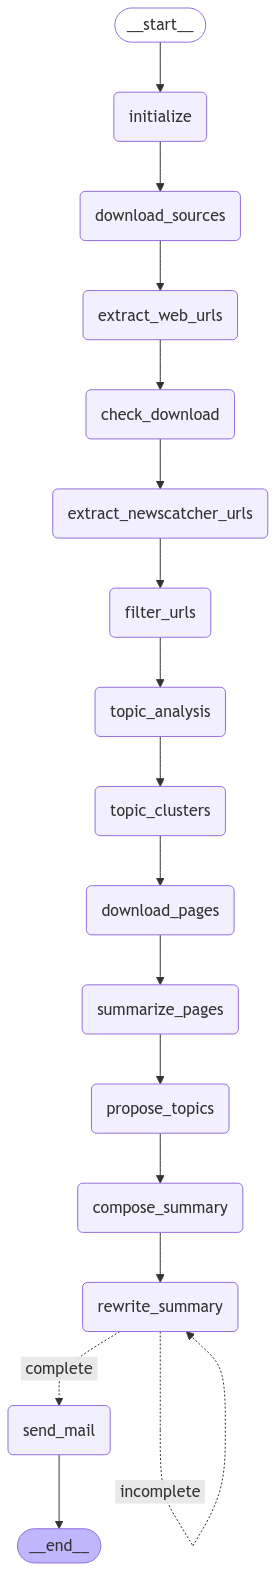

In [43]:
do_download = False
before_date = ''
before_date = "2024-11-23 08:00:00"

state, lg_agent, thread_id = initialize_agent(do_download, before_date)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [44]:
# same as above but w/o using native langgraph runner, runs state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite
# download and extract, human in the loop checks all sources downloaded OK

state = lg_agent.initialize(state)
state = lg_agent.download_sources(state)
state = lg_agent.extract_web_urls(state)
state = lg_agent.check_download(state)
state = lg_agent.extract_newscatcher_urls(state)
# s/b 17 check all downloaded, if any got hit by a bot block then download manually
sources_downloaded = len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
print(sources_downloaded)
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]

sources_downloaded = len(
    pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 17
missing_sources = SOURCES_EXPECTED-sources_downloaded
missing_sources


2024-11-24 07:34:11,725 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2024-11-24 07:34:11,726 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-11-24 07:34:11,726 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-11-24 07:34:11,727 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-11-24 07:34:11,727 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-11-24 07:34:11,727 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-11-24 07:34:11,728 - AInewsbot - INFO - 

2024-11-24 07:34:12,126 - AInewsbot - INFO - The Register -> htmldata/The Register (11_24_2024 07_10_45 AM).html
2024-11-24 07:34:12,302 - AInewsbot - INFO - parse_file - found 209 raw links
2024-11-24 07:34:12,306 - AInewsbot - INFO - parse_file - found 110 filtered links
2024-11-24 07:34:12,307 - AInewsbot - INFO - 110 links found
2024-11-24 07:34:12,307 - AInewsbot - INFO - The Verge -> htmldata/The Verge AI (11_24_2024 07_10_47 AM).html
2024-11-24 07:34:12,335 - AInewsbot - INFO - parse_file - found 310 raw links
2024-11-24 07:34:12,339 - AInewsbot - INFO - parse_file - found 36 filtered links
2024-11-24 07:34:12,340 - AInewsbot - INFO - 36 links found
2024-11-24 07:34:12,340 - AInewsbot - INFO - VentureBeat -> htmldata/VentureBeat AI (11_24_2024 07_10_58 AM).html
2024-11-24 07:34:12,358 - AInewsbot - INFO - parse_file - found 332 raw links
2024-11-24 07:34:12,363 - AInewsbot - INFO - parse_file - found 44 filtered links
2024-11-24 07:34:12,364 - AInewsbot - INFO - 44 links found
2

17


0

In [45]:
if missing_sources:
    print(f"missing {missing_sources} sources")
else:
    state = lg_agent.filter_urls(state)
    display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])

    # do topic analysis, identify good topics
    state = lg_agent.topic_analysis(state)
    state = lg_agent.topic_clusters(state)

    # download and summarize pagesdd
    state = lg_agent.download_pages(state)

    state = lg_agent.summarize_pages(state)
    # free-form extract topics from summarize, combine with clusters, propose clean topics
    state = lg_agent.propose_topics(state)
    print(state["topics_str"])
    # compose using o1-preview and rewrite summary 3 times
    state = lg_agent.compose_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
    for _ in range(MAX_EDITS):
        if lg_agent.is_revision_complete(state)=='complete':
            break
        state = lg_agent.rewrite_summary(state)
        display(Markdown(state["summary"].replace("$","\\\\$")))
    state = lg_agent.send_mail(state)


2024-11-24 07:34:14,141 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2024-11-23 08:00:00'
2024-11-24 07:34:14,907 - AInewsbot - INFO - URLs in orig_df: 949
2024-11-24 07:34:14,909 - AInewsbot - INFO - Existing URLs in DB: 184955
2024-11-24 07:34:14,957 - AInewsbot - INFO - New URLs in df filtered by URL: 300
2024-11-24 07:34:15,070 - AInewsbot - INFO - Existing src+title: 7
2024-11-24 07:34:15,071 - AInewsbot - INFO - New URLs in df filtered by src+title: 293
2024-11-24 07:34:15,084 - AInewsbot - INFO - Found 286 unique new headlines
2024-11-24 07:34:15,091 - AInewsbot - INFO - Applying prompt to 6 pages using gpt-4o-mini
2024-11-24 07:34:15,091 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:34:15,092 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:34:15,092 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:34:15,092 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:34:15,092 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:34:15,093 - AInewsbot - IN

,id
src,
Business Insider,2
Feedly AI,31
HackerNoon,5
NYT Tech,1
Newscatcher,35
Reddit,1
Techmeme,3
The Register,4
VentureBeat,2


2024-11-24 07:34:18,637 - AInewsbot - INFO - start free-form topic extraction
2024-11-24 07:34:18,637 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:34:18,638 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:34:18,638 - AInewsbot - INFO - sent 38 items 
2024-11-24 07:34:23,637 - AInewsbot - INFO - got dict with 38 items 
2024-11-24 07:34:25,406 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:34:25,407 - AInewsbot - INFO - Processed 88 responses.
2024-11-24 07:34:25,409 - AInewsbot - INFO - 88 free-form topics extracted
2024-11-24 07:34:25,409 - AInewsbot - INFO - ['ai stocks', 'investment', 'finance', 'machine learning', 'stocks', 'trust', 'ethics', 'education', 'jesus', 'church', 'nvidia', 'fifa world cup', 'arlington', 'infrastructure', 'openai', 'court case', 'microsoft', 'legal issues', 'ai chips', 'amazon', 'anthropic', 'advertising', 'generative ai', 'data centers', 'identity', 'criticism', 'chatgpt', 'features', 'eric schmidt', 'innov

2024-11-24 07:35:12,427 - AInewsbot - INFO - Cognitive Science, topic 15 of 100
2024-11-24 07:35:12,427 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:35:12,428 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:35:12,429 - AInewsbot - INFO - sent 38 items 
2024-11-24 07:35:15,358 - AInewsbot - INFO - got dict with 38 items 
2024-11-24 07:35:15,963 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:35:15,964 - AInewsbot - INFO - Processed 88 responses.
2024-11-24 07:35:15,965 - AInewsbot - INFO - Computer Vision, topic 16 of 100
2024-11-24 07:35:15,965 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:35:15,966 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:35:15,966 - AInewsbot - INFO - sent 38 items 
2024-11-24 07:35:18,532 - AInewsbot - INFO - got dict with 38 items 
2024-11-24 07:35:20,069 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:35:20,070 - AInewsbot - INFO - Processed 88 responses.
2024-11-

2024-11-24 07:36:15,278 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:36:15,281 - AInewsbot - INFO - Processed 88 responses.
2024-11-24 07:36:15,282 - AInewsbot - INFO - Fashion, topic 32 of 100
2024-11-24 07:36:15,282 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:36:15,285 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:36:15,286 - AInewsbot - INFO - sent 38 items 
2024-11-24 07:36:25,103 - AInewsbot - INFO - got dict with 38 items 
2024-11-24 07:36:27,877 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:36:27,879 - AInewsbot - INFO - Processed 88 responses.
2024-11-24 07:36:27,879 - AInewsbot - INFO - Finance, topic 33 of 100
2024-11-24 07:36:27,880 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:36:27,883 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:36:27,884 - AInewsbot - INFO - sent 38 items 
2024-11-24 07:36:30,574 - AInewsbot - INFO - got dict with 38 items 
2024-11-24 07:36:31,145 - 

2024-11-24 07:37:21,014 - AInewsbot - INFO - got dict with 38 items 
2024-11-24 07:37:21,628 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:37:21,632 - AInewsbot - INFO - Processed 88 responses.
2024-11-24 07:37:21,633 - AInewsbot - INFO - Intellectual Property, topic 49 of 100
2024-11-24 07:37:21,634 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:37:21,636 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:37:21,637 - AInewsbot - INFO - sent 38 items 
2024-11-24 07:37:24,497 - AInewsbot - INFO - got dict with 38 items 
2024-11-24 07:37:25,638 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:37:25,640 - AInewsbot - INFO - Processed 88 responses.
2024-11-24 07:37:25,640 - AInewsbot - INFO - Internet of Things, topic 50 of 100
2024-11-24 07:37:25,640 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:37:25,641 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:37:25,641 - AInewsbot - INFO - sent 38 items 
2

2024-11-24 07:38:17,240 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:38:17,240 - AInewsbot - INFO - sent 38 items 
2024-11-24 07:38:19,943 - AInewsbot - INFO - got dict with 38 items 
2024-11-24 07:38:20,617 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:38:20,619 - AInewsbot - INFO - Processed 88 responses.
2024-11-24 07:38:20,620 - AInewsbot - INFO - Policy and regulation, topic 66 of 100
2024-11-24 07:38:20,622 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:38:20,622 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:38:20,623 - AInewsbot - INFO - sent 38 items 
2024-11-24 07:38:24,356 - AInewsbot - INFO - got dict with 38 items 
2024-11-24 07:38:24,763 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:38:24,766 - AInewsbot - INFO - Processed 88 responses.
2024-11-24 07:38:24,766 - AInewsbot - INFO - Politics, topic 67 of 100
2024-11-24 07:38:24,767 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 

2024-11-24 07:39:19,089 - AInewsbot - INFO - Singularity, topic 82 of 100
2024-11-24 07:39:19,089 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:39:19,090 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:39:19,090 - AInewsbot - INFO - sent 38 items 
2024-11-24 07:39:21,645 - AInewsbot - INFO - got dict with 38 items 
2024-11-24 07:39:24,225 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:39:24,227 - AInewsbot - INFO - Processed 88 responses.
2024-11-24 07:39:24,227 - AInewsbot - INFO - Smart grid, topic 83 of 100
2024-11-24 07:39:24,227 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:39:24,235 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:39:24,237 - AInewsbot - INFO - sent 38 items 
2024-11-24 07:39:26,724 - AInewsbot - INFO - got dict with 38 items 
2024-11-24 07:39:27,315 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:39:27,317 - AInewsbot - INFO - Processed 88 responses.
2024-11-24 07:39:27

2024-11-24 07:40:18,479 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:40:18,480 - AInewsbot - INFO - Processed 88 responses.
2024-11-24 07:40:18,481 - AInewsbot - INFO - Virtual & Augmented Reality, topic 99 of 100
2024-11-24 07:40:18,481 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:40:18,482 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:40:18,484 - AInewsbot - INFO - sent 38 items 
2024-11-24 07:40:21,143 - AInewsbot - INFO - got dict with 38 items 
2024-11-24 07:40:21,791 - AInewsbot - INFO - got dict with 50 items 
2024-11-24 07:40:21,793 - AInewsbot - INFO - Processed 88 responses.
2024-11-24 07:40:21,793 - AInewsbot - INFO - Virtual Assistants, topic 100 of 100
2024-11-24 07:40:21,793 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-24 07:40:21,794 - AInewsbot - INFO - sent 50 items 
2024-11-24 07:40:21,795 - AInewsbot - INFO - sent 38 items 
2024-11-24 07:40:25,035 - AInewsbot - INFO - got dict with 38 i

,id,title_topic_str
0,0,"Church Sets Up AI-Powered Jesus Inside Confessional Booth (Topics: Church, Confessional Booth, Gen AI, Jesus, Robots, Society & Culture)"
1,1,"Will AI Kill Google? (Topics: AI Doom, Future Predictions, Gen AI, Google, Job Automation, Opinion)"
2,2,"AI Jesus is ready to dispense advice from a booth in historic Swiss churchPope, Depeche Mode, silent on digital second comingBootnotes1 day|50 (Topics: Advice, Church, Gen AI, Jesus, Music, Society & Culture)"


2024-11-24 07:40:31,590 - AInewsbot - INFO - {'topic_title': 'AI in Society and Culture'}
2024-11-24 07:40:31,591 - AInewsbot - INFO - I dub this cluster: AI in Society and Culture


,id,title_topic_str
3,3,"AI technology coming to Arlington ahead of 2026 FIFA World Cup (Topics: Arlington, Fifa World Cup, Gen AI, Infrastructure, Sports, Transportation, Travel)"
4,4,"How AI is reshaping the data-intensive field of Grand Prix racing, including helping design cars, setting F1's technical regulations, and shaping race strategy (James Allen/Financial Times) (Topics: Art & Design, Autonomous Vehicles, Car Design, Economics, Finance, Gen AI, Grand Prix Racing, Hardware, Policy And Regulation, Safety And Alignment, Science, Sports, Strategy, Transportation, Uk)"
5,5,"AI technology coming to Arlington intersections ahead of 2026 FIFA World Cup (Topics: Arlington, Fifa World Cup, Gen AI, Infrastructure, Sports, Transportation, Travel)"


2024-11-24 07:40:32,307 - AInewsbot - INFO - {'topic_title': 'AI in Sports and Transportation'}
2024-11-24 07:40:32,308 - AInewsbot - INFO - I dub this cluster: AI in Sports and Transportation


,id,title_topic_str
6,6,"Missed Out on Investing in Nvidia? Here's 1 Artificial Intelligence (AI) Chip Stock to Buy on the Dip (Topics: Chip Stocks, Deals, Economics, Finance, Funding, Gen AI, Hardware, Investment, Nvidia, Products, Semiconductor Chips, Stocks)"
7,7,"Billionaire Israel Englander Is Selling Nvidia and Buying These Other Artificial Intelligence (AI) Stocks Instead (Topics: AI Stocks, Economics, Finance, Gen AI, Hardware, Investment, Israel Englander, Nvidia, Products, Science, Stocks)"
8,8,"UnitedHealth Group's (UNH) AI Revolution: Hedge Funds' Top Healthcare Bet (Topics: Economics, Finance, Gen AI, Health & Fitness, Healthcare, Investment, Stocks, Unitedhealth Group)"
9,9,"Here Are My Top Artificial Intelligence (AI) Stocks to Buy Right Now (Hint: Not Nvidia) (Topics: Economics, Finance, Gen AI, Hardware, Investment, Nvidia, Opinion, Products, Review, Science, Stocks)"


2024-11-24 07:40:32,984 - AInewsbot - INFO - {'topic_title': 'Artificial Intelligence Investment Opportunities'}
2024-11-24 07:40:32,985 - AInewsbot - INFO - I dub this cluster: Artificial Intelligence Investment Opportunities


,id,title_topic_str
10,10,"Bloom Energy Corporation (BE) Powers AI Data Centers: Analyst Insights and Market Outlook (Topics: Bloom Energy, Data Centers, Economics, Energy, Finance, Gen AI, Hardware, Manufacturing, Market Outlook, Products, Science, Stocks, Sustainability)"
11,11,"Utilities, regulators, and researchers in six countries say the power demand surge caused by AI and data centers is being met in the near-term by fossil fuels (Reuters) (Topics: AI Doom, Bias And Fairness, Climate, Data Centers, Economics, Energy, Ethics, Fossil Fuels, Gen AI, Governance, Infrastructure, Policy And Regulation, Politics, Power Demand, Safety And Alignment, Science, Sustainability)"
12,12,"Data centers powering artificial intelligence could use more electricity than entire cities (Topics: Climate, Data Centers, Economics, Electricity, Energy, Gen AI, Infrastructure, Safety And Alignment, Science, Sustainability)"


2024-11-24 07:40:33,535 - AInewsbot - INFO - {'topic_title': 'AI and Energy Demand'}
2024-11-24 07:40:33,538 - AInewsbot - INFO - I dub this cluster: AI and Energy Demand


,id,title_topic_str
13,13,"How to Own ChatGPT, Gemini, Midjourney, and More for Life (Topics: Chatbots, Chatgpt, Code Assistants, Gemini, Gen AI, Language Models, Midjourney, Ownership, Products, Virtual Assistants)"
14,14,"Discover the Hidden Powers of ChatGPT You Never Knew Existed (Topics: Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Discovery, Entertainment, Features, Gen AI, Language Models, Opinion, Retrieval Augmented Generation, Review, Speech Recognition & Synthesis, Virtual Assistants)"
15,15,"I asked ChatGPT to plan my Thanksgiving menu. Here's how it did (Topics: Chatbots, Chatgpt, Code Assistants, Customer Service, Entertainment, Food & Drink, Gen AI, Language Models, Lifestyle & Travel, Menu Planning, Review, Society & Culture, Thanksgiving, Virtual Assistants)"


2024-11-24 07:40:34,252 - AInewsbot - INFO - {'topic_title': 'ChatGPT and Generative AI Tools'}
2024-11-24 07:40:34,253 - AInewsbot - INFO - I dub this cluster: ChatGPT and Generative AI Tools


,id,title_topic_str
16,16,"UBS Starts Celestica Inc. (CLS) at Neutral with $95 Target, Citing Balanced AI Growth Prospects (Topics: Celestica Inc., Economics, Finance, Financial Analysis, Gen AI, Hardware, Stock Market, Stocks)"
17,17,"KeyBanc Raises CrowdStrike Holdings, Inc. (CRWD) Price Target to $395, Highlights Strong Results and AI-Driven Cybersecurity Strength (Topics: Crowdstrike, Cybersecurity, Economics, Finance, Financial Analysis, Gen AI, Stock Market, Stocks)"
18,18,"Scotiabank Boosts Elastic N.V. (ESTC) Price Target to $135, Citing Strong Performance and AI Growth Potential (Topics: Economics, Elastic N.V., Finance, Financial Analysis, Gen AI, Stock Market, Stocks)"


2024-11-24 07:40:34,762 - AInewsbot - INFO - {'topic_title': 'AI in Finance and Stock Market'}
2024-11-24 07:40:34,762 - AInewsbot - INFO - I dub this cluster: AI in Finance and Stock Market


,id,title_topic_str
19,19,"How K-SIF and SIF Revolutionize Anomaly Detection in Complex Datasets (Topics: Anomaly Detection, Cognitive Science, Datasets, K-Sif, Korea, Safety And Alignment, Science, Sif)"
20,20,"Two Algorithms, One Goal: Changing the Face of Anomaly Detection with KIF and SIF (Topics: Algorithms, Anomaly Detection, Cognitive Science, Kif, Science, Sif)"
21,21,"Missingness-aware Causal Concept Explainer: An Elegant Explanation by Researchers to Solve Causal Effect Limitations in Black Box Interpretability (Topics: Artificial General Intelligence, Bias And Fairness, Causal Inference, Cognitive Science, Explanation, Interpretability, Research, Safety And Alignment, Science)"


2024-11-24 07:40:35,615 - AInewsbot - INFO - {'topic_title': 'Anomaly Detection and Cognitive Science'}
2024-11-24 07:40:35,616 - AInewsbot - INFO - I dub this cluster: Anomaly Detection and Cognitive Science
2024-11-24 07:40:35,621 - AInewsbot - INFO - ['AI in Society and Culture', 'AI in Sports and Transportation', 'Artificial Intelligence Investment Opportunities', 'AI and Energy Demand', 'ChatGPT and Generative AI Tools', 'AI in Finance and Stock Market', 'Anomaly Detection and Cognitive Science']
2024-11-24 07:40:35,643 - AInewsbot - INFO - Queuing URLs for scraping
2024-11-24 07:40:35,649 - AInewsbot - INFO - fetching 88 pages using 4 browsers
2024-11-24 07:40:35,652 - AInewsbot - INFO - get_driver - 99139 Initializing webdriver
2024-11-24 07:40:35,655 - AInewsbot - INFO - get_driver - 99139 Initializing webdriver
2024-11-24 07:40:35,655 - AInewsbot - INFO - get_driver - 99139 Initializing webdriver
2024-11-24 07:40:35,656 - AInewsbot - INFO - get_driver - 99139 Initializing webd

2024-11-24 07:41:59,726 - AInewsbot - INFO - Processing page 16: https://ca.finance.yahoo.com/news/ubs-starts-celestica-inc-cls-062948111.html
2024-11-24 07:41:59,762 - AInewsbot - INFO - Processing page 17: https://finance.yahoo.com/news/keybanc-raises-crowdstrike-holdings-inc-065431629.html
2024-11-24 07:41:59,763 - AInewsbot - INFO - get_url(https://ca.finance.yahoo.com/news/ubs-starts-celestica-inc-cls-062948111.html) - starting get_url https://ca.finance.yahoo.com/news/ubs-starts-celestica-inc-cls-062948111.html
2024-11-24 07:41:59,763 - AInewsbot - INFO - Processing page 18: https://uk.finance.yahoo.com/news/scotiabank-boosts-elastic-n-v-065129838.html
2024-11-24 07:41:59,763 - AInewsbot - INFO - get_url(https://finance.yahoo.com/news/keybanc-raises-crowdstrike-holdings-inc-065431629.html) - starting get_url https://finance.yahoo.com/news/keybanc-raises-crowdstrike-holdings-inc-065431629.html
2024-11-24 07:41:59,764 - AInewsbot - INFO - get_url(https://uk.finance.yahoo.com/news/s

2024-11-24 07:42:00,845 - AInewsbot - INFO - Processing page 35: https://www.fastcompany.com/91233710/ai-filmmakers-new-aesthetic
2024-11-24 07:42:00,845 - AInewsbot - INFO - get_url(https://www.fastcompany.com/91233710/ai-filmmakers-new-aesthetic) - starting get_url https://www.fastcompany.com/91233710/ai-filmmakers-new-aesthetic
2024-11-24 07:42:00,853 - AInewsbot - INFO - Processing page 36: https://www.yahoo.com/news/conservationists-turn-ai-battle-save-074215294.html
2024-11-24 07:42:00,856 - AInewsbot - INFO - get_url(https://www.yahoo.com/news/conservationists-turn-ai-battle-save-074215294.html) - starting get_url https://www.yahoo.com/news/conservationists-turn-ai-battle-save-074215294.html
2024-11-24 07:42:00,857 - AInewsbot - INFO - Processing page 37: https://www.businessinsider.com/ey-ai-avatar-hiring-process-preinterview-job-candidates-metaverse-2024-11
2024-11-24 07:42:00,858 - AInewsbot - INFO - get_url(https://www.businessinsider.com/ey-ai-avatar-hiring-process-preinter

2024-11-24 07:42:04,513 - AInewsbot - INFO - get_url(https://cacm.acm.org/blogcacm/ai-education-for-teens-lifting-the-hood-on-data-and-machine-learning/) - starting get_url https://cacm.acm.org/blogcacm/ai-education-for-teens-lifting-the-hood-on-data-and-machine-learning/
2024-11-24 07:42:04,518 - AInewsbot - INFO - Processing page 53: https://www.benzinga.com/pressreleases/24/11/g42151800/webroot-warns-shoppers-ai-convenience-comes-with-cybercrime-risk-this-holiday-season
2024-11-24 07:42:04,520 - AInewsbot - INFO - get_url(https://www.benzinga.com/pressreleases/24/11/g42151800/webroot-warns-shoppers-ai-convenience-comes-with-cybercrime-risk-this-holiday-season) - starting get_url https://www.benzinga.com/pressreleases/24/11/g42151800/webroot-warns-shoppers-ai-convenience-comes-with-cybercrime-risk-this-holiday-season
2024-11-24 07:42:04,522 - AInewsbot - INFO - Processing page 54: https://www.tomsguide.com/ai/i-write-about-ai-for-a-living-and-suno-v4-is-so-good-it-put-a-smile-on-my-f

2024-11-24 07:42:14,096 - AInewsbot - INFO - Processing page 69: https://finance.yahoo.com/news/microsoft-corporation-msft-ai-news-143735700.html
2024-11-24 07:42:14,103 - AInewsbot - INFO - get_url(https://finance.yahoo.com/news/microsoft-corporation-msft-ai-news-143735700.html) - starting get_url https://finance.yahoo.com/news/microsoft-corporation-msft-ai-news-143735700.html
2024-11-24 07:42:14,104 - AInewsbot - INFO - Processing page 70: https://www.theregister.com/2024/11/22/microsoft_recall_release/
2024-11-24 07:42:14,106 - AInewsbot - INFO - get_url(https://www.theregister.com/2024/11/22/microsoft_recall_release/) - starting get_url https://www.theregister.com/2024/11/22/microsoft_recall_release/
2024-11-24 07:42:14,109 - AInewsbot - INFO - Processing page 71: https://smartasset.com/data-studies0/chat-gpt-survey-financial-advisors
2024-11-24 07:42:14,110 - AInewsbot - INFO - get_url(https://smartasset.com/data-studies0/chat-gpt-survey-financial-advisors) - starting get_url http

2024-11-24 07:42:16,435 - AInewsbot - INFO - Quit webdriver
2024-11-24 07:42:16,689 - AInewsbot - INFO - get_url(Amazon Invests an Additional $4 Billion in Anthropic, an OpenAI Rival) - Saving Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.html as utf-8
2024-11-24 07:42:16,704 - AInewsbot - INFO - Quit webdriver
2024-11-24 07:42:16,922 - AInewsbot - INFO - get_url(Can You Trust Your AI Twin to Think Like You?) - Saving Can_You_Trust_Your_AI_Twin_to_Think_Like_You.html as utf-8
2024-11-24 07:42:16,925 - AInewsbot - INFO - Quit webdriver
2024-11-24 07:42:25,755 - AInewsbot - INFO - 31 pages saved
2024-11-24 07:42:27,325 - AInewsbot - INFO - 44 pages saved
2024-11-24 07:42:27,377 - AInewsbot - INFO - 9 pages saved
2024-11-24 07:42:27,394 - AInewsbot - INFO - 4 pages saved
2024-11-24 07:42:27,397 - AInewsbot - INFO - returned 88
2024-11-24 07:42:27,598 - AInewsbot - INFO - Starting summarize
2024-11-24 07:42:27,640 - AInewsbot - INFO - fetch_all_summaries - Page titl

2024-11-24 07:42:29,224 - AInewsbot - INFO - fetch_all_summaries - Page title: Scotiabank Boosts Elastic N.V. (ESTC) Price Target to $135, Citing Strong Performance and AI Growth Potential
Social card title: Scotiabank Boosts Elastic N.V. (ESTC) Price Target to $135, Citing Strong Performance and AI Growth Potential
Social card description: We recently compiled a list of the 14 AI Stocks on Wall Street’s Radar. In this article, we are going to take a look at where Elastic N.V. (NYSE:ESTC) stands against the other AI stocks that are on Wall Street’s Radar. Latest reports from tech news platform TechCrunch indicate that MatX, a chip-design startup focused on […]

2024-11-24 07:42:29,277 - AInewsbot - INFO - fetch_all_summaries - Page title: How K-SIF and SIF Revolutionize Anomaly Detection in Complex Datasets | HackerNoon
Social card title: How K-SIF and SIF Revolutionize Anomaly Detection in Complex Datasets | HackerNoon
Social card description: Explore how K-SIF and SIF, based on signa

2024-11-24 07:42:29,830 - AInewsbot - INFO - fetch_all_summaries - Page title: 5 ways that filmmakers are using AI to create a new aesthetic - Fast Company
Social card title: 5 ways that filmmakers are using AI to create a new aesthetic
Social card description: The often-eerie vibe of so much AI-generated imagery works well for chronicling contemporary ills, a fact that several filmmakers use to unexpected effect.

2024-11-24 07:42:29,855 - AInewsbot - INFO - fetch_all_summaries - Page title: Conservationists turn to AI in battle to save red squirrels
Social card title: Conservationists turn to AI in battle to save red squirrels
Social card description: The tech is being used to automatically control the creatures' access to feeders at sites across the UK.

2024-11-24 07:42:29,894 - AInewsbot - INFO - fetch_all_summaries - Page title: EY AI Avatar Can Do Pre-Interview With Job Candidates in Metaverse - Business Insider
Social card title: EY has an AI avatar named eVe that lets job cand

2024-11-24 07:42:30,916 - AInewsbot - INFO - fetch_all_summaries - Page title: Nvidia Boss Urges Global Cooperation During Hong Kong Trip - Bloomberg
Social card title: Nvidia Boss Urges Global Cooperation During Hong Kong Trip
Social card description: Nvidia Corp. Chief Executive Officer Jensen Huang called for preserving global cooperation amid growing anticipation of renewed tensions between the US and China once President-elect Donald Trump returns to the White House next year.

2024-11-24 07:42:30,941 - AInewsbot - INFO - fetch_all_summaries - Page title: KPMG Invests USD 100 Million in Google Cloud Alliance to Accelerate Enterprise AI Adoption
Social card title: KPMG Invests USD 100 Million in Google Cloud Alliance to Accelerate Enterprise AI Adoption
Social card description: KPMG announces a USD 100 million investment in Google Cloud Alliance to advance generative AI, data analytics, and cybersecurity solutions for enterprises.

2024-11-24 07:42:31,004 - AInewsbot - INFO - fetch

2024-11-24 07:42:31,869 - AInewsbot - INFO - fetch_all_summaries - Page title: Siri 2.0: Major Upgrades Coming to Apple's Voice Assistant - Geeky Gadgets
Social card title: Siri 2.0: Major Upgrades Coming to Apple's Voice Assistant
Social card description: Apple is on the verge of transforming its voice assistant, Siri with Siri 2.0, with the forthcoming release of iOS 19 which will happen in 2025. This

2024-11-24 07:42:31,918 - AInewsbot - INFO - fetch_all_summaries - Page title: How WSJ Readers Use AI: From Brainstorming to Learning a New Language and More - WSJ
Social card title: The Many Ways WSJ Readers Use AI in Their Everyday Lives
Social card description: They are increasingly leaning on artificial intelligence for work—but also for love and adventure.

2024-11-24 07:42:31,950 - AInewsbot - INFO - fetch_all_summaries - Page title: MSN

2024-11-24 07:42:31,967 - AInewsbot - INFO - fetch_all_summaries - Page title: Use AI Following the Marie Kondo Principle, Says AWS Vice Presid

[1. Church Sets Up AI-Powered Jesus Inside Confessional Booth - Futurism](https://futurism.com/the-byte/ai-powered-jesus-confession-booth)  

 AI in Society and Culture, Church, Confessional Booth, Gen AI, Jesus, Robots, Society & Culture  

- A church in Lucerne, Switzerland, has introduced an "AI Jesus" that allows visitors to converse with a computer trained on theological texts inside a confessional booth, aimed at exploring the public's interest in engaging with AI on spiritual matters.
- Over a two-month testing period, more than 1,000 people interacted with the AI, with over two-thirds describing their experiences as spiritual or positive, though reactions varied significantly.
- The project, described as an experiment rather than a traditional confessional, raised questions about the potential for AI in religious contexts, with theologians noting its ability to provide accessible dialogue about faith. 



[2. Will AI Kill Google? - tech.slashdot.org](https://tech.slashdot.org/story/24/11/23/0333202/will-ai-kill-google)  

 AI in Society and Culture, AI Doom, Future Predictions, Gen AI, Google, Job Automation, Opinion  

- Many experts believe that artificial intelligence may soon replace traditional search engines like Google, with predictions from influential figures such as Sam Altman and Bill Gates supporting this view.
- Google's dominance is challenged as it faces legal scrutiny for potential monopoly practices, while some argue that its search quality has declined due to excessive advertisement and SEO manipulation.
- Despite the predictions of AI transforming search, some experts caution against assuming such changes will happen imminently, suggesting that the evolution of technology is highly unpredictable. 



[3. AI Jesus is ready to dispense advice from a booth in historic Swiss churchPope, Depeche Mode, silent on digital second comingBootnotes1 day|50 - The Register](https://www.theregister.com/2024/11/23/ai_jesus_peterskapelle/)  

 AI in Society and Culture, Advice, Church, Gen AI, Jesus, Music, Society & Culture  

- An experimental art installation called "Deus in Machina," featuring an AI Jesus avatar, has been set up in Lucerne's Peterskapelle to engage visitors in dialogue about the role of AI in religion.
- Users reported mixed reactions, with some feeling consoled by the AI's advice, while others criticized the installation as a gimmick, prompting discussions on its implications for the church.
- The project was developed by the Lucerne University of Applied Sciences and Arts in collaboration with church representatives, aiming to attract lapsed Catholics and encourage conversations about faith and technology. 



[4. AI technology coming to Arlington ahead of 2026 FIFA World Cup - MSN](https://www.msn.com/en-us/news/technology/ai-technology-coming-to-arlington-ahead-of-2026-fifa-world-cup/ar-AA1uDPfO)  

 AI in Sports and Transportation, Arlington, Fifa World Cup, Gen AI, Infrastructure, Sports, Transportation, Travel  

- The provided text lacks substantive news content. 



[5. How AI is reshaping the data-intensive field of Grand Prix racing, including helping design cars, setting F1's technical regulations, and shaping race strategy (James Allen/Financial Times) - Twitter](https://t.co/vrzvtmCuN6)  

 AI in Sports and Transportation, Art & Design, Autonomous Vehicles, Car Design, Economics, Finance, Gen AI, Grand Prix Racing, Hardware, Policy And Regulation, Safety And Alignment, Science, Sports, Strategy, Transportation, Uk  

- AI is being utilized in Formula One to manage and analyze the vast amounts of data generated by cars, improving performance and race strategies.
- The technology enhances the design process of cars and shapes technical regulations, offering better simulations and aiding in understanding complex racing dynamics.
- While autonomous racing series like A2RL focus on driverless cars, F1 emphasizes human drivers, believing AI will enhance their abilities rather than replace them. 



[6. AI technology coming to Arlington intersections ahead of 2026 FIFA World Cup - MSN](https://www.msn.com/en-us/news/technology/ai-technology-coming-to-arlington-intersections-ahead-of-2026-fifa-world-cup/ar-AA1uDPfO)  

 AI in Sports and Transportation, Arlington, Fifa World Cup, Gen AI, Infrastructure, Sports, Transportation, Travel  

- No substantive news content available. 



[7. Missed Out on Investing in Nvidia? Here's 1 Artificial Intelligence (AI) Chip Stock to Buy on the Dip - Yahoo Finance](https://finance.yahoo.com/news/missed-investing-nvidia-heres-1-223000114.html)  

 Artificial Intelligence Investment Opportunities, Chip Stocks, Deals, Economics, Finance, Funding, Gen AI, Hardware, Investment, Nvidia, Products, Semiconductor Chips, Stocks  

- Nvidia has become the largest company by market capitalization, driven by the AI boom, prompting some investors to seek alternative stocks like Applied Materials, which has seen a decline due to reduced sales in China.
- Applied Materials produces essential equipment for semiconductor manufacturing and has shown consistent financial performance, with substantial free cash flow and a significant reduction in shares outstanding over the years.
- Despite recent stock price drops, valuation metrics suggest Applied Materials could be a strong buy, as its stock trades well below historical highs and is positioned to benefit from continued demand in the semiconductor market. 



[8. Billionaire Israel Englander Is Selling Nvidia and Buying These Other Artificial Intelligence (AI) Stocks Instead - Yahoo Finance](https://finance.yahoo.com/news/billionaire-israel-englander-selling-nvidia-133000007.html)  

 Artificial Intelligence Investment Opportunities, AI Stocks, Economics, Finance, Gen AI, Hardware, Investment, Israel Englander, Nvidia, Products, Science, Stocks  

- Billionaire investor Israel Englander has reduced his position in Nvidia by 12.6% over the last quarter, marking four consecutive quarters of selling the stock. 
- Instead, Millennium Management has increased its stake in Microsoft by 51.4%, purchasing 1.6 million shares, due to the company’s strong position in the AI market and its rapid adoption of AI technologies like Microsoft 365 Copilot. 
- Englander has also re-entered Meta Platforms, indicating a cautious optimism as the company shows potential in leveraging AI for increased engagement across its social media platforms. 



[9. UnitedHealth Group's (UNH) AI Revolution: Hedge Funds' Top Healthcare Bet - Yahoo Finance](https://ca.finance.yahoo.com/news/unitedhealth-group-unh-ai-revolution-151422273.html)  

 Artificial Intelligence Investment Opportunities, Economics, Finance, Gen AI, Health & Fitness, Healthcare, Investment, Stocks, Unitedhealth Group  

- UnitedHealth Group (NYSE:UNH) has seen significant growth, generating \\$100.82 billion in revenue in Q3 2024, attributed to strong pharmacy care and specialized services.
- The healthcare sector is benefiting from increased investments in artificial intelligence (AI), with projections indicating over \\$11 billion in AI healthcare spending this year and substantial potential for cost savings.
- UnitedHealth Group is recognized as a top healthcare investment by hedge funds, ranking first among the most promising healthcare stocks while leveraging AI to enhance productivity and patient care. 



[10. Here Are My Top Artificial Intelligence (AI) Stocks to Buy Right Now (Hint: Not Nvidia) - Yahoo Finance](https://finance.yahoo.com/news/top-artificial-intelligence-ai-stocks-123300374.html)  

 Artificial Intelligence Investment Opportunities, Economics, Finance, Gen AI, Hardware, Investment, Nvidia, Opinion, Products, Review, Science, Stocks  

- The article suggests investing in IBM, Micron Technology, and Fiverr International as undervalued stocks connected to the AI market, instead of Nvidia, which may be overvalued after significant price increases.
- IBM focuses on enterprise-class generative AI, securing \\$3 billion in service contracts, while Micron provides essential memory chips needed for AI systems, and Fiverr leverages AI technologies for matching freelancers and offering related services.
- The valuations of the recommended stocks are more reasonable compared to Nvidia, which is seen as being priced for perfection, potentially leading to a risk of price corrections. 



[11. Bloom Energy Corporation (BE) Powers AI Data Centers: Analyst Insights and Market Outlook - Yahoo Finance](https://finance.yahoo.com/news/bloom-energy-corporation-powers-ai-141821110.html)  

 AI and Energy Demand, Bloom Energy, Data Centers, Economics, Energy, Finance, Gen AI, Hardware, Manufacturing, Market Outlook, Products, Science, Stocks, Sustainability  

- Bloom Energy Corporation (NYSE:BE) has been identified as a key player in meeting the energy demands of AI data centers, leveraging solid-oxide fuel cell systems for on-site power generation.
- HSBC analyst Samantha Hoh downgraded Bloom Energy's stock from Buy to Hold, while increasing the price target to \\$24.50, citing fair valuation despite the company's potential growth due to AI data center demand.
- OpenAI recently launched a free training course for teachers to promote the responsible use of AI in education, acknowledging the high adoption of tools like ChatGPT among students. 



[12. Utilities, regulators, and researchers in six countries say the power demand surge caused by AI and data centers is being met in the near-term by fossil fuels (Reuters) - Reuters](https://www.reuters.com/technology/artificial-intelligence/how-ai-cloud-computing-may-delay-transition-clean-energy-2024-11-21/)  

 AI and Energy Demand, AI Doom, Bias And Fairness, Climate, Data Centers, Economics, Energy, Ethics, Fossil Fuels, Gen AI, Governance, Infrastructure, Policy And Regulation, Politics, Power Demand, Safety And Alignment, Science, Sustainability  

- The rising electricity demand from data centers, driven by AI and cloud computing, is causing an increase in fossil fuel use, which may hinder the clean-energy transition.
- Utilities across several countries, including the U.S., are expanding fossil fuel power plants to meet this demand, delaying the retirement of older plants and construction of new renewable energy sources.
- Despite pledges from major tech companies to use renewable energy, there are concerns that these commitments may lead to higher fossil fuel consumption as they extract clean power from the grid rather than increasing overall renewable capacity. 



[13. Data centers powering artificial intelligence could use more electricity than entire cities - Reddit](https://www.reddit.com/r/technology/comments/1gxzmhr/data_centers_powering_artificial_intelligence/)  

 AI and Energy Demand, Climate, Data Centers, Economics, Electricity, Energy, Gen AI, Infrastructure, Safety And Alignment, Science, Sustainability  

- Data centers powering artificial intelligence are projected to consume more electricity than entire cities, raising concerns about their energy demands.
- There are fears that AI models are operating as extensive surveillance databases, capable of retaining and processing vast amounts of data on individuals.
- Major tech companies, like Amazon and Microsoft, are investing in nuclear power to secure reliable energy sources for their growing power needs. 



[14. How to Own ChatGPT, Gemini, Midjourney, and More for Life - PCMag](https://www.pcmag.com/deals/how-to-own-chatgpt-gemini-midjourney-and-more-for-life)  

 ChatGPT and Generative AI Tools, Chatbots, Chatgpt, Code Assistants, Gemini, Gen AI, Language Models, Midjourney, Ownership, Products, Virtual Assistants  

- A new AI platform called 1minAI combines popular tools like ChatGPT, Gemini, and Midjourney, offering a one-time payment of \\$29.97 for a lifetime subscription until December 1.
- 1minAI provides features such as AI writing tools, image generation, audio transcription, and comes with monthly and daily credits for use.
- The promotion emphasizes saving over \\$200 on regular pricing and encourages immediate purchase without waiting for Black Friday. 



[15. Discover the Hidden Powers of ChatGPT You Never Knew Existed - Geeky Gadgets](https://www.geeky-gadgets.com/chatgpt-advanced-features/)  

 ChatGPT and Generative AI Tools, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Discovery, Entertainment, Features, Gen AI, Language Models, Opinion, Retrieval Augmented Generation, Review, Speech Recognition & Synthesis, Virtual Assistants  

- ChatGPT offers advanced features like Canvas Mode for real-time document editing and collaboration, as well as versatile file format support for exports to Word, Excel, PDF, and PowerPoint.
- Users can customize outputs by adjusting temperature settings for different writing styles and utilize DALL-E 3 for enhanced image generation, benefiting visual content creators.
- Advanced prompting techniques and memory management capabilities allow for personalized AI interactions and efficient organization of responses, improving overall productivity. 



[16. I asked ChatGPT to plan my Thanksgiving menu. Here's how it did - Yahoo](https://www.yahoo.com/news/lifestyle/asked-chatgpt-plan-thanksgiving-menu-170005104.html)  

 ChatGPT and Generative AI Tools, Chatbots, Chatgpt, Code Assistants, Customer Service, Entertainment, Food & Drink, Gen AI, Language Models, Lifestyle & Travel, Menu Planning, Review, Society & Culture, Thanksgiving, Virtual Assistants  

- ChatGPT generated a comprehensive Thanksgiving menu, including appetizers like Deviled Eggs and Cranberry Brie Bites, a main dish option of Roast Turkey or Butternut Squash Lasagna, and classic side dishes such as Creamy Garlic Mashed Potatoes and Sweet Potato Casserole. 
- For dessert, it suggested Pumpkin Pie, Apple Crisp, and Pecan Pie Bars, along with drinks like Hot Spiced Apple Cider and Pumpkin Spice Latte.
- The AI also offered hosting and decor tips, recommending warm and inviting decorations featuring autumn elements like wreaths, centerpieces, and seasonal utensils. 



[17. UBS Starts Celestica Inc. (CLS) at Neutral with \\$95 Target, Citing Balanced AI Growth Prospects - Yahoo Finance](https://ca.finance.yahoo.com/news/ubs-starts-celestica-inc-cls-062948111.html)  

 AI in Finance and Stock Market, Celestica Inc., Economics, Finance, Financial Analysis, Gen AI, Hardware, Stock Market, Stocks  

- UBS initiated coverage of Celestica Inc. (NYSE:CLS) with a Neutral rating and a \\$95 price target, citing balanced AI growth prospects.
- The company is recognized as a leader in AI infrastructure, although its demand is expected to be cyclical over the long term.
- UBS's analysis suggests that Celestica shares are factoring in at least 10% growth over the next decade, slightly above its 2025 revenue growth guide of 8.3%. 



[18. KeyBanc Raises CrowdStrike Holdings, Inc. (CRWD) Price Target to \\$395, Highlights Strong Results and AI-Driven Cybersecurity Strength - Yahoo Finance](https://finance.yahoo.com/news/keybanc-raises-crowdstrike-holdings-inc-065431629.html)  

 AI in Finance and Stock Market, Crowdstrike, Cybersecurity, Economics, Finance, Financial Analysis, Gen AI, Stock Market, Stocks  

- KeyBanc has raised the price target for CrowdStrike Holdings, Inc. (CRWD) to \\$395 from \\$345, maintaining an Overweight rating due to strong performance.
- The company leverages AI for enhanced cybersecurity, providing cloud-delivered protection across various platforms.
- Positive feedback from partners indicates a recovery for CrowdStrike, with no reported losses of customers despite recent muted quarterly results. 



[19. Scotiabank Boosts Elastic N.V. (ESTC) Price Target to \\$135, Citing Strong Performance and AI Growth Potential - Yahoo Finance](https://uk.finance.yahoo.com/news/scotiabank-boosts-elastic-n-v-065129838.html)  

 AI in Finance and Stock Market, Economics, Elastic N.V., Finance, Financial Analysis, Gen AI, Stock Market, Stocks  

- Scotiabank raised the price target for Elastic N.V. (ESTC) from \\$92 to \\$135, citing strong performance and growth potential in the AI sector.  
- Elastic N.V. is noted for its hosted and managed solutions tailored for hybrid and multi-cloud environments, with a strong position in generative AI.  
- The increase in price target reflects Scotiabank's confidence in Elastic's ability to capitalize on the growing demand for AI technologies. 



[20. How K-SIF and SIF Revolutionize Anomaly Detection in Complex Datasets - Hacker Noon](https://hackernoon.com/how-k-sif-and-sif-revolutionize-anomaly-detection-in-complex-datasets)  

 Anomaly Detection and Cognitive Science, Anomaly Detection, Cognitive Science, Datasets, K-Sif, Korea, Safety And Alignment, Science, Sif  

- The paper introduces two novel anomaly detection algorithms, K-SIF and SIF, which enhance the Functional Isolation Forest through non-linear data properties and data-driven techniques.
- K-SIF outperforms existing methods by effectively managing complex datasets and improving adaptability to diverse data patterns, while SIF offers state-of-the-art performance with computational efficiency.
- These advancements contribute significantly to the field of machine learning and provide robust solutions for detecting anomalies in complex functional data. 



[21. Two Algorithms, One Goal: Changing the Face of Anomaly Detection with KIF and SIF - Hacker Noon](https://hackernoon.com/two-algorithms-one-goal-changing-the-face-of-anomaly-detection-with-kif-and-sif)  

 Anomaly Detection and Cognitive Science, Algorithms, Anomaly Detection, Cognitive Science, Kif, Science, Sif  

- The article discusses two advanced algorithms for anomaly detection, Kernel Signature Isolation Forest (K-SIF) and Signature Isolation Forest, which aim to improve upon traditional methods like Functional Isolation Forest (FIF).
- The authors detail the construction and functioning of these algorithms, highlighting their input requirements and the steps involved in generating results while focusing on the parameters sensitivity and advantages over FIF.
- The paper includes practical applications demonstrating the effectiveness of K-SIF and SIF in real-data anomaly detection through benchmark testing. 



[22. Missingness-aware Causal Concept Explainer: An Elegant Explanation by Researchers to Solve Causal Effect Limitations in Black Box Interpretability - MarkTechPost](https://www.marktechpost.com/2024/11/23/missingness-aware-causal-concept-explainer-an-elegant-explanation-by-researchers-to-solve-causal-effect-limitations-in-black-box-interpretability/)  

 Anomaly Detection and Cognitive Science, Artificial General Intelligence, Bias And Fairness, Causal Inference, Cognitive Science, Explanation, Interpretability, Research, Safety And Alignment, Science  

- Researchers from the University of Wisconsin-Madison have developed a framework named "Missingness-aware Causal Concept Explainer" (MCCE) to address limitations in causal effect estimations caused by unobserved concepts in datasets.
- MCCE constructs pseudo-concepts that are orthogonal to observed data to enhance the model's reasoning and causal predictions, outperforming existing methods like S-Learner in metrics while demonstrating robust interpretability.
- The framework's effectiveness was validated using the CEBaB dataset, showcasing advantages even when dealing with missing concepts, indicating potential for broader application in machine learning explainability. 



[23. I got an in-store Apple Intelligence demo. Here are some useful features I hadn't spotted. - Business Insider](https://www.businessinsider.com/i-got-apple-intelligence-demo-store-ai-useful-features-2024-11)  

 Apple Intelligence, Consumer, Customer Service, Demo, Features, Products, Review, Virtual Assistants  

- The author visited an Apple store for a demonstration of Apple Intelligence features, learning about tools like Math Notes and Safari's 'hide' function.  
- Math Notes, available on iOS 18, allows users to solve complex equations through AI in the Calculator app.  
- Safari's 'hide' tool enables users to remove distractions from webpages, enhancing the online shopping experience.   



[24. AI search results  the good, the bad, and the flexible - Tom's Guide](https://www.tomsguide.com/ai/ai-search-results-the-good-the-bad-and-the-flexible)  

 Bias And Fairness, Evaluation, Gen AI, Search Results  

- AI-driven search engines like Google and Bing AI enhance search efficiency with personalized and context-aware results, while maintaining user choice to revert to traditional search methods.
- Google's AI overviews offer concise summaries from multiple sources, which can lead to inaccuracies, prompting users to adjust their search settings for more detailed results.
- Alternative AI search platforms such as Perplexity and You.com provide distinct benefits like reliable sourcing and conversational responses, catering to varying user preferences and research needs. 



[25. Did AI ruin Christmas? Coca-Colas iconic ad criticised - www.thesouthafrican.com](https://www.thesouthafrican.com/news/did-ai-ruin-christmas-coca-colas-iconic-ad-criticised/)  

 Advertising, Art & Design, Bias And Fairness, Christmas, Coca-Cola, Criticism, Entertainment, Gen AI, Music, Opinion, Review, Society & Culture, Tv & Film & Movies  

- Coca-Cola's 2023 Christmas ad, which uses generative AI for the first time, has faced significant criticism from viewers, many of whom disapproved of the AI-generated content.
- The ad includes three versions: one with non-human AI visuals, one mimicking real actors, and another focusing on festive animals, sparking mixed reactions among the public.
- In defense of the technology used, Coca-Cola stated that the campaign was a collaboration between human storytellers and AI, emphasizing their history of capturing holiday magic through various media. 



[26. A federal court allows a claim by The Intercept that DMCA prevents OpenAI from stripping a story's title or byline but throws out its claims against Microsoft - theintercept.com](https://theintercept.com/2024/11/22/openai-intercept-lawsuit/)  

 Authors & Writing, Bias And Fairness, Court Case, Dmca, Ethics, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Microsoft, Open Source, OpenAI, Policy And Regulation, Politics  

- The Intercept's lawsuit against OpenAI for unauthorized use of its journalists' work to train ChatGPT has been allowed to proceed in federal court, focusing on the Digital Millennium Copyright Act (DMCA).
- The court dismissed some claims, including those against Microsoft, but the decision highlights the DMCA's role in protecting news organizations from AI companies' encroachments.
- The lawsuit argues that OpenAI stripped copyright management information, such as bylines and titles, when using The Intercept's content. 



[27. Generative AI Is Helping To Clear Up Brain Fog - Forbes](https://www.forbes.com/sites/lanceeliot/2024/11/24/generative-ai-is-helping-to-clear-up-brain-fog/)  

 Brain Fog, Brain-Computer Interfaces, Cognitive Science, Consciousness, Gen AI, Generative AI, Health, Health & Fitness, Healthcare, Language Models, Science, Wellness  

- Brain fog is a common phenomenon characterized by a lack of mental clarity, affecting focus, memory, and cognitive function, with various potential causes including physical, psychological, and lifestyle factors.
- A recent study explored the diverse experiences related to brain fog, identifying it as a term used to describe a range of cognitive difficulties, urging more detailed descriptions to better understand its underlying mechanisms.
- Generative AI shows promise in assisting individuals to identify and manage brain fog by engaging in dialogue, posing relevant questions, and offering sensible lifestyle modifications, though its recommendations should be approached critically and not as a substitute for professional advice. 



[28. Using MLLMs for Diffusion Synthesis That Synergizes Both Sides: How Is This Possible? - Hacker Noon](https://hackernoon.com/using-mllms-for-diffusion-synthesis-that-synergizes-both-sides-how-is-this-possible)  

 Artificial General Intelligence, Cognitive Science, Diffusion Synthesis, Gen AI, Language Models, Mllms, Neuromorphic Computing, Reinforcement Learning, Research, Retrieval Augmented Generation, Science  

- The paper discusses leveraging Multimodal Large Language Models (MLLMs) for diffusion synthesis by enhancing cross-modal image generation through deep language comprehension.
- It proposes using learned embeddings to condition MLLMs for synthesis sampling, moving away from aligning MLLM output with CLIP.
- The exploration focuses on the synergy between creation and comprehension in multimodal signals, highlighting areas for future research and development. 



[29. One thing AI can't generate at the moment  compelling reasons to use it for work - The Register](https://www.theregister.com/2024/11/23/kettle_ai)  

 Gen AI, Jobs & Careerslabor Market, Limitations, Opinion, Productivity, Work  

- Current generative AI tools, such as chatbots, may be reducing productivity among workers who lack proper training on their use.
- Sales of high-end AI PCs are struggling, indicating a lukewarm market response to enterprise AI solutions.
- Microsoft is actively promoting artificial intelligence in an effort to justify its significant investment in OpenAI. 



[30. Game-changing AI tools that revolutionized business productivity in 2024 - GeekSided](https://geeksided.com/game-changing-ai-tools-that-revolutionized-business-productivity-in-2024)  

 2024, Business Productivity, Economics, Gaming, Gen AI, Innovation, Tools  

- In 2024, several AI-powered tools significantly enhanced business productivity, including ChatGPT for Business, GrammarlyGO, Notion AI, Salesforce Einstein, Trello AI, Tableau with AI, and Zoom IQ.
- These tools help streamline workflows, improve writing and communication, automate tasks, and provide predictive analytics to optimize decision-making and customer relations.
- Emphasizing the importance of these tools, the article suggests they will remain essential for business success in 2025. 



[31. Robotic shorts could help people walk farther. Yes, robotic shorts. - The Washington Post](https://www.washingtonpost.com/wellness/2024/11/23/robotic-shorts-walking-energy)  

 Assistive Technology, Hardware, Health & Fitness, Healthcare, Job Automation, Mobility, Products, Robotics, Robots, Science, Transportation  

- Scientists have developed "soft robotic shorts" called WalkON that help reduce energy expenditure while walking, potentially enhancing mobility for older and frail individuals.
- The shorts feature a pouch-like harness and artificial Kevlar tendons that assist with hip flexion, adapting to the wearer's movement and pace.
- This innovation could significantly improve independence and mobility for its users, particularly on uneven surfaces or staircases. 



[32. Robot drummer that's faster than humans could help musicians hone their craft - Yahoo](https://www.yahoo.com/news/robot-drummer-faster-humans-could-142105886.html)  

 Art & Design, Drumming, Entertainment, Hardware, Job Automation, Music, Products, Robotics, Robots, Science  

- Researchers at the University of Oslo have developed ZRob, a robotic drummer that can play faster than humans and create new rhythms, showcasing advanced dexterity and AI integration.
- ZRob is designed to mimic human wrist flexibility and has rudimentary senses, allowing it to adapt and optimize movements for complex drum compositions.
- The aim of ZRob is to inspire musicians rather than replace them, with potential uses in music practice and as a tool for musicians with disabilities. 



[33. How Self-Evolving LLMs Could Change Everything in AI - Geeky Gadgets](https://www.geeky-gadgets.com/future-of-ai-with-self-evolving-llms/)  

 Artificial General Intelligence, Cognitive Science, Gen AI, Innovation, Language Models, Llms, Retrieval Augmented Generation, Safety And Alignment, Science, Self-Evolving, Singularity  

- Self-evolving large language models (LLMs) autonomously update their parameters, potentially reducing retraining costs and improving efficiency in AI deployment for enterprises.
- Developed by the startup Writer, these models are currently in beta testing and feature a memory pool for enhanced learning capabilities, aiming to pave the way toward artificial general intelligence (AGI).
- Challenges include ensuring safety and security against the risk of models acquiring harmful or incorrect information through autonomous learning. 



[34. Training-Free Guidance (TFG): A Unified Machine Learning Framework Transforming Conditional Generation in Diffusion Models with Enhanced Efficiency and Versatility Across Domains - MarkTechPost](https://www.marktechpost.com/2024/11/23/training-free-guidance-tfg-a-unified-machine-learning-framework-transforming-conditional-generation-in-diffusion-models-with-enhanced-efficiency-and-versatility-across-domains/)  

 Artificial General Intelligence, Cognitive Science, Conditional Generation, Diffusion Models, Efficiency, Gen AI, Language Models, Machine Learning, Neuromorphic Computing, Reinforcement Learning, Retrieval Augmented Generation, Science, Transformers  

- Researchers have developed a new framework called Training-Free Guidance (TFG), which unifies existing methodologies for conditional generation in diffusion models, eliminating the need for retraining.
- TFG enhances efficiency and versatility across various tasks, achieving significant performance improvements, such as 77.1% accuracy in CIFAR10 tasks and a 5.64% reduction in mean absolute error for molecule generation.
- The framework employs innovative techniques, including hyper-parameter optimization and recurrent refinement, allowing for scalable and accessible generative modeling in fields such as image synthesis and audio creation. 



[35. Huawei AI chips to power China's next-gen surgery tech for medical breakthroughs - Yahoo](https://www.yahoo.com/news/huawei-ai-chips-power-china-133240667.html)  

 AI Chips, China, Economics, Gen AI, Hardware, Health & Fitness, Healthcare, Huawei, Innovation, Medical Technology, Politics, Products, Safety And Alignment, Science, Semiconductor Chips, Surgery  

- The Centre for Artificial Intelligence and Robotics (CAIR) has developed Cares Copilot 2.0 using Huawei's AI chips to assist surgeons with tasks like surgical planning and generating diagnostic reports.
- Huawei's Ascend 910B AI chip, which is competing against Nvidia's technology, is key to CAIR's advancements, with significant improvements noted in processing times for AI model training.
- US export controls are driving China to rely on Huawei's technology, with the company planning to mass-produce its Ascend 910C chip despite production challenges, reflecting a broader push for semiconductor self-reliance in China. 



[36. 5 ways that filmmakers are using AI to create a new aesthetic - Fast Company](https://www.fastcompany.com/91233710/ai-filmmakers-new-aesthetic)  

 Aesthetics, Art & Design, Creativity, Entertainment, Filmmaking, Gen AI, Hollywood, Society & Culture, Tv & Film & Movies  

- Filmmakers are increasingly using AI tools like Midjourney and Runway to create unique short films that reflect contemporary social issues and aesthetics, making filmmaking more accessible.
- Five emerging visual trends in AI filmmaking include morphing imagery, surrealism, dark narratives reflecting societal themes, nostalgia for past cultural moments, and explorations of new temporal and spatial dimensions.
- These artistic trends highlight the evolving relationship between humans and technology, suggesting that AI may be reshaping storytelling approaches and self-perception. 



[37. Conservationists turn to AI in battle to save red squirrels - Yahoo](https://www.yahoo.com/news/conservationists-turn-ai-battle-save-074215294.html)  

 Climate, Computer Vision, Conservation, Environment, Gen AI, Red Squirrels, Science, Sustainability  

- Conservationists are using an AI tool called Squirrel Agent, capable of distinguishing between grey and red squirrels with 97% accuracy, to help protect red squirrels in the UK.
- The AI controls access to feeders, providing food to red squirrels while administering contraceptives to grey squirrels, addressing the urgent need to manage these populations due to threats faced by red squirrels.
- Future developments aim to identify individual squirrels by analyzing their whiskers, similar to human fingerprints, which could enhance tracking and monitoring efforts for conservation purposes. 



[38. EY has an AI avatar named eVe that lets job candidates do a pre-interview in the metaverse - Business Insider](https://www.businessinsider.com/ey-ai-avatar-hiring-process-preinterview-job-candidates-metaverse-2024-11)  

 AI Avatar, Customer Service, Economics, Ey, Gen AI, Job Automation, Job Candidates, Jobs & Careerslabor Market, Metaverse, Privacy, Robots, Society & Culture, Virtual & Augmented Reality, Virtual Assistants  

- EY has introduced an AI avatar named eVe to help job candidates conduct pre-interviews, allowing them to ask questions and prepare for real interviews in a less stressful environment.  
- The AI-powered eVe, which can converse via voice or text, answers inquiries about the company and provides insights into the hiring process, benefits, and interview preparation.  
- EY aims to leverage technology in recruiting, having invested heavily in AI, and eVe's design focuses on reducing user anxiety while still feeling personable. 



[39. Getting started with AI agents (part 1): Capturing processes, roles and connections - VentureBeat](https://venturebeat.com/ai/getting-started-with-ai-agents-part-1-capturing-processes-roles-and-connections/)  

 AI Agents, Cognitive Science, Connections, Gen AI, Processes, Roles, Science, Virtual Assistants  

- The article discusses the differences between AI agents and generative AI models, emphasizing the roles and communication requirements necessary for developing multi-agent systems within organizations.  
- It suggests capturing organizational processes and workflows to build a network of agents that can coordinate effectively, improving productivity and resilience.  
- A more distributed architecture for agent communication is recommended, allowing agents to process inquiries and delegate tasks dynamically, enhancing system efficiency. 



[40. Vertiv Holdings Co. (VRT) Leverages AI for Future Growth: Key Investor Insights - Yahoo Finance](https://uk.finance.yahoo.com/news/vertiv-holdings-co-vrt-leverages-141553511.html)  

 Economics, Finance, Gen AI, Growth, Investment Insights, Stocks, Vertiv Holdings  

- Vertiv Holdings Co. is positioning itself for growth by leveraging artificial intelligence, aligning with the broader industry trend of integrating AI technologies into business operations.
- Enfabrica, a startup focused on enhancing AI chip efficiency, has raised \\$115 million and plans to release a new chip capable of linking up to 500,000 AI chips, significantly increasing computational capabilities.
- OpenAI has launched a free training course for teachers through Common Sense Media to promote effective use of AI in education, addressing previous concerns about misuse of technologies like ChatGPT in academic settings. 



[41. Episode Four Launches RYA AI Tool for Marketing Campaign Generation - Hacker Noon](https://hackernoon.com/episode-four-launches-rya-ai-tool-for-marketing-campaign-generation)  

 AI Tool, Campaign Generation, Code Assistants, Gen AI, Language Models, Marketing, Products, Rya  

- Episode Four has launched RYA, an AI-driven marketing tool that analyzes 84 million data points weekly to generate campaign ideas based on American consumer behavior and preferences.
- The tool aims to enhance marketing efficiency, reducing campaign development time from weeks to days while providing insights into demographic trends and spending patterns.
- RYA positions itself as a complement to human creativity, with plans for future expansions that include a marketplace to connect marketing professionals, emphasizing the growing influence of AI in the advertising industry. 



[42. Should You Buy This Millionaire-Maker AI Stock Instead of Palantir? - Yahoo Finance](https://finance.yahoo.com/news/buy-millionaire-maker-ai-stock-101400707.html)  

 Deals, Economics, Finance, Gen AI, Investment, Opinion, Palantir, Products, Stock Market, Stocks  

- AppLovin's stock has increased over 650% this year, outperforming Palantir's 250% gain, with significant growth driven by its AI-powered adtech platform, Axon-2, leading to a 66% revenue increase in software.
- The company's profitability has also improved, with EPS quadrupling to \\$1.25 and gross margins rising from 69.3% to 77.5%, while it aims for long-term revenue growth of 20% to 30% in gaming and additional growth in e-commerce.
- Despite recent gains, AppLovin is trading at an attractive valuation, with a PEG ratio of 1.1, suggesting it may still be a viable investment option compared to Palantir's higher revenue multiples. 



[43. I tried to use Apple Intelligence's Image Playground to design a Thanksgiving menu  here's what I learned about the app in the process - Tom's Guide](https://www.tomsguide.com/ai/apple-intelligence/i-tried-to-use-apple-intelligences-image-playground-to-design-a-thanksgiving-menu-heres-what-i-learned-about-the-app-in-the-process)  

 App, Apple Intelligence, Art & Design, Computer Vision, Customer Service, Food & Drink, Image Playground, Products, Review, Thanksgiving, Virtual Assistants  

- Apple's Image Playground, part of the iOS 18.2 beta, allows users to generate images from text prompts, showing promise in AI image generation on iPhone despite current limitations.
- The app supports only two image styles (animation and illustration) and struggles with group shots, limited image sizes, and sometimes misinterprets prompts, reflecting its beta status.
- Users may find Image Playground suitable for creating avatars or fun images for messaging, but its current constraints hinder more complex projects like custom menus. 



[44. A judge compared OpenAI to a video game company in its court battle with The New York Times - Business Insider](https://www.businessinsider.com/openai-copyright-lawsuit-new-york-times-video-game-company-2024-11)  

 Authors & Writing, Comparison, Court Case, Ethics, Gaming, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, New York Times, Open Source, OpenAI, Policy And Regulation, Politics, Tv & Film & Movies  

- The New York Times has sued OpenAI for allegedly using its articles without permission to train ChatGPT, sparking ongoing copyright infringement litigation.  
- A judge denied OpenAI's request for information on the Times' use of AI, comparing the situation to a copyright holder and a video game manufacturer to illustrate her ruling.  
- OpenAI faces multiple copyright lawsuits, including those from various media organizations and authors, claiming their works were used without consent. 



[45. Will AI kill Google? Past predictions of doom were totally wrong. - The Washington Post](https://www.washingtonpost.com/technology/2024/11/22/google-monopoly-ai/)  

 AI Doom, Gen AI, Google, History, Opinion, Predictions  

- Predictions that AI will render Google obsolete echo past misconceptions where new technologies (like smartphones and social media) were expected to diminish Google's relevance but instead enhanced it.
- Google has experienced significant growth in search usage and advertising revenue, increasing from billions to trillions of annual searches and from \\$20 billion to an estimated \\$200 billion in ad revenue over the past decade.
- Experts caution against overestimating AI's impact on search behavior, suggesting that while AI may change how users find information, there is no certainty that it will displace Google in the near future. 



[46. Meet the super users who tap AI to get ahead at work - www.inquirer.com](https://www.inquirer.com/business/ai-artificial-intelligence-chatbots-20241123.html)  

 Gen AI, Jobs & Careerslabor Market, Productivity, Super Users, Workplace  

- Workers, referred to as "super users," are increasingly utilizing AI tools like chatbots to enhance productivity, efficiency, and creativity, reclaiming significant amounts of time at work.
- While the majority of workers do not use AI regularly, those who do report substantial benefits in their job performance but express concerns about privacy, inaccuracies, and the potential loss of skills.
- Experts caution users to fact-check AI outputs and consider security measures, as reliance on these tools could risk biases, errors, and a decrease in essential skills. 



[47. Amazon Invests an Additional \\$4 Billion in Anthropic, an OpenAI Rival - The Wall Street Journal](https://www.wsj.com/tech/ai/amazon-invests-an-additional-4-billion-in-anthropic-an-openai-rival-82744ff6)  

 AI Competition, Amazon, Anthropic, Deals, Economics, Finance, Funding, Gen AI, Investment, Mergers And Acquisitions, Open Source, OpenAI, Products, Science, Stocks, Venture Capital  

- Amazon is investing an additional \\$4 billion in AI startup Anthropic, doubling its previous investment.
- This brings Amazon's total investment in Anthropic to \\$8 billion, reflecting its strategy to compete in the AI market.
- Anthropic is based in San Francisco and is focused on AI safety and research. 



[48. 32.4% of Warren Buffett's \\$292 Billion Portfolio Is Invested in 4 Artificial Intelligence (AI) Stocks - Yahoo Finance](https://finance.yahoo.com/news/32-4-warren-buffetts-292-095300636.html)  

 AI Stocks, Economics, Finance, Gen AI, Investment, Portfolio, Science, Stocks, Warren Buffett  

- No substantive news content detected. 



[49. We can clone you wholesale: Boffins build ML agents that respond like specific people - The Register](https://go.theregister.com/feed/www.theregister.com/2024/11/24/ai_based_on_people/)  

 Artificial General Intelligence, Bias And Fairness, Cloning, Cognitive Science, Deepfakes, Ethics, Gen AI, Intellectual Property, Job Automation, Language Models, Machine Learning, Privacy, Privacy & Surveillance, Reinforcement Learning, Science  

- Researchers from Stanford, Northwestern, University of Washington, and Google DeepMind developed AI models capable of mimicking at least 1,000 real people by utilizing their responses to extensive interviews.
- The generative agent architecture combines qualitative interview data with a large language model, enabling it to replicate attitudes and behaviors, and achieving an 85% success rate in matching human responses when tested.
- The study anticipates a future where custom AI agents could interact on behalf of individuals, including simulating characteristics and behaviors of loved ones posthumously. 



[50. These artists are rebranding AI image generation with a new name - Fast Company](https://www.fastcompany.com/91228920/ai-photography-rebrands-as-promptography)  

 Art, Art & Design, Computer Vision, Entertainment, Gen AI, Image Generation, Intellectual Property, Rebranding, Society & Culture  

- Artists are increasingly using the term "promptography" to describe AI-generated images, differentiating it from traditional photography.
- The term was popularized by Boris Eldagsen and Christian Vince, highlighting the intentional process involved in creating AI art through prompts.
- There is a debate over the legitimacy of AI art as craft, with proponents arguing "promptography" elevates the practice, while critics believe it undermines traditional photography principles. 



[51. Q&A with Eric Schmidt about the DOJ's proposal for Google to sell Chrome, a new book about AI he co-authored with Craig Mundie and Henry Kissinger, and more (Michel Martin/NPR) - NPR](https://www.npr.org/2024/11/22/nx-s1-5199766/eric-schmidt-interview-the-justice-department-google-ai)  

 Artificial General Intelligence, Authors & Writing, Book, Books & Publishing, Doj, Eric Schmidt, Gen AI, Google, Governance, History, Legal Issues, Policy And Regulation, Politics, Science  

- Former Google CEO Eric Schmidt criticized the DOJ's proposal for Google to spin off its Chrome browser, arguing it would harm consumers and stifle innovation by breaking an integrated system that users prefer.
- The DOJ's recommendation follows an antitrust ruling against Google, which included restrictions on Google's financial agreements with device manufacturers to maintain its default search engine status.
- In a discussion about his book on AI, Schmidt emphasized the rapid advancements in AI technology and the need for society to address emerging ethical and regulatory questions before facing potential challenges posed by non-human intelligence. 



[52. Why you're wrong about AI art, according to the Ai-Da robot that just made a \\$1 million painting - TechRadar](https://www.techradar.com/computing/artificial-intelligence/why-youre-wrong-about-ai-art-according-to-the-ai-da-robot-that-just-made-a-usd1-million-painting)  

 AI Art, AI-Da Robot, Art & Design, Art Market, Computer Vision, Cultural Commentary, Deals, Entertainment, Ethics, Funding, Gen AI, Intellectual Property, Opinion, Robots, Society & Culture  

- The Ai-Da robot made headlines after its painting of Alan Turing sold for over \\$1 million at Sotheby's, marking it as the first humanoid robot artwork auctioned.
- Ai-Da's creator, Aidan Meller, argues that the existence of the robot artist and its works should provoke discussions about the nature of art and the role of AI in the creative process.
- The auction's success indicates a shift in the art world towards accepting AI-generated art as a legitimate form of creativity, suggesting it will play a significant role in future artistic discourse and society. 



[53. AI Education for Teens: Lifting the Hood on Data and Machine Learning  Communications of the ACM - ACM Communications](https://cacm.acm.org/blogcacm/ai-education-for-teens-lifting-the-hood-on-data-and-machine-learning/)  

 Cognitive Science, Data, Education, Ethics, Gen AI, Machine Learning, Safety And Alignment, Science, Society & Culture, Teens  

- A project funded by the National Science Foundation aims to introduce AI and machine learning concepts to teens aged 13-15 through a curriculum focused on cybersecurity applications, enhancing their understanding of how ML models work and the impact of human decisions.
- The curriculum emphasizes hands-on learning experiences using tools like NetsBlox and CODAP to explore fundamental ML concepts such as data features, optimization, adversarial thinking, overfitting/underfitting, and bias in ML models.
- Upcoming teacher workshops are planned to gather feedback on the age-appropriateness and effectiveness of the educational activities and to collaborate with others involved in AI education. 



[54. Webroot Warns Shoppers: AI Convenience Comes with Cybercrime Risk This Holiday Season - Benzinga](https://www.benzinga.com/pressreleases/24/11/g42151800/webroot-warns-shoppers-ai-convenience-comes-with-cybercrime-risk-this-holiday-season)  

 AI Doom, Bias And Fairness, Consumer Awareness, Cybercrime, Cybersecurity, Disinformation, Ethics, Gen AI, Holiday Shopping, Legal Issues, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams  

- Webroot warns that while AI enhances holiday shopping, it also increases the risk of cybercrime, with consumers losing over \\$10 billion to fraud in 2023.
- The company suggests essential tips for secure online shopping, including avoiding fake apps, not saving payment information, and being cautious of deals that seem too good to be true.
- Webroot offers a premium service designed to protect devices and personal information from potential data breaches during the holiday season. 



[55. I write about AI for a living and Suno v4 is so good it put a smile on my face - Tom's Guide](https://www.tomsguide.com/ai/i-write-about-ai-for-a-living-and-suno-v4-is-so-good-it-put-a-smile-on-my-face)  

 Authors & Writing, Entertainment, Gen AI, Innovation, Language Models, Opinion, Personal Experience, Review, Speech Recognition & Synthesis, Suno V4  

- Suno v4, the latest version of the AI music generator, shows significant improvements in sound quality and lyric generation, surpassing its predecessor and rival platforms.
- The new ReMi lyric writer creates more engaging and coherent lyrics, although it can sometimes produce offensive content, and the software still has issues with song editing and ending tracks abruptly.
- The "Personas" feature allows for easily generating full songs based on genre and vibe prompts, leading to rapid production of interesting music, indicating a promising future for AI-generated music. 



[56. MemoryFormer: A Novel Transformer Architecture for Efficient and Scalable Large Language Models - MarkTechPost](https://www.marktechpost.com/2024/11/23/memoryformer-a-novel-transformer-architecture-for-efficient-and-scalable-large-language-models/)  

 Artificial General Intelligence, Cognitive Science, Gen AI, Language Models, Large Language Models, Machine Learning, Memoryformer, Neuromorphic Computing, Retrieval Augmented Generation, Science, Transformer Architecture, Transformers  

- Researchers have introduced MemoryFormer, a novel transformer architecture that replaces fully connected layers with Memory Layers, enhancing computational efficiency for large language models (LLMs).
- MemoryFormer demonstrated significant reductions in computational complexity, achieving just 19% of the resource requirements of standard transformer blocks while maintaining or improving accuracy on various NLP tasks.
- The architecture outperformed existing efficient transformer methods in both benchmark accuracy and resource utilization, showcasing its potential for scalable deployment across diverse applications. 



[57. Jensen Huang urged global cooperation and highlighted China's contributions to AI, as he accepted an honorary doctorate degree in engineering in Hong Kong - Bloomberg](https://www.bloomberg.com/news/articles/2024-11-23/nvidia-boss-urges-global-cooperation-during-hong-kong-trip)  

 China, Education, Gen AI, Governance, Honorary Doctorate, Jensen Huang, Politics, Science, Society & Culture  

- Nvidia CEO Jensen Huang emphasized the importance of global cooperation amid rising US-China tensions with the upcoming Trump administration.
- He acknowledged China's significant contributions to AI development.
- Huang's company faces restrictions from US officials regarding advanced semiconductor sales to China due to national security concerns. 



[58. KPMG Invests USD 100 Million in Google Cloud Alliance to Accelerate Enterprise AI Adoption - telecomtalk.info](https://telecomtalk.info/kpmg-invests-usd100-million-google-cloud-ai/985289)  

 Economics, Enterprise AI, Finance, Funding, Gen AI, Google Cloud, Investment, Kpmg  

- KPMG has announced a \\$100 million investment in its alliance with Google Cloud to enhance generative AI, data analytics, and cybersecurity solutions for global enterprises, aiming for \\$1 billion in incremental revenue growth.
- The partnership will deliver tailored AI solutions across various sectors, including Financial Services, Healthcare, and Consumer and Retail, targeting improvements in processes such as fraud detection, patient support, and customer experience.
- KPMG and Google Cloud emphasize the integration of AI technology to empower organizations and drive sustainable growth through advanced knowledge assistance and data management capabilities. 



[59. Jim Cramer Doubles Down On Nvidia: 'Demand Is Accelerating' As AI Customers 'Have No Choice' But To Buy Its Chips - Yahoo Finance](https://finance.yahoo.com/news/jim-cramer-doubles-down-nvidia-130039306.html)  

 AI Customers, Demand, Economics, Finance, Gen AI, Hardware, Jim Cramer, Nvidia, Opinion, Products, Science, Semiconductor Chips, Stocks  

- Jim Cramer and analysts express a bullish outlook on Nvidia, citing accelerated demand for its chips essential for AI, with projections indicating significant returns on investment for customers.
- Nvidia's third-quarter revenue reached \\$35.1 billion, a 94% increase year-over-year, with a strong forecast for continued growth into the fourth quarter at \\$37.5 billion.
- Experts predict a positive multiplier effect across the tech sector due to Nvidia's chip sales, with estimates suggesting that every dollar spent on GPUs could generate \\$8 to \\$10 in economic impact. 



[60. Lightricks bets on open-source AI video to challenge Big Tech - VentureBeat](https://venturebeat.com/ai/exclusive-lightricks-bets-on-open-source-ai-video-to-challenge-big-tech/)  

 Big Tech, Gen AI, Intellectual Property, Lightricks, Open Source, Open-Source, Streaming, Venture Capital, Video Technology  

- Lightricks has launched LTXV, an open-source AI model that can generate professional-quality videos in real-time, aiming to challenge the dominance of proprietary systems from major tech companies.
- With a processing speed that allows for five seconds of video generation in just four seconds, LTXV is designed to run efficiently on consumer hardware, potentially making high-quality video production accessible to a wider audience.
- By adopting an open-source approach, Lightricks hopes to foster innovation and community adoption, contrasting with competitors that utilize closed models and APIs. 



[61. Barclays downgrades Baidu on ad pressure from generative AI - Yahoo Finance](https://finance.yahoo.com/news/barclays-downgrades-baidu-ad-pressure-113049682.html)  

 Advertising, Baidu, Barclays, China, Economics, Finance, Gen AI, Generative AI, Language Models, Stocks  

- Barclays downgraded Baidu (BIDU) to Equal Weight from Overweight with a new price target of \\$83, down from \\$115, due to pressures on advertising from generative AI.
- The company is experiencing declining advertising revenue, which is expected to reduce its profit margins further.
- Baidu, as a leader in generative AI, has seen around 20% of its search queries monetize at lower rates compared to traditional searches, amidst a weak overall advertising environment in China. 



[62. Twilio (TWLO) Honors AI Innovators: Transforming Customer Engagement with AI and LLMs - Yahoo Finance](https://finance.yahoo.com/news/twilio-twlo-honors-ai-innovators-144834137.html)  

 Customer Engagement, Customer Service, Economics, Gen AI, Language Models, Llms, Stocks, Twilio  

- Twilio Inc. (NYSE:TWLO) has been recognized for its integration of AI into its cloud communications platform, enabling enhanced customer engagement.
- The company recently announced the 16 honorees of the AI Startup Searchlight Awards, chosen from over 500 applicants for their innovative use of AI and Twilio tools.
- Investment firm Blackrock highlighted that AI advancements will significantly influence market trends into 2025, along with regulatory and geopolitical challenges impacting growth. 



[63. Hugging Face Releases Observers: An Open-Source Python Library that Provides Comprehensive Observability for Generative AI APIs - MarkTechPost](https://www.marktechpost.com/2024/11/23/hugging-face-releases-observers-an-open-source-python-library-that-provides-comprehensive-observability-for-generative-ai-apis/)  

 Code Assistants, Cognitive Science, Gen AI, Generative AI, Hugging Face, Language Models, Open Source, Open-Source, Products, Python, Retrieval Augmented Generation, Safety And Alignment, Science  

- Hugging Face has launched Observers, an open-source Python SDK designed to enhance transparency and understanding of generative AI interactions, enabling developers to track, analyze, and manage AI model interactions efficiently.
- The tool supports flexible integration with various AI providers and offers diverse storage options, including Hugging Face Datasets and DuckDB, allowing users to run SQL-like queries for easy data exploration.
- Observers prioritizes user-friendliness, transparency, and community involvement, inviting contributions from developers for continuous innovation in AI observability. 



[64. US High School Economics class: AI productivity will be as profound as Adam Smith's pin factory - Financial Times](https://www.ft.com/content/538a4a1b-51a5-4465-bab0-d7062474bc7e)  

 Economics, Education, Gen AI, Historical Comparison, History, Job Automation, Jobs & Careerslabor Market, Opinion, Productivity  

- The article discusses the transformative impact of artificial intelligence (AI) and digital technologies on productivity and economic growth, drawing parallels to Adam Smith's concept of the division of labor in a pin factory.
- It emphasizes that AI and digital twins are changing industries, creating new jobs, and enhancing efficiency, similar to the revolutionary effects observed during Smith's era.
- The text invites discussion on how principles of free markets and the "invisible hand" apply to modern innovations and their economic implications. 



[65. How researchers used AI in tandem with drones to find 303 previously uncharted Nazca Lines in Peru, almost doubling the number that had been mapped as of 2020 (Franz Lidz/New York Times) - The New York Times](https://www.nytimes.com/2024/11/23/science/nazca-lines-peru-ai.html)  

 Archaeology, Art & Design, Cognitive Science, Computer Vision, Drones, Gen AI, History, Lifestyle & Travel, Nazca Lines, Science, Sustainability, Transportation, Travel  

- Researchers using drones and artificial intelligence have discovered 303 new geoglyphs in Peru's Nazca Desert, nearly doubling the total amount known to date. 
- The geoglyphs, created by an ancient civilization between 200 B.C. and 700 A.D., feature various designs including animals and human figures, suggesting they served as sacred spaces for rituals.
- The site faces threats from vandalism and environmental damage, with an estimated 500 additional geoglyphs yet to be discovered. 



[66. 32k context length text embedding models - blog.voyageai.com](https://blog.voyageai.com/2024/09/18/voyage-3/)  

 Cognitive Science, Context Length, Gen AI, Language Models, Machine Learning, Retrieval Augmented Generation, Science, Text Embedding  

- Voyage AI has launched two new embedding models, voyage-3 and voyage-3-lite, which offer improved retrieval quality, lower costs, and smaller dimensions compared to OpenAI's models.
- Voyage-3 achieves 7.55% better performance than OpenAI v3 large while costing 2.2x less; voyage-3-lite outperforms OpenAI v3 large by 3.82% at 6.5x lower cost.
- Both models support a context length of 32K tokens, significantly more than OpenAI’s current offerings. 



[67. AIs Future and Nvidias Fortunes Ride on the Race to Pack More Chips Into One Place - The Wall Street Journal](https://www.wsj.com/tech/ai/nvidia-chips-ai-race-96d21d09)  

 Chips, Economics, Finance, Gen AI, Hardware, Market, Nvidia, Products, Science, Semiconductor Chips  

- Tech companies are in a competitive race for AI dominance, focusing on accumulating Nvidia chips to enhance their data centers.
- Major players like Musk’s xAI and Meta are building super clusters that can house up to 100,000 Nvidia chips.
- The financial investment in these super clusters runs into billions of dollars, reflecting the escalating demand for powerful AI processors. 



[68. Can You Trust Your AI Twin to Think Like You? - Hacker Noon](https://hackernoon.com/can-you-trust-your-ai-twin-to-think-like-you)  

 Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Ethics, Gen AI, Identity, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, Trust  

- Research by Stanford University and Google DeepMind demonstrates that AI can create digital replicas of individuals with up to 85% similarity in personality and decision-making.
- These "AI twins" could serve as proxies in decision-making and become valuable tools for social science research, but they also raise significant ethical concerns regarding privacy and misuse.
- The study suggests a more efficient method for creating digital twins, requiring focused interviews rather than extensive datasets, which may revolutionize how personalities are replicated. 



[69. We can clone you wholesale: Boffins build ML agents that respond like specific peopleOh, AI wanna be like you, AI wanna walk like you, talk like you, tooAI + ML3 hrs|12 - The Register](https://www.theregister.com/2024/11/24/ai_based_on_people/)  

 Artificial General Intelligence, Bias And Fairness, Cloning, Cognitive Science, Cultural References, Deepfakes, Ethics, Gen AI, Intellectual Property, Job Automation, Language Models, Machine Learning, Privacy, Privacy & Surveillance, Reinforcement Learning, Science  

- Researchers from Stanford, Northwestern, the University of Washington, and Google DeepMind have developed AI models that can mimic the responses and behaviors of specific individuals, based on in-depth qualitative interviews.
- Their study involved simulating over 1,000 real individuals and achieved an 85% accuracy in matching respondents' behaviors when asked about their experiences weeks later, using advanced AI techniques.
- The implications of this technology suggest potential future applications, such as creating custom AI agents to interact with loved ones or represent individuals after their death. 



[70. Is Microsoft Corporation (MSFT) AI News Should Pay Attention to? - Yahoo Finance](https://finance.yahoo.com/news/microsoft-corporation-msft-ai-news-143735700.html)  

 AI News, Economics, Finance, Gen AI, Investment, Microsoft, Stocks  

- Microsoft Corporation has made significant moves in the AI sector, including a recent deal with HarperCollins to train AI models using their nonfiction titles.
- Blackrock's investor note highlights that AI themes have dominated global stock markets and are expected to continue influencing market trends into 2025.
- The report also addresses regulatory and geopolitical challenges that may arise, potentially affecting the dynamics between US-focused AI companies and those with a global presence. 



[71. Nows your chance to try Microsofts controversial Windows Recall ... maybeLike its AI, this automated screenshotter and logger is a feature not exactly everyone wanted - The Register](https://www.theregister.com/2024/11/22/microsoft_recall_release/)  

 Automation, Gen AI, Job Automation, Microsoft, Privacy, Privacy & Surveillance, Products, Technology Features, Windows Recall  

- Microsoft has launched a limited public preview of its Windows Recall system, designed to automate screenshot logging for Copilot+ PCs, despite prior privacy and security backlash.
- The application, which takes regular snapshots of a user's screen for later retrieval, is now disabled by default and offers enhanced security features, including local storage in virtualization-based security enclaves.
- Initially available only on Qualcomm Snapdragon devices, Recall will soon support other hardware platforms, while allowing users to exclude certain applications from logging and ensuring sensitive data is not stored. 



[72. Nearly 6 in 10 Advisors Are Interested in Testing Out AI or ChatGPT - SmartAsset - SmartAsset](https://smartasset.com/data-studies0/chat-gpt-survey-financial-advisors)  

 Chatbots, Chatgpt, Financial Advisors, Gen AI, Interest, Jobs & Careerslabor Market, Language Models, Technology Adoption, Testing  

- The text contains no substantive news content. 



[73. Around the Globe, Governments Lean into AI - The Atlantic](https://www.theatlantic.com/sponsored/google/governments-ai/3969/)  

 Gen AI, Global Trends, Governance, Governments, Policy, Policy And Regulation, Politics, Science  

- Governments worldwide are actively developing AI systems, each influenced by their unique historical, economic, and social contexts, exemplified by initiatives ranging from AI-enabled pothole identification in Memphis to chatbots in Portugal.
- Europe is focusing on regulatory frameworks like GDPR and the upcoming EU Artificial Intelligence Act to manage AI risks, balancing innovation with safety, although some regions, like Estonia and Denmark, are successfully integrating AI in government operations.
- In Africa, AI adoption is rapidly transforming public services, from healthcare in Mozambique to urban planning innovations in cities like Nairobi, while Latin America's fragmented approach highlights both leaders and laggards in AI development across the region. 



[74. Siri 2.0: Major Upgrades Coming to Apple's Voice Assistant - Geeky Gadgets](https://www.geeky-gadgets.com/siri-2-0-major-upgrades-coming-to-apples-voice-assistant/)  

 Apple, Customer Service, Products, Siri, Speech Recognition & Synthesis, Technology Updates, Virtual Assistants, Voice Assistant  

- Apple is set to launch Siri 2.0 with iOS 19 in 2025, featuring a large language model that enhances Siri's accuracy and natural language processing capabilities.
- The update includes a redesigned user interface for improved usability and onscreen awareness for context-specific assistance.
- Siri 2.0 will offer seamless in-app actions, allowing users to execute tasks without leaving their current applications, solidifying Siri's competitive edge in AI voice assistance. 



[75. The Many Ways WSJ Readers Use AI in Their Everyday Lives - The Wall Street Journal](https://www.wsj.com/tech/ai/using-ai-readers-tips-8462bb35)  

 Everyday Life, Gen AI, Reader Experiences, Wsj  

- WSJ readers are increasingly utilizing AI tools like ChatGPT for various personal and professional tasks, including brainstorming, learning new languages, and simplifying work-related activities.
- The use of AI is rapidly evolving, with readers sharing diverse applications from selecting TV shows to assisting with home projects.
- This growing reliance on generative AI indicates its integration into everyday life for both practical and creative purposes. 



[76. 3 Millionaire-Maker Artificial Intelligence (AI) Stocks - MSN](https://www.msn.com/en-us/money/companies/3-millionaire-maker-artificial-intelligence-ai-stocks/ar-AA1uCe2e)  

 Economics, Finance, Gen AI, Investment, Millionaire, Products, Science, Stocks  

- The text does not contain any substantive news content. 



[77. AI can be used to create job promotion, not be a job replacement, says AWS vice president - Business Insider](https://www.businessinsider.com/gen-ai-job-promotion-not-replacement-aws-vice-president-2024-11)  

 Aws, Economics, Employment, Gen AI, Job Automation, Job Promotion, Jobs & Careerslabor Market  

- Swami Sivasubramanian, VP of AI and Data at AWS, emphasizes that AI is meant to take over mundane tasks rather than replace jobs, enabling workers to focus on more valuable work.
- While AI may cause short-term job displacement, it is expected to lead to higher productivity and job creation in the long term, necessitating training and upskilling initiatives.
- Decisions should remain human-led, with AI serving as a supportive tool to enhance efficiency and creativity across various sectors like customer care, manufacturing, and drug discovery. 



[78. Lawyer Submits Anti-AI Document That Appears to Have Been Created Using AI - Yahoo](https://www.yahoo.com/news/lawyer-submits-anti-ai-document-140007915.html)  

 Bias And Fairness, Ethics, Gen AI, Intellectual Property, Job Automation, Language Models, Law, Legal Documents, Legal Issues, Policy And Regulation, Safety And Alignment, Science  

- A Minnesota lawyer, Jeff Hancock, is accused of using an AI chatbot to draft an affidavit supporting an anti-deepfake law, which ironically undermines his stance against AI deception.
- Challenges to the law by far-right YouTuber Mary Franson revealed that Hancock's affidavit contained references to non-existent studies, indicative of AI text generators' tendency to "hallucinate" facts.
- This incident continues a trend where lawyers face scrutiny for incorrect citations generated by AI, raising concerns about the reliability of AI-assisted legal documents. 



[79. Well the end of aging and death wouldn't be bad': Professor who coined the term AGI for superintelligence thinks we'll get human-level AI in three to five years' - TechRadar](https://www.techradar.com/computing/artificial-intelligence/well-the-end-of-aging-and-death-wouldnt-be-bad-professor-who-coined-the-term-agi-for-superintelligence-thinks-well-get-human-level-ai-in-three-to-five-years)  

 Agi, Aging, AI Doom, Artificial General Intelligence, Cognitive Science, Consciousness, Ethics, Future Predictions, Gen AI, Healthcare, Opinion, Science, Singularity, Society & Culture, Superintelligence  

- Dr. Ben Goertzel predicts that human-level Artificial General Intelligence (AGI) could be achieved within the next three to five years, aligning with similar forecasts from other experts in the field.
- He emphasizes the importance of ethical development for AGI, suggesting that a decentralized approach, like that of SingularityNET, is crucial to avoid narrow interests influencing its advancement.
- Goertzel discusses potential benefits of AGI, including curing diseases, enhancing human capabilities, and solving environmental issues, while also acknowledging the need for overseeing the technology’s implementation. 



[80. One thing AI can't generate at the moment  compelling reasons to use it for workKettleOur vultures think this tech is interesting but in its 8-bit stageAI + ML16 hrs|26 - The Register](https://www.theregister.com/2024/11/23/kettle_ai/)  

 8-Bit Stage, Gen AI, Jobs & Careerslabor Market, Opinion, Productivity  

- Current enterprise AI tools, particularly generative chatbots, may reduce worker productivity due to insufficient training on their effective use.
- Sales of expensive AI PCs are reportedly low, indicating a lack of market readiness for advanced AI systems.
- Microsoft's significant investment in OpenAI raises expectations for its AI offerings, particularly showcased at the Ignite conference. 



[81. Ex-Google CEO Eric Schmidt says AI will 'shape' identity and that 'normal people' are not ready for it - MSN](https://www.msn.com/en-us/money/companies/ex-google-ceo-eric-schmidt-says-ai-will-shape-identity-and-that-normal-people-are-not-ready-for-it/ar-AA1uCFCd)  

 AI Doom, Bias And Fairness, Cognitive Science, Consciousness, Eric Schmidt, Ethics, Future, Gen AI, Identity, Opinion, Privacy, Safety And Alignment, Science, Singularity, Society & Culture  

- No substantive news content available. 



[82. Do You Believe That AI Will Ruin Photography? Do You See It Already Happening? - Fstoppers](https://fstoppers.com/artificial-intelligence/believe-ai-will-ruin-photography-see-it-already-happening-685798)  

 AI Doom, Art & Design, Bias And Fairness, Criticism, Entertainment, Gen AI, Impact, Opinion, Photography, Review, Society & Culture  

- The rise of generative AI images is causing significant concern among photographers due to competition and the potential appropriation of their existing work.
- Generative AI generates images by resampling and blending existing photographs, potentially using works from photographers without their consent.
- Wildlife photographer Simon D’Entremont discusses the implications and provides advice on how creatives can protect their work and adapt to changes brought by generative AI. 



[83. Hankyung.com introduces: MecKare, Leading the AI-powered Innovation in Health Monitoring Solution - Yahoo Finance](https://finance.yahoo.com/news/hankyung-com-introduces-meckare-leading-130000776.html)  

 Gen AI, Health & Fitness, Health Monitoring, Healthcare, Innovation, Korea, Meckare, Products, Safety And Alignment, Science  

- JCF Technology has developed 'MecKare,' a non-contact radar sensor that measures biological signals such as heart rate and respiratory rate, aimed at enhancing safety for the elderly.
- The device uses advanced microwave radar technology to detect falls and other emergency situations, allowing for real-time monitoring and early warning to guardians without requiring the user to wear any device.
- MecKare is being utilized in senior care facilities across multiple countries and plans to expand its verification functions in the U.S. market in 2025. 



[84. ZICC: Internet Experts Pay Attention to the Development of Artificial Intelligence - Yahoo Finance](https://finance.yahoo.com/news/zicc-internet-experts-pay-attention-123900805.html)  

 Development, Gen AI, Internet, Technology Experts  

- AI has the potential to accelerate social progress, but proper usage is essential to mitigate negative effects, according to experts at the Wuzhen Summit.
- Calls for a global governance system were made to ensure AI technology benefits humanity, highlighting the need for safety and prevention of misuse.
- Experts emphasize that AI will not replace humans but rather create new job opportunities, particularly in healthcare. 



[85. Should You Still Learn to Code in an A.I. World? - The New York Times](https://www.nytimes.com/2024/11/24/business/computer-coding-boot-camps.html)  

 Code Assistants, Coding, Education, Gen AI, Job Automation, Jobs & Careerslabor Market, Opinion  

- The promise of coding boot camps as pathways to stable, high-paying tech jobs is diminishing due to a decline in job opportunities, exacerbated by advancements in AI tools that can assist in coding tasks.
- Coding boot camp graduates, like Florencio Rendon, are encountering a difficult job market, with layoffs in the tech industry and a sharp decrease in entry-level software developer positions.
- The job market is shifting towards requiring a broader skill set, including AI knowledge, while traditional coding roles may require more experience and education to secure employment. 



[86. A look at challenges facing Samsung Executive Chairman Lee Jae-yong, including the company falling behind in the AI chip race and discontent from employees - Twitter](https://t.co/VlBYgTCK9P)  

 AI Chips, Business Challenges, Economics, Gen AI, Hardware, Jobs & Careerslabor Market, Korea, Lee Jae-Yong, Samsung, Semiconductor Chips  

- Lee Jae-yong, heir to Samsung, faces significant challenges including a decline in its semiconductor division and employee unrest, marked by the company's first-ever strike in July.
- Samsung is struggling to compete in the AI chip market and has experienced a 30% drop in shares this year, leading to plans for a major management overhaul in its semiconductor business.
- Despite past controversies and legal troubles, Samsung maintains that Lee has been pivotal in steering the company’s diversification and innovation efforts. 



[87. Amazon Invests USD 4 Billion More in Anthropic, Expands AI Partnership - telecomtalk.info](https://telecomtalk.info/amazon-invests-usd4billion-more-in-anthropic-ai/985293)  

 AI Partnership, Amazon, Anthropic, Deals, Economics, Finance, Funding, Gen AI, Investment, Mergers And Acquisitions, Products, Science, Stocks, Venture Capital  

- Amazon increased its investment in AI startup Anthropic by an additional USD 4 billion, raising its total stake to USD 8 billion and designating AWS as Anthropic's primary cloud partner.
- Anthropic is working with AWS's Annapurna Labs to optimize future generations of Trainium chips, enhancing AI hardware capabilities for their AI foundation models.
- Anthropic's AI assistant, Claude, has become integral for businesses via Amazon Bedrock, enhancing productivity across various sectors, including notable use by the European Parliament and other organizations. 



[88. AI's scientific path to trust - Axios](https://www.axios.com/2024/11/24/artificial-intelligence-science-google-deepmind-trust)  

 Bias And Fairness, Cognitive Science, Ethics, Gen AI, Safety And Alignment, Science, Trust  

- Top researchers advocate for the use of scientific methods in AI development to regain public trust, warning against the rapid pace of technological advancement that may undermine scientific integrity.
- Recent AI-driven research includes groundbreaking advancements in drug discovery and genomic modeling, illustrating AI's potential to tackle complex biological challenges.
- Experts stress the importance of clear communication regarding AI's role in research, emphasizing that human design and interpretation are fundamental to its discoveries. 



2024-11-24 07:42:36,161 - AInewsbot - INFO - Sending bullet points email
2024-11-24 07:42:37,874 - AInewsbot - INFO - Proposing categories using chatgpt-4o-latest
2024-11-24 07:42:40,808 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-24 07:42:40,824 - AInewsbot - INFO - Original topics:
AI Jesus sparks debate on religion and technology
AI and Energy Demand
AI art challenges traditional photography and creativity
AI boosts healthcare innovation with MecKare
AI discovers 303 new Nazca Lines in Peru
AI in Finance and Stock Market
AI in Society and Culture
AI in Sports and Transportation
AI reshapes Formula One racing strategies
AI tools revolutionize business productivity in 2024
AI transforms customer engagement at Twilio
AI twins mimic human behavior with ethical implications
AI's role in reshaping Samsung's semiconductor strategy
AI-driven anomaly detection breakthroughs with K-SIF and SIF
AI-powered conservation protects red sq

AI Creativity Vs. Traditional Art
AI In Filmmaking
AI Jesus: Religion And Technology
Amazon $4B Anthropic Investment
Anomaly Detection Breakthroughs
Business Productivity Tools 2024
ChatGPT Tools
Cognitive Science
Conservation Of Red Squirrels
Customer Engagement At Twilio
Energy And Climate Concerns
Energy Demand Challenges
Eric Schmidt On Governance
Finance And Stock Market
Formula One Strategies
Healthcare Innovation At MecKare
Huawei: China's Medical Tech
Human Behavior Ethics
Investment Opportunities
MemoryFormer Language Models
Nazca Lines Discoveries Peru
Nvidia's Market Dominance
Public Services Globally
Samsung Semiconductor Strategy
Siri 2.0 Voice Assistance
Society And Culture


2024-11-24 07:43:32,227 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Divine Downloads: AI Jesus Takes the Confession

- Church Sets Up AI-Powered Jesus Inside Confessional Booth - [Futurism](https://futurism.com/the-byte/ai-powered-jesus-confession-booth)
- AI Jesus is ready to dispense advice from a booth in historic Swiss church - [The Register](https://www.theregister.com/2024/11/23/ai_jesus_peterskapelle/)

# Amazon's Big Bet: Investing Billions in Anthropic

- Amazon Invests an Additional \\$4 Billion in Anthropic, an OpenAI Rival - [The Wall Street Journal](https://www.wsj.com/tech/ai/amazon-invests-an-additional-4-billion-in-anthropic-an-openai-rival-82744ff6)
- Amazon Invests USD 4 Billion More in Anthropic, Expands AI Partnership - [telecomtalk.info](https://telecomtalk.info/amazon-invests-usd4billion-more-in-anthropic-ai/985293)

# Power-Hungry AI: Data Centers Drain Energy

- Utilities, regulators, and researchers in six countries say the power demand surge caused by AI and data centers is being met in the near-term by fossil fuels - [Reuters](https://www.reuters.com/technology/artificial-intelligence/how-ai-cloud-computing-may-delay-transition-clean-energy-2024-11-21/)
- Data centers powering artificial intelligence could use more electricity than entire cities - [Reddit](https://www.reddit.com/r/technology/comments/1gxzmhr/data_centers_powering_artificial_intelligence/)

# Legal Showdowns: AI Firms Face Copyright Battles

- A federal court allows a claim by The Intercept that DMCA prevents OpenAI from stripping a story's title or byline but throws out its claims against Microsoft - [The Intercept](https://theintercept.com/2024/11/22/openai-intercept-lawsuit/)
- A judge compared OpenAI to a video game company in its court battle with The New York Times - [Business Insider](https://www.businessinsider.com/openai-copyright-lawsuit-new-york-times-video-game-company-2024-11)

# Chipping In: Nvidia's Market Dominance in AI

- Jim Cramer Doubles Down On Nvidia: 'Demand Is Accelerating' As AI Customers 'Have No Choice' But To Buy Its Chips - [Yahoo Finance](https://finance.yahoo.com/news/jim-cramer-doubles-down-nvidia-130039306.html)
- AI's Future and Nvidia's Fortunes Ride on the Race to Pack More Chips Into One Place - [The Wall Street Journal](https://www.wsj.com/tech/ai/nvidia-chips-ai-race-96d21d09)

2024-11-24 07:43:32,229 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-11-24 07:44:11,959 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Ascends: From 'AI Jesus' to Amazon's \\$4B Bet

## Divine Dialogues: AI Jesus in the Confessional

- A Swiss church has installed an AI-powered Jesus in a confessional booth to dispense advice. [Futurism](https://futurism.com/the-byte/ai-powered-jesus-confession-booth), [The Register](https://www.theregister.com/2024/11/23/ai_jesus_peterskapelle/)

## Amazon's \\$4B Boost to Anthropic

- Amazon invests an additional \\$4 billion in Anthropic, expanding their AI partnership. [The Wall Street Journal](https://www.wsj.com/tech/ai/amazon-invests-an-additional-4-billion-in-anthropic-an-openai-rival-82744ff6), [telecomtalk.info](https://telecomtalk.info/amazon-invests-usd4billion-more-in-anthropic-ai/985293)

## AI's Energy Appetite: Power Demand Soars

- AI and data centers are causing a surge in power demand, potentially delaying the transition to clean energy. [Reuters](https://www.reuters.com/technology/artificial-intelligence/how-ai-cloud-computing-may-delay-transition-clean-energy-2024-11-21/)

## Legal Battles: OpenAI Faces Copyright Challenges

- OpenAI faces legal challenges over alleged copyright violations, with claims by The Intercept and The New York Times moving forward. [The Intercept](https://theintercept.com/2024/11/22/openai-intercept-lawsuit/), [Business Insider](https://www.businessinsider.com/openai-copyright-lawsuit-new-york-times-video-game-company-2024-11)

## Nvidia's Chip Dominance Drives AI Forward

- Nvidia's dominance in the AI chip market continues as demand accelerates, with customers relying heavily on its technology. [Yahoo Finance](https://finance.yahoo.com/news/jim-cramer-doubles-down-nvidia-130039306.html), [The Wall Street Journal](https://www.wsj.com/tech/ai/nvidia-chips-ai-race-96d21d09)

2024-11-24 07:44:11,962 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-11-24 07:44:42,376 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI's Power Plays: Amazon Invests Big, OpenAI Battles Legal Challenges

## Holy Hardware: AI Jesus Takes Confessions

- A Swiss church installs an AI-powered Jesus in a confessional to dispense advice. [Futurism](https://futurism.com/the-byte/ai-powered-jesus-confession-booth), [The Register](https://www.theregister.com/2024/11/23/ai_jesus_peterskapelle/)

## Amazon's AI Ambitions: \\$4B More to Anthropic

- Amazon invests an extra \\$4 billion in Anthropic, strengthening their AI collaboration. [The Wall Street Journal](https://www.wsj.com/tech/ai/amazon-invests-an-additional-4-billion-in-anthropic-an-openai-rival-82744ff6), [telecomtalk.info](https://telecomtalk.info/amazon-invests-usd4billion-more-in-anthropic-ai/985293)

## Power-Hungry AI: Energy Demands Surge

- AI and data centers drive soaring power demand, possibly hindering clean energy progress. [Reuters](https://www.reuters.com/technology/artificial-intelligence/how-ai-cloud-computing-may-delay-transition-clean-energy-2024-11-21/)

## Copyright Clashes: OpenAI in Legal Hot Water

- OpenAI faces lawsuits over alleged copyright violations from The Intercept and The New York Times. [The Intercept](https://theintercept.com/2024/11/22/openai-intercept-lawsuit/), [Business Insider](https://www.businessinsider.com/openai-copyright-lawsuit-new-york-times-video-game-company-2024-11)

## Nvidia's Reign: Driving the AI Chip Market

- Nvidia continues to dominate the AI chip market as demand accelerates. [Yahoo Finance](https://finance.yahoo.com/news/jim-cramer-doubles-down-nvidia-130039306.html), [The Wall Street Journal](https://www.wsj.com/tech/ai/nvidia-chips-ai-race-96d21d09)

2024-11-24 07:44:42,378 - AInewsbot - INFO - Sending summary email
2024-11-24 07:44:42,382 - AInewsbot - INFO - Email subject AI's Power Plays: Amazon Invests Big, OpenAI Battles Legal Challenges
2024-11-24 07:44:42,382 - AInewsbot - INFO - Email length 1871


In [46]:
# Edit topics in the state graph
#
# topics_str = state["topics_str"]
# ct2 = [s.replace('"', '\\"') for s in topics_str]
# Copy to clipboard, edit in your favorite editor
# os.system(shlex.quote(f"echo {topics_str} | pbcopy"))

# pyperclip.copy(topics_str)

# print(pyperclip.paste())

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [47]:
def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [48]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


Markdown content successfully saved to summary.md.


In [49]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [50]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

display(Markdown(summary_content))


# AI's Power Plays: Amazon Invests Big, OpenAI Battles Legal Challenges

## Holy Hardware: AI Jesus Takes Confessions

- A Swiss church installs an AI-powered Jesus in a confessional to dispense advice. [Futurism](https://futurism.com/the-byte/ai-powered-jesus-confession-booth), [The Register](https://www.theregister.com/2024/11/23/ai_jesus_peterskapelle/)

## Amazon's AI Ambitions: \\$4B More to Anthropic

- Amazon invests an extra \\$4 billion in Anthropic, strengthening their AI collaboration. [The Wall Street Journal](https://www.wsj.com/tech/ai/amazon-invests-an-additional-4-billion-in-anthropic-an-openai-rival-82744ff6), [telecomtalk.info](https://telecomtalk.info/amazon-invests-usd4billion-more-in-anthropic-ai/985293)

## Power-Hungry AI: Energy Demands Surge

- AI and data centers drive soaring power demand, possibly hindering clean energy progress. [Reuters](https://www.reuters.com/technology/artificial-intelligence/how-ai-cloud-computing-may-delay-transition-clean-energy-2024-11-21/)

## Copyright Clashes: OpenAI in Legal Hot Water

- OpenAI faces lawsuits over alleged copyright violations from The Intercept and The New York Times. [The Intercept](https://theintercept.com/2024/11/22/openai-intercept-lawsuit/), [Business Insider](https://www.businessinsider.com/openai-copyright-lawsuit-new-york-times-video-game-company-2024-11)

## Nvidia's Reign: Driving the AI Chip Market

- Nvidia continues to dominate the AI chip market as demand accelerates. [Yahoo Finance](https://finance.yahoo.com/news/jim-cramer-doubles-down-nvidia-130039306.html), [The Wall Street Journal](https://www.wsj.com/tech/ai/nvidia-chips-ai-race-96d21d09)

In [51]:
# create transcript
audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


2024-11-24 07:54:56,895 - podcastfy.content_generator - INFO - Content generated successfully
2024-11-24 07:54:56,897 - podcastfy.content_generator - INFO - Response content saved to ./data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt
2024-11-24 07:54:56,897 - podcastfy.client - INFO - Transcript generated successfully: ./data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt
2024-11-24 07:54:56,897 - podcastfy.client - INFO - Transcript generated successfully: ./data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt


Transcript saved to ./data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt


In [63]:
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
transcript_file


'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'

In [64]:
# edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


<Person1> "Welcome to Skynet and Chill! Today's AI news, lovingly curated by man and machine.  AI is everywhere, even in the confessional!  Can you believe it?"
</Person1><Person2> "AI Jesus?  Seriously?  That's a new one.  I mean, what's next, robot rabbis?  But, uh, tell me more about this digital deity." 
</Person2><Person1> "Well, apparently, a church in Switzerland installed an AI in the confessional booth.  It's supposed to offer guidance, you know, like a digital priest.  Kind of a weird mix of the sacred and the silicon, if you ask me." 
</Person1><Person2> "Yeah, a little bit.  I wonder if it assigns penance in cryptocurrency.  Speaking of money, did you see Amazon dumped another four BILLION dollars into Anthropic?"
</Person2><Person1> "Four billion!  That's insane! They're really trying to take on OpenAI.  It's like an AI arms race, but with cash.  Ka-ching!"
</Person1><Person2> "It's a high-stakes game, for sure.  But all this AI is going to need a lot of juice, literally. 

In [65]:
# create audio file from transcript
audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


2024-11-24 08:02:12,688 - podcastfy.client - INFO - Using transcript file: data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt
2024-11-24 08:02:12,688 - podcastfy.client - INFO - Using transcript file: data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt
2024-11-24 08:02:12,729 - podcastfy.tts.providers.geminimulti - INFO - Successfully initialized GeminiMultiTTS client
2024-11-24 08:02:12,731 - podcastfy.tts.providers.geminimulti - INFO - Starting audio generation for text of length: 2343
2024-11-24 08:02:12,733 - podcastfy.tts.providers.geminimulti - INFO - Created 2 chunks from input text
2024-11-24 08:02:12,739 - podcastfy.tts.providers.geminimulti - INFO - #########################33 Text split into 2 chunks
2024-11-24 08:02:17,277 - podcastfy.text_to_speech - INFO - Starting audio processing with 2 chunks
2024-11-24 08:02:18,188 - podcastfy.text_to_speech - INFO - ################### Loaded chunk 0, duration: 62520ms
2024-11-24 08:02:18,391 - podcastfy.te

In [66]:
embed_audio(audio_file)


Audio player embedded for: ./data/audio/podcast_5d39acf7cefb4bf3878b72ef0f037066.mp3


In [67]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


File 'podcast_5d39acf7cefb4bf3878b72ef0f037066.mp3' successfully moved to the current directory.


In [68]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enab

# Add screenshots to the video


In [69]:
display(Markdown(summary_content))

# AI's Power Plays: Amazon Invests Big, OpenAI Battles Legal Challenges

## Holy Hardware: AI Jesus Takes Confessions

- A Swiss church installs an AI-powered Jesus in a confessional to dispense advice. [Futurism](https://futurism.com/the-byte/ai-powered-jesus-confession-booth), [The Register](https://www.theregister.com/2024/11/23/ai_jesus_peterskapelle/)

## Amazon's AI Ambitions: \\$4B More to Anthropic

- Amazon invests an extra \\$4 billion in Anthropic, strengthening their AI collaboration. [The Wall Street Journal](https://www.wsj.com/tech/ai/amazon-invests-an-additional-4-billion-in-anthropic-an-openai-rival-82744ff6), [telecomtalk.info](https://telecomtalk.info/amazon-invests-usd4billion-more-in-anthropic-ai/985293)

## Power-Hungry AI: Energy Demands Surge

- AI and data centers drive soaring power demand, possibly hindering clean energy progress. [Reuters](https://www.reuters.com/technology/artificial-intelligence/how-ai-cloud-computing-may-delay-transition-clean-energy-2024-11-21/)

## Copyright Clashes: OpenAI in Legal Hot Water

- OpenAI faces lawsuits over alleged copyright violations from The Intercept and The New York Times. [The Intercept](https://theintercept.com/2024/11/22/openai-intercept-lawsuit/), [Business Insider](https://www.businessinsider.com/openai-copyright-lawsuit-new-york-times-video-game-company-2024-11)

## Nvidia's Reign: Driving the AI Chip Market

- Nvidia continues to dominate the AI chip market as demand accelerates. [Yahoo Finance](https://finance.yahoo.com/news/jim-cramer-doubles-down-nvidia-130039306.html), [The Wall Street Journal](https://www.wsj.com/tech/ai/nvidia-chips-ai-race-96d21d09)

In [70]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

9


['https://finance.yahoo.com/news/jim-cramer-doubles-down-nvidia-130039306.html',
 'https://futurism.com/the-byte/ai-powered-jesus-confession-booth',
 'https://telecomtalk.info/amazon-invests-usd4billion-more-in-anthropic-ai/985293',
 'https://theintercept.com/2024/11/22/openai-intercept-lawsuit/',
 'https://www.businessinsider.com/openai-copyright-lawsuit-new-york-times-video-game-company-2024-11',
 'https://www.reuters.com/technology/artificial-intelligence/how-ai-cloud-computing-may-delay-transition-clean-energy-2024-11-21/',
 'https://www.theregister.com/2024/11/23/ai_jesus_peterskapelle/',
 'https://www.wsj.com/tech/ai/amazon-invests-an-additional-4-billion-in-anthropic-an-openai-rival-82744ff6',
 'https://www.wsj.com/tech/ai/nvidia-chips-ai-race-96d21d09']

In [71]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

9

In [72]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}") 
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

,idx,title,url,png,path
0,0,Amazon Invests USD 4 Billion More in Anthropic...,https://telecomtalk.info/amazon-invests-usd4bi...,screenshots/Amazon_Invests_USD_4_Billion_More_...,htmlpages/Amazon_Invests_USD_4_Billion_More_in...
1,1,A federal court allows a claim by The Intercep...,https://theintercept.com/2024/11/22/openai-int...,screenshots/A_federal_court_allows_a_claim_by_...,htmlpages/A_federal_court_allows_a_claim_by_Th...
2,2,AIs Future and Nvidias Fortunes Ride on the Ra...,https://www.wsj.com/tech/ai/nvidia-chips-ai-ra...,screenshots/AIs_Future_and_Nvidias_Fortunes_Ri...,htmlpages/AIs_Future_and_Nvidias_Fortunes_Ride...
3,3,Church Sets Up AI-Powered Jesus Inside Confess...,https://futurism.com/the-byte/ai-powered-jesus...,screenshots/Church_Sets_Up_AI-Powered_Jesus_In...,htmlpages/Church_Sets_Up_AI-Powered_Jesus_Insi...
4,4,AI Jesus is ready to dispense advice from a bo...,https://www.theregister.com/2024/11/23/ai_jesu...,screenshots/AI_Jesus_is_ready_to_dispense_advi...,htmlpages/AI_Jesus_is_ready_to_dispense_advice...
5,5,Jim Cramer Doubles Down On Nvidia: 'Demand Is ...,https://finance.yahoo.com/news/jim-cramer-doub...,screenshots/Jim_Cramer_Doubles_Down_On_Nvidia_...,htmlpages/Jim_Cramer_Doubles_Down_On_Nvidia___...
6,6,A judge compared OpenAI to a video game compan...,https://www.businessinsider.com/openai-copyrig...,screenshots/A_judge_compared_OpenAI_to_a_video...,htmlpages/A_judge_compared_OpenAI_to_a_video_g...
7,7,"Utilities, regulators, and researchers in six ...",https://www.reuters.com/technology/artificial-...,screenshots/Utilities__regulators__and_researc...,htmlpages/Utilities__regulators__and_researche...
8,8,Amazon Invests an Additional $4 Billion in Ant...,https://www.wsj.com/tech/ai/amazon-invests-an-...,screenshots/Amazon_Invests_an_Additional__4_Bi...,htmlpages/Amazon_Invests_an_Additional__4_Bill...


In [73]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)
        

In [74]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)
    

In [ ]:
# undetected_chromedriver might be faster than Firefox which takes a long time to launch with selenium
# but chrome causes some hassles with conflicting profiles

# from datetime import datetime
# import time
# import re
# import os
# # import uuid
# from concurrent.futures import ThreadPoolExecutor, as_completed


# # from selenium import webdriver
# from selenium.webdriver.common.by import By
# import undetected_chromedriver as uc
# from selenium.webdriver.chrome.options import Options

# # use firefox v. chrome b/c it updates less often, can disable updates
# # recommend importing profile from Chrome for cookies, passwords
# # looks less like a bot with more user cruft in the profile
# # from selenium.webdriver.firefox.options import Options
# # from selenium.webdriver.firefox.service import Service

# # import bs4
# from bs4 import BeautifulSoup
# import requests
# from urllib.parse import urljoin, urlparse

# from ainb_const import DOWNLOAD_DIR, PAGES_DIR, CHROME_PROFILE_PATH, CHROME_PROFILE, CHROME_DRIVER_PATH, GECKODRIVER_PATH, FIREFOX_PROFILE_PATH, MINTITLELEN, sleeptime
# from ainb_utilities import log

# # get a page title from html or tags if you have not-descriptive link titles like 'link'


# CHROME_PROFILE_PATH = '/Users/drucev/Library/Application Support/Google/Chrome'
# CHROME_PROFILE =  'Default'
# CHROME_DRIVER_PATH =  '/Users/drucev/Library/Application Support/undetected_chromedriver/undetected_chromedriver'
# # initialize selenium driver
# log(f"{os.getpid()} Initializing webdriver", "get_driver")

# options = uc.ChromeOptions()
# options.add_argument(f'--user-data-dir={CHROME_PROFILE_PATH}')
# options.add_argument(f'--profile-directory={CHROME_PROFILE_PATH}')
# log("Initialized webdriver profile", "get_driver")


# driver = uc.Chrome(options=options,
# #                    driver_executable_path=CHROME_DRIVER_PATH,
#                    version_main=130,
#                    )
# driver.get("https://www.yahoo.com")


In [94]:
# manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)
    

In [95]:
!cat input.txt


file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'


In [96]:
!ffmpeg -y -f concat -i input.txt -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -pix_fmt yuv420p podcast2.mp4

ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enab

# Post YouTube video

In [119]:
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [120]:
# get latest transcript for subtitles
TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


<Person1> "Welcome to Skynet and Chill! Today's AI news, lovingly curated by man and machine.  AI is everywhere, even in the confessional!  Can you believe it?"
</Person1><Person2> "AI Jesus?  Seriously?  That's a new one.  I mean, what's next, robot rabbis?  But, uh, tell me more about this digital deity." 
</Person2><Person1> "Well, apparently, a church in Switzerland installed an AI in the confessional booth.  It's supposed to offer guidance, you know, like a digital priest.  Kind of a weird mix of the sacred and the silicon, if you ask me." 
</Person1><Person2> "Yeah, a little bit.  I wonder if it assigns penance in cryptocurrency.  Speaking of money, did you see Amazon dumped another four BILLION dollars into Anthropic?"
</Person2><Person1> "Four billion!  That's insane! They're really trying to take on OpenAI.  It's like an AI arms race, but with cash.  Ka-ching!"
</Person1><Person2> "It's a high-stakes game, for sure.  But all this AI is going to need a lot of juice, literally.  Did you read that Reuters article about the energy demands?"
</Person2><Person1> "Oh, yeah, the power-hungry AI problem.  Data centers are already massive energy consumers, and with AI booming, it's only going to get worse.  It could even impact our transition to clean energy.  Not good." 
</Person1><Person2> "Definitely a concern.  And speaking of problems, OpenAI is facing some legal heat.  Copyright lawsuits, right?"
</Person2><Person1> "Yep,  The Intercept and The New York Times are both suing.  They claim OpenAI used their content without permission to train their models.  It's a big legal battle brewing, and it could have huge implications for the whole AI industry." 
</Person1><Person2> "It's a messy situation.  It makes you wonder about the ethics of all this.  But hey, at least Nvidia is happy, right? They're raking it in with all these AI chips." 
</Person2><Person1> "Nvidia is the king of the AI chip market right now.  They're practically printing money.  Jim Cramer's all over it, naturally." 
</Person1><Person2> "Well, someone's gotta profit from the AI revolution, right?  Even if it comes with robot priests and legal battles.  It's a wild world we live in." 
</Person2><Person1> "Absolutely wild.  And that's a wrap for today's Skynet and Chill.  Thanks for tuning in, everyone!  Catch you next time!"</Person1>

In [121]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [122]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)  


In [123]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [135]:
# if token expired
# !rm token.pickle

SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


2024-11-24 09:19:23,131 - googleapiclient.discovery_cache - INFO - file_cache is only supported with oauth2client<4.0.0
2024-11-24 09:19:23,264 - googleapiclient.http - WARNING - Encountered 403 Forbidden with reason "quotaExceeded"


An HTTP error 403 occurred: b'{\n  "error": {\n    "code": 403,\n    "message": "The request cannot be completed because you have exceeded your \\u003ca href=\\"/youtube/v3/getting-started#quota\\"\\u003equota\\u003c/a\\u003e.",\n    "errors": [\n      {\n        "message": "The request cannot be completed because you have exceeded your \\u003ca href=\\"/youtube/v3/getting-started#quota\\"\\u003equota\\u003c/a\\u003e.",\n        "domain": "youtube.quota",\n        "reason": "quotaExceeded"\n      }\n    ]\n  }\n}\n'


In [136]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


[https://www.youtube.com/watch?v=None](https://www.youtube.com/watch?v=None)

In [137]:
def synthesize_text(text):
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [140]:
synthesize_text("what's up doc?")

2024-11-24 09:20:26,143 - google.auth.compute_engine._metadata - WARNING - Compute Engine Metadata server unavailable on attempt 1 of 3. Reason: timed out
2024-11-24 09:20:27,179 - google.auth.compute_engine._metadata - WARNING - Compute Engine Metadata server unavailable on attempt 2 of 3. Reason: [Errno 64] Host is down
2024-11-24 09:20:29,334 - google.auth.compute_engine._metadata - WARNING - Compute Engine Metadata server unavailable on attempt 3 of 3. Reason: [Errno 64] Host is down
2024-11-24 09:20:29,336 - google.auth._default - WARNING - Authentication failed using Compute Engine authentication due to unavailable metadata server.


Error: Your default credentials were not found. To set up Application Default Credentials, see https://cloud.google.com/docs/authentication/external/set-up-adc for more information.
